**New error tables - Stepwise error and Input wise error**

In [5]:
# --------------------- Imports ---------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

# --------------------- Matplotlib Setup ---------------------
mpl.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True,
})

# --------------------- Load Data ---------------------
print("Mounting Google Drive and loading dataset...")
drive.mount('/content/drive')
total_capture_7k = pd.read_csv('drive/My Drive/correlation_wide.csv')
print(f"Loaded dataset with shape: {total_capture_7k.shape}")

# --------------------- Identify Unique Static Parameter Sets ---------------------
static_cols = [
    'MikeSorghum', 'Quartz', 'Plagioclase', 'Apatite', 'Ilmenite',
    'Diopside_Mn', 'Diopside', 'Olivine', 'Alkali-feldspar',
    'Montmorillonite', 'Glass', 'temp', 'shift', 'year'
]

# Add timestep count per file_id
file_lengths = total_capture_7k.groupby('file_id').size().rename("num_timesteps").reset_index()
static_rows = total_capture_7k.groupby('file_id')[static_cols].first().reset_index()
static_rows = static_rows.merge(file_lengths, on='file_id')

# Filter only unique static parameter sets
unique_static_rows = static_rows.drop_duplicates(subset=static_cols)
unique_file_ids = unique_static_rows['file_id'].tolist()

# --------------------- Extract Time Series Data ---------------------
filtered_df = total_capture_7k[total_capture_7k['file_id'].isin(unique_file_ids)].copy()

# Truncate each group to 101 timesteps
filtered_df = filtered_df.groupby('file_id').head(101).reset_index(drop=True)

# --------------------- Static Feature Table ---------------------
Input_Link_Table = filtered_df.groupby('file_id').agg({col: 'first' for col in static_cols}).reset_index()
print(f"Static feature table created: Input_Link_Table.shape = {Input_Link_Table.shape}")

# --------------------- Time Series Structuring ---------------------
result = filtered_df[['Total_CO2_capture', 'year', 'file_id']]
file_ids = result['file_id'].unique()
num_file_ids = len(file_ids)
max_timesteps = 101
relevant_data = np.zeros((num_file_ids, max_timesteps))
file_id_order = np.zeros(num_file_ids)

for i, file_id in enumerate(file_ids):
    file_data = result[result['file_id'] == file_id]['Total_CO2_capture'].values
    relevant_data[i, :len(file_data)] = file_data
    file_id_order[i] = file_id
print(f"Time series matrix constructed: relevant_data.shape = {relevant_data.shape}")

# --------------------- Clustering ---------------------
scaler = StandardScaler()
normalized_data = scaler.fit_transform(relevant_data)
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(normalized_data)
print("Performed KMeans clustering into 8 clusters")

# Compute boundary stats
cluster_boundaries = []
for cluster_id in range(8):
    cluster_data = normalized_data[clusters == cluster_id]
    min_v = scaler.inverse_transform(np.min(cluster_data, axis=0).reshape(1, -1)).flatten()
    median_v = scaler.inverse_transform(np.median(cluster_data, axis=0).reshape(1, -1)).flatten()
    mean_v = scaler.inverse_transform(np.mean(cluster_data, axis=0).reshape(1, -1)).flatten()
    max_v = scaler.inverse_transform(np.max(cluster_data, axis=0).reshape(1, -1)).flatten()
    cluster_boundaries.append((min_v, median_v, mean_v, max_v))
cluster_boundaries = np.array(cluster_boundaries)
print(f"Cluster boundary stats calculated: cluster_boundaries.shape = {cluster_boundaries.shape}")

# --------------------- Merge Static Features with Clusters ---------------------
Clustering_link_table = pd.DataFrame({'file_id': file_id_order.astype(int), 'cluster': clusters})
Clustering_link_table = Clustering_link_table.sort_values(by='file_id').reset_index(drop=True)
merged_df = pd.merge(Input_Link_Table, Clustering_link_table, on='file_id')
print(f"Final input features (static + cluster): merged_df.shape = {merged_df.shape}")

# --------------------- Create Output Time Series DataFrame ---------------------
data = [[file_id_order[i].astype(int), t, relevant_data[i, t]] for i in range(len(file_id_order)) for t in range(max_timesteps)]
df_output = pd.DataFrame(data, columns=['file_id', 'timestep', 'CO2']).sort_values(by=['file_id', 'timestep'])
print(f"Final output time series: df_output.shape = {df_output.shape}")

# --------------------- Summary ---------------------
print("Data Preparation Summary:")
print(f"Static Input Table: merged_df [{merged_df.shape[0]} rows × {merged_df.shape[1]} columns]")
print(f"Time Series Output: df_output [{df_output.shape[0]} rows × 3 columns]")
print(f"Cluster Boundaries: cluster_boundaries [{cluster_boundaries.shape}]")

Mounting Google Drive and loading dataset...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset with shape: (1192157, 17)
Static feature table created: Input_Link_Table.shape = (2703, 15)
Time series matrix constructed: relevant_data.shape = (2703, 101)
Performed KMeans clustering into 8 clusters
Cluster boundary stats calculated: cluster_boundaries.shape = (8, 4, 101)
Final input features (static + cluster): merged_df.shape = (2703, 16)
Final output time series: df_output.shape = (273003, 3)
Data Preparation Summary:
Static Input Table: merged_df [2703 rows × 16 columns]
Time Series Output: df_output [273003 rows × 3 columns]
Cluster Boundaries: cluster_boundaries [(8, 4, 101)]


In [ ]:
# --------------------- Imports ---------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

# --------------------- Matplotlib Setup ---------------------
mpl.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True,
})

# --------------------- Load Data ---------------------
print("Mounting Google Drive and loading dataset...")
drive.mount('/content/drive')
total_capture_7k = pd.read_csv('drive/My Drive/correlation_wide.csv')
print(f"Loaded dataset with shape: {total_capture_7k.shape}")

# --------------------- Identify Unique Static Parameter Sets ---------------------
static_cols = [
    'MikeSorghum', 'Quartz', 'Plagioclase', 'Apatite', 'Ilmenite',
    'Diopside_Mn', 'Diopside', 'Olivine', 'Alkali-feldspar',
    'Montmorillonite', 'Glass', 'temp', 'shift', 'year'
]

# Add timestep count per file_id
file_lengths = total_capture_7k.groupby('file_id').size().rename("num_timesteps").reset_index()
static_rows = total_capture_7k.groupby('file_id')[static_cols].first().reset_index()
static_rows = static_rows.merge(file_lengths, on='file_id')

# Filter only unique static parameter sets
unique_static_rows = static_rows.drop_duplicates(subset=static_cols)
unique_file_ids = unique_static_rows['file_id'].tolist()

# --------------------- Extract Time Series Data ---------------------
filtered_df = total_capture_7k[total_capture_7k['file_id'].isin(unique_file_ids)].copy()

# Truncate each group to 101 timesteps
filtered_df = filtered_df.groupby('file_id').head(101).reset_index(drop=True)

# --------------------- Static Feature Table ---------------------
Input_Link_Table = filtered_df.groupby('file_id').agg({col: 'first' for col in static_cols}).reset_index()
print(f"Static feature table created: Input_Link_Table.shape = {Input_Link_Table.shape}")

# --------------------- Time Series Structuring ---------------------
result = filtered_df[['Total_CO2_capture', 'year', 'file_id']]
file_ids = result['file_id'].unique()
num_file_ids = len(file_ids)
max_timesteps = 101
relevant_data = np.zeros((num_file_ids, max_timesteps))
file_id_order = np.zeros(num_file_ids)

for i, file_id in enumerate(file_ids):
    file_data = result[result['file_id'] == file_id]['Total_CO2_capture'].values
    relevant_data[i, :len(file_data)] = file_data
    file_id_order[i] = file_id
print(f"Time series matrix constructed: relevant_data.shape = {relevant_data.shape}")

# --------------------- Clustering ---------------------
scaler = StandardScaler()
normalized_data = scaler.fit_transform(relevant_data)
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(normalized_data)
print("Performed KMeans clustering into 8 clusters")

# Compute boundary stats
cluster_boundaries = []
for cluster_id in range(8):
    cluster_data = normalized_data[clusters == cluster_id]
    min_v = scaler.inverse_transform(np.min(cluster_data, axis=0).reshape(1, -1)).flatten()
    median_v = scaler.inverse_transform(np.median(cluster_data, axis=0).reshape(1, -1)).flatten()
    mean_v = scaler.inverse_transform(np.mean(cluster_data, axis=0).reshape(1, -1)).flatten()
    max_v = scaler.inverse_transform(np.max(cluster_data, axis=0).reshape(1, -1)).flatten()
    cluster_boundaries.append((min_v, median_v, mean_v, max_v))
cluster_boundaries = np.array(cluster_boundaries)
print(f"Cluster boundary stats calculated: cluster_boundaries.shape = {cluster_boundaries.shape}")

# --------------------- Merge Static Features with Clusters ---------------------
Clustering_link_table = pd.DataFrame({'file_id': file_id_order.astype(int), 'cluster': clusters})
Clustering_link_table = Clustering_link_table.sort_values(by='file_id').reset_index(drop=True)
merged_df = pd.merge(Input_Link_Table, Clustering_link_table, on='file_id')
print(f"Final input features (static + cluster): merged_df.shape = {merged_df.shape}")

# --------------------- Create Output Time Series DataFrame ---------------------
data = [[file_id_order[i].astype(int), t, relevant_data[i, t]] for i in range(len(file_id_order)) for t in range(max_timesteps)]
df_output = pd.DataFrame(data, columns=['file_id', 'timestep', 'CO2']).sort_values(by=['file_id', 'timestep'])
print(f"Final output time series: df_output.shape = {df_output.shape}")

# --------------------- Summary ---------------------
print("Data Preparation Summary:")
print(f"Static Input Table: merged_df [{merged_df.shape[0]} rows × {merged_df.shape[1]} columns]")
print(f"Time Series Output: df_output [{df_output.shape[0]} rows × 3 columns]")
print(f"Cluster Boundaries: cluster_boundaries [{cluster_boundaries.shape}]")

# Model Definition
class AdvancedDSSMDeepState(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim, output_dim):
        super(AdvancedDSSMDeepState, self).__init__()

        # Static Data Path (Fully connected layers for static features)
        self.fc_static1 = nn.Linear(static_dim, 512)
        self.fc_static2 = nn.Linear(512, 256)
        self.fc_static3 = nn.Linear(256, 128)
        self.fc_static4 = nn.Linear(128, 64)

        # Time-series Path (Conv1D for feature extraction)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # Deep State Dynamics (LSTM for latent state transitions)
        self.lstm_state = nn.LSTM(hidden_dim + 64, hidden_dim, batch_first=True)

        # Observation Model (Mapping latent states to outputs)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, time_series_input, static_input):
        # Static Data Path
        static_out = self.relu(self.fc_static1(static_input))
        static_out = self.relu(self.fc_static2(static_out))
        static_out = self.relu(self.fc_static3(static_out))
        static_out = self.relu(self.fc_static4(static_out))  # Shape: [batch_size, 64]

        # Time-Series Data Path
        if len(time_series_input.shape) == 2:  # [batch_size, seq_len]
            time_series_input = time_series_input.unsqueeze(1)  # Add channel dimension: [batch_size, 1, seq_len]

        conv_out = self.conv1(time_series_input)  # Conv1D layer
        conv_out = self.relu(conv_out)
        conv_out = conv_out.transpose(1, 2)  # Shape: [batch_size, seq_len, hidden_dim]

        # Expand static features to match the sequence length
        static_expanded = static_out.unsqueeze(1).expand(-1, conv_out.size(1), -1)  # Shape: [batch_size, seq_len, 64]

        # Combine Conv1D features and static features
        lstm_input = torch.cat([conv_out, static_expanded], dim=2)  # Shape: [batch_size, seq_len, hidden_dim + 64]

        # Latent State Dynamics (LSTM for state transitions)
        lstm_out, _ = self.lstm_state(lstm_input)  # Shape: [batch_size, seq_len, hidden_dim]

        # Observation Model
        lstm_out_final = lstm_out[:, -1, :]  # Use the last state for prediction
        x = self.fc1(lstm_out_final)
        x = self.relu(x)
        output = self.fc2(x)  # Final prediction

        return output

def plot_boundary_cases_with_input(inputs, Boundary_case_actuals, Boundary_case_predicted, model_name, input_length):
    case_names = ["Best", "Average", "Worst"]
    x_range = input_length
    y_range = Boundary_case_actuals.shape[1]
    total_timesteps = x_range + y_range

    for i in range(3):
        plt.figure(figsize=(7.5, 3.2))

        # Plot input (X)
        plt.plot(range(x_range), inputs[i], color='black', alpha=0.5, label='Input')

        # Plot output actual vs predicted (Y)
        plt.plot(range(x_range, total_timesteps), Boundary_case_actuals[i], color='blue', alpha=0.8, label='Actual')
        plt.plot(range(x_range, total_timesteps), Boundary_case_predicted[i], color='red', alpha=0.8, label='Predicted')

        plt.xlabel("Time Steps")
        plt.ylabel("CO₂ Sequestration")
        plt.title(f"{case_names[i]} Case – {model_name}")
        plt.legend()
        plt.tight_layout(pad=2.5)

        filename = f"drive/My Drive/DSSM-Figures2/{model_name}_{case_names[i]}.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        plt.close()


def calculate_metrics(actuals, predictions,model_name):
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actuals - predictions), axis=1)
    mae_mean = np.mean(mae)
    mae_std = np.std(mae)

    # Mean Squared Error (MSE)
    mse = np.mean((actuals - predictions) ** 2, axis=1)
    mse_mean = np.mean(mse)
    mse_std = np.std(mse)

    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2 * np.abs(actuals - predictions) / (np.abs(actuals) + np.abs(predictions) + 1e-8), axis=1) * 100
    smape_mean = np.mean(smape)
    smape_std = np.std(smape)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_mean = np.mean(rmse)
    rmse_std = np.std(rmse)

    # R-squared (R²)
    ss_res = np.sum((actuals - predictions) ** 2, axis=1)
    ss_tot = np.sum((actuals - np.mean(actuals, axis=1, keepdims=True)) ** 2, axis=1)
    r2 = 1 - (ss_res / ss_tot)
    r2_mean = np.mean(r2)
    r2_std = np.std(r2)

    # Finding indices for the lowest, average, and highest RMSE
    min_rmse_index = np.argmin(rmse)
    max_rmse_index = np.argmax(rmse)
    avg_rmse_index = np.argsort(rmse)[len(rmse) // 2]  # median RMSE as the average case

    # Boundary case actuals and predictions
    Boundary_case_actuals = np.vstack([
        actuals[min_rmse_index],
        actuals[avg_rmse_index],
        actuals[max_rmse_index]
    ])

    Boundary_case_predicted = np.vstack([
        predictions[min_rmse_index],
        predictions[avg_rmse_index],
        predictions[max_rmse_index]
    ])

    # Return metrics and their standard deviations
    return {
        f'{model_name} MAE': mae_mean,
        f'{model_name} MAE_std': mae_std,
        f'{model_name} MSE': mse_mean,
        f'{model_name} MSE_std': mse_std,
        f'{model_name} SMAPE': smape_mean,
        f'{model_name} SMAPE_std': smape_std,
        f'{model_name} RMSE': rmse_mean,
        f'{model_name} RMSE_std': rmse_std,
        f'{model_name} R2': r2_mean,
        f'{model_name} R2_std': r2_std,
        f'Boundary_case_actuals': Boundary_case_actuals,
        f'Boundary_case_predicted': Boundary_case_predicted
    }

# Plotting Function (PDF & LaTeX-Ready)
def plot_discretized_validation(inputs, actuals, predictions, clusters, cluster_boundaries, model_name):
    file_id_to_index = {fid: idx for idx, fid in enumerate(Clustering_link_table['file_id'])}
    test_file_ids = list(Clustering_link_table['file_id'][Clustering_link_table['file_id'].isin(test_ids)])
    cluster_ids = np.array(Clustering_link_table['cluster'][Clustering_link_table['file_id'].isin(test_ids)])
    unique_clusters = np.unique(cluster_ids)
    y_length = predictions.shape[1]
    x_length = inputs.shape[1]
    num_timesteps = x_length + y_length

    for cluster_id in unique_clusters:
        cluster_file_ids = [fid for i, fid in enumerate(test_file_ids) if cluster_ids[i] == cluster_id]
        test_pos_in_preds = [i for i, fid in enumerate(test_file_ids) if cluster_ids[i] == cluster_id]

        plt.figure(figsize=(7.5, 3.2))
        min_x = cluster_boundaries[cluster_id, 0, :x_length]
        max_x = cluster_boundaries[cluster_id, 3, :x_length]
        min_y = cluster_boundaries[cluster_id, 0, -y_length:]
        max_y = cluster_boundaries[cluster_id, 3, -y_length:]

        for i, pred_idx in enumerate(test_pos_in_preds):
            plt.plot(range(x_length), inputs[pred_idx], color='black', alpha=0.3, label='Input' if i == 0 else "")
            plt.plot(range(x_length, num_timesteps), actuals[pred_idx], color='blue', alpha=0.5, label='Actual' if i == 0 else "")
            plt.plot(range(x_length, num_timesteps), predictions[pred_idx], color='red', alpha=0.5, label='Predicted' if i == 0 else "")

        plt.fill_between(range(x_length), min_x, max_x, color='orange', alpha=0.2, label='Input Boundary')
        plt.fill_between(range(x_length, num_timesteps), min_y, max_y, color='grey', alpha=0.3, label='Output Boundary')

        plt.xlabel('Time Steps')
        plt.ylabel('CO₂ Sequestration')
        plt.title(f'{model_name} – Cluster {cluster_id}')
        plt.legend()
        plt.tight_layout(pad=2.5)
        filename = f"drive/My Drive/DSSM-Figures2/{model_name}_cluster_{cluster_id}.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        plt.close()

# Training Loop
splits = [(80, 20),(1, 99),(3, 97),(5, 95),(10, 90),(20, 80),(40, 60),(50, 50),(60, 40)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
for train_pct, test_pct in splits:
    split_name = f"{train_pct}_{test_pct}"
    train_ids, test_ids = train_test_split(df_output['file_id'].unique(), test_size=0.2, random_state=42)
    df_train = df_output[df_output['file_id'].isin(train_ids)]
    df_test = df_output[df_output['file_id'].isin(test_ids)]
    train_timestep = int(train_pct / 100 * 101)
    X_train = df_train.pivot(index='file_id', columns='timestep', values='CO2').values[:, :train_timestep]
    Y_train = df_train.pivot(index='file_id', columns='timestep', values='CO2').values[:, train_timestep:]
    X_test = df_test.pivot(index='file_id', columns='timestep', values='CO2').values[:, :train_timestep]
    Y_test = df_test.pivot(index='file_id', columns='timestep', values='CO2').values[:, train_timestep:]
    static_train = merged_df[merged_df['file_id'].isin(train_ids)].drop(columns=['file_id', 'cluster']).values
    static_test = merged_df[merged_df['file_id'].isin(test_ids)].drop(columns=['file_id', 'cluster']).values

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    static_train_tensor = torch.tensor(static_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
    static_test_tensor = torch.tensor(static_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, static_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, static_test_tensor, Y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    model = AdvancedDSSMDeepState(input_dim=train_timestep, static_dim=static_train.shape[1], hidden_dim=101, output_dim=Y_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    print(f"Training for {split_name}")
    for epoch in range(500):
        for X_batch, static_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch, static_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        actuals = []
        inputs = []
        for X_batch, static_batch, Y_batch in test_loader:
            outputs = model(X_batch, static_batch)
            predictions.append(outputs.numpy())
            actuals.append(Y_batch.numpy())
            inputs.append(X_batch.numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    inputs = np.concatenate(inputs, axis=0)
    model_name = f"DSSM_{split_name}"

    plot_discretized_validation(inputs, actuals, predictions, clusters, cluster_boundaries, model_name)
    metrics = calculate_metrics(actuals, predictions, model_name)
    Boundary_case_actuals = metrics['Boundary_case_actuals']
    Boundary_case_predicted = metrics['Boundary_case_predicted']


    input_length = inputs.shape[1]
    rmse = np.sqrt(np.mean((actuals - predictions) ** 2, axis=1))
    min_rmse_index = np.argmin(rmse)
    max_rmse_index = np.argmax(rmse)
    avg_rmse_index = np.argsort(rmse)[len(rmse) // 2]

    selected_inputs = np.vstack([
        inputs[min_rmse_index],
        inputs[avg_rmse_index],
        inputs[max_rmse_index]
    ])

    plot_boundary_cases_with_input(selected_inputs, Boundary_case_actuals, Boundary_case_predicted, model_name, input_length)
     # --- New Visualization 1: Timestep-based Error Plot ---
    timestep_mse = np.mean((actuals - predictions) ** 2, axis=0)

    plt.figure(figsize=(7.5, 3.2))
    plt.plot(range(1, len(timestep_mse) + 1), timestep_mse, color='purple', marker='o')
    plt.xlabel("Predicted Timestep (t)")
    plt.ylabel("Average MSE")
    plt.title(f"Timestep-based-error – {model_name}")
    plt.tight_layout(pad=2.5)
    filename = f"drive/My Drive/DSSM-Figures2/{model_name}_timestep_error.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close()

    # --- New Visualization 2: Input-based Error Plot + CSV Table ---
    test_mse = np.mean((actuals - predictions) ** 2, axis=1)

    # Plot MSE per test case with renumbered indices
    plt.figure(figsize=(7.5, 3.2))
    plt.plot(range(len(test_mse)), test_mse, color='darkgreen', marker='.')
    plt.xlabel("Renumbered Test Case Index")
    plt.ylabel("MSE")
    plt.title(f"Input-based-error – {model_name}")
    plt.tight_layout(pad=2.5)
    filename = f"drive/My Drive/DSSM-Figures2/{model_name}_input_error.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close()

    # Save static features and MSE with new indices
    test_static_df = pd.DataFrame(static_test, columns=merged_df.drop(columns=['file_id', 'cluster']).columns)
    test_static_df.insert(0, "Test_Case_Index", np.arange(len(test_static_df)))
    test_static_df.insert(1, "MSE", test_mse)
    test_static_df.to_csv(f"drive/My Drive/DSSM-Figures2/{model_name}_test_input_features.csv", index=False)

Mounting Google Drive and loading dataset...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset with shape: (1192157, 17)
Static feature table created: Input_Link_Table.shape = (2703, 15)
Time series matrix constructed: relevant_data.shape = (2703, 101)
Performed KMeans clustering into 8 clusters
Cluster boundary stats calculated: cluster_boundaries.shape = (8, 4, 101)
Final input features (static + cluster): merged_df.shape = (2703, 16)
Final output time series: df_output.shape = (273003, 3)
Data Preparation Summary:
Static Input Table: merged_df [2703 rows × 16 columns]
Time Series Output: df_output [273003 rows × 3 columns]
Cluster Boundaries: cluster_boundaries [(8, 4, 101)]
Using device: cuda
Training for 80_20
Epoch 1, Loss: 0.1645933985710144
Epoch 2, Loss: 0.15068446099758148
Epoch 3, Loss: 0.14616553485393524
Epoch 4, Loss: 0.14210017025470734
Epoch 5, Loss: 0.13371117413043976
Epoch 6

**Analysis of csv files of test - error vs test static input tables**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

# List of all split names you used
split_names = ["80_20", "60_40", "50_50", "40_60", "20_80", "10_90", "5_95", "3_97", "1_99"]

# Base path where the files are located
base_path = 'drive/My Drive/DSSM-Figures2'

# Dictionary to hold all imported DataFrames
split_dfs = {}

# Load each file
for split in split_names:
    file_path = os.path.join(base_path, f"DSSM_{split}_test_input_features.csv")
    df = pd.read_csv(file_path)
    split_dfs[split] = df
    print(f"Loaded: {file_path} with shape {df.shape}")

Mounted at /content/drive
Loaded: drive/My Drive/DSSM-Figures2/DSSM_80_20_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_60_40_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_50_50_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_40_60_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_20_80_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_10_90_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_5_95_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_3_97_test_input_features.csv with shape (541, 16)
Loaded: drive/My Drive/DSSM-Figures2/DSSM_1_99_test_input_features.csv with shape (541, 16)


In [2]:
# Dictionary to hold top 10 highest-error rows for each split
top10_errors = {}

# Extract top 10 MSE rows for each split
for split, df in split_dfs.items():
    top10 = df.nlargest(10, 'MSE')
    top10_errors[split] = top10
    print(f"{split}: Top 10 rows with highest MSE")
    display(top10)

80_20: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
435,435,0.001126,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,40.0,200.0,0.0
85,85,0.000775,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,10.0,250.0,0.0
49,49,0.000588,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,5.0,450.0,0.0
132,132,0.000526,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,100.0,0.0
54,54,0.000505,1.0,1.0,1.0,0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,500.0,0.0
188,188,0.000498,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,15.0,500.0,0.0
126,126,0.000444,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,10.0,550.0,0.0
524,524,0.000423,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,20.0,250.0,0.0
522,522,0.000382,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,20.0,200.0,0.0
283,283,0.000378,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,25.0,200.0,0.0


60_40: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
354,354,0.001703,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.00,30.0,300.0,0.0
450,450,0.001399,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.00,40.0,300.0,0.0
188,188,0.001091,1.0,1.0,1.00,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.00,15.0,500.0,0.0
510,510,0.001078,1.0,1.0,0.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,15.0,400.0,0.0
533,533,0.000723,1.0,1.0,0.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,25.0,100.0,0.0
357,357,0.000712,1.0,1.0,1.00,1.0,0.1,1.0,1.0,1.0,1.0,1.0,1.00,30.0,350.0,0.0
71,71,0.000701,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,10.0,150.0,0.0
400,400,0.000701,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,35.0,300.0,0.0
534,534,0.000640,1.0,1.0,100.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,25.0,100.0,0.0
401,401,0.000615,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.10,35.0,300.0,0.0


50_50: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
450,450,0.005101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.00,40.0,300.0,0.0
406,406,0.004548,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.00,35.0,350.0,0.0
71,71,0.004093,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,10.0,150.0,0.0
526,526,0.003174,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,20.0,350.0,0.0
525,525,0.003171,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,1.0,1.0,1.00,20.0,300.0,0.0
524,524,0.002549,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.00,20.0,250.0,0.0
435,435,0.001977,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.00,40.0,200.0,0.0
354,354,0.001907,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.00,30.0,300.0,0.0
347,347,0.001848,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.00,30.0,250.0,0.0
353,353,0.001686,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.00,30.0,300.0,0.0


40_60: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
132,132,0.087590,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.00,1.0,1.0,1.00,15.0,100.0,0.0
347,347,0.011395,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.00,1.0,1.0,1.00,30.0,250.0,0.0
71,71,0.009412,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,0.01,10.0,150.0,0.0
354,354,0.008562,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,100.00,30.0,300.0,0.0
338,338,0.006071,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.00,1.0,1.0,1.00,30.0,150.0,0.0
366,366,0.004681,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.00,1.0,1.0,1.00,30.0,500.0,0.0
133,133,0.004226,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.00,1.0,1.0,1.00,15.0,150.0,0.0
188,188,0.002777,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.00,1.0,1.0,1.00,15.0,500.0,0.0
283,283,0.002741,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.00,1.0,1.0,1.00,25.0,200.0,0.0
298,298,0.002740,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.0,1.0,1.00,25.0,300.0,0.0


20_80: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
248,248,0.060649,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.00,1.00,1.0,1.0,20.0,500.0,0.0
113,113,0.052155,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.00,1.00,1.0,1.0,10.0,400.0,0.0
347,347,0.050867,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.00,1.00,1.0,1.0,30.0,250.0,0.0
13,13,0.041853,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.00,1.00,1.0,1.0,5.0,200.0,0.0
194,194,0.027536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.01,1.0,1.0,15.0,550.0,0.0
377,377,0.024608,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.00,1.00,1.0,1.0,35.0,150.0,0.0
365,365,0.023453,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.0,0.1,30.0,450.0,0.0
42,42,0.022514,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,100.0,1.0,5.0,400.0,0.0
354,354,0.017557,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.0,100.0,30.0,300.0,0.0
331,331,0.014923,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.00,1.0,1.0,30.0,100.0,0.0


10_90: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
435,435,0.189939,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.0,100.0,1.0,40.0,200.0,0.0
323,323,0.119161,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.00,1.0,1.0,1.0,25.0,550.0,0.0
331,331,0.113705,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.01,1.0,1.0,1.0,30.0,100.0,0.0
493,493,0.110718,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.01,1.0,1.0,1.0,10.0,300.0,0.0
188,188,0.102854,1.0,1.0,1.0,1.0,1.0,1.0,1.00,10.00,1.0,1.0,1.0,15.0,500.0,0.0
496,496,0.101705,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,0.1,1.0,1.0,10.0,350.0,0.0
13,13,0.100230,1.0,1.0,100.0,1.0,1.0,1.0,1.00,1.00,1.0,1.0,1.0,5.0,200.0,0.0
332,332,0.096235,1.0,1.0,1.0,1.0,1.0,1.0,1.00,100.00,1.0,1.0,1.0,30.0,100.0,0.0
377,377,0.092455,1.0,1.0,1.0,1.0,1.0,1.0,1.00,100.00,1.0,1.0,1.0,35.0,150.0,0.0
113,113,0.068374,1.0,1.0,1.0,1.0,1.0,1.0,100.00,1.00,1.0,1.0,1.0,10.0,400.0,0.0


5_95: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
347,347,0.479463,1.0,1.0,1.0,1.0,100.0,1.0,1.00,1.00,1.0,1.0,1.0,30.0,250.0,0.0
188,188,0.384496,1.0,1.0,1.0,1.0,1.0,1.0,1.00,10.00,1.0,1.0,1.0,15.0,500.0,0.0
338,338,0.249675,1.0,1.0,1.0,1.0,1.0,0.1,1.00,1.00,1.0,1.0,1.0,30.0,150.0,0.0
377,377,0.245542,1.0,1.0,1.0,1.0,1.0,1.0,1.00,100.00,1.0,1.0,1.0,35.0,150.0,0.0
132,132,0.218549,1.0,1.0,1.0,1.0,100.0,1.0,1.00,1.00,1.0,1.0,1.0,15.0,100.0,0.0
323,323,0.172243,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.00,1.0,1.0,1.0,25.0,550.0,0.0
331,331,0.164091,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.01,1.0,1.0,1.0,30.0,100.0,0.0
493,493,0.152094,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.01,1.0,1.0,1.0,10.0,300.0,0.0
332,332,0.140324,1.0,1.0,1.0,1.0,1.0,1.0,1.00,100.00,1.0,1.0,1.0,30.0,100.0,0.0
49,49,0.125157,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,10.0,1.0,1.0,5.0,450.0,0.0


3_97: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
188,188,0.721468,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.00,1.0,1.0,1.0,15.0,500.0,0.0
338,338,0.667115,1.0,1.0,1.0,1.0,1.0,0.1,1.0,1.00,1.0,1.0,1.0,30.0,150.0,0.0
380,380,0.386528,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,10.0,1.0,35.0,150.0,0.0
379,379,0.317785,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,10.0,1.0,1.0,35.0,150.0,0.0
377,377,0.264340,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.00,1.0,1.0,1.0,35.0,150.0,0.0
435,435,0.237257,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,100.0,1.0,40.0,200.0,0.0
132,132,0.201718,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.00,1.0,1.0,1.0,15.0,100.0,0.0
126,126,0.197195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,10.0,1.0,10.0,550.0,0.0
450,450,0.195401,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,10.0,1.0,40.0,300.0,0.0
493,493,0.172059,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.0,1.0,1.0,10.0,300.0,0.0


1_99: Top 10 rows with highest MSE


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
42,42,1.980500,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,100.0,1.00,5.0,400.0,0.0
338,338,1.975694,1.0,1.0,1.0,1.0,1.0,0.1,1.00,1.0,1.0,1.0,1.00,30.0,150.0,0.0
435,435,1.377378,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,100.0,1.00,40.0,200.0,0.0
188,188,0.982857,1.0,1.0,1.0,1.0,1.0,1.0,1.00,10.0,1.0,1.0,1.00,15.0,500.0,0.0
285,285,0.752505,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,0.01,25.0,200.0,0.0
365,365,0.690274,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,0.10,30.0,450.0,0.0
276,276,0.633580,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,10.0,1.0,1.00,25.0,150.0,0.0
273,273,0.633546,1.0,1.0,1.0,1.0,1.0,100.0,1.00,1.0,1.0,1.0,1.00,25.0,150.0,0.0
274,274,0.633546,1.0,1.0,1.0,1.0,1.0,1.0,0.01,1.0,1.0,1.0,1.00,25.0,150.0,0.0
275,275,0.633546,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.1,1.0,1.0,1.00,25.0,150.0,0.0


In [3]:
from collections import defaultdict
import hashlib

def row_hash(row):
    """Create a hashable representation of a row (excluding Test_Case_Index and MSE)."""
    # Convert row to tuple of feature values
    values = tuple(row.drop(['Test_Case_Index', 'MSE']).values)
    return hashlib.md5(str(values).encode()).hexdigest()

# Hash to occurrence mapping
hash_counter = defaultdict(int)
hash_to_row = {}

# Count each unique high-error static feature vector across all splits
for split, df in top10_errors.items():
    for _, row in df.iterrows():
        h = row_hash(row)
        hash_counter[h] += 1
        hash_to_row[h] = row  # Store original row (any one example)

# Sort hashes by occurrence count
sorted_hashes = sorted(hash_counter.items(), key=lambda x: x[1], reverse=True)

# Extract top 5 recurring rows
print("Top 5 most frequently occurring high-error datapoints across splits:\n")
for i in range(min(5, len(sorted_hashes))):
    h, count = sorted_hashes[i]
    print(f"Appears in {count} splits")
    display(hash_to_row[h].to_frame().T)

Top 5 most frequently occurring high-error datapoints across splits:

Appears in 7 splits


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
188,188.0,0.982857,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,15.0,500.0,0.0


Appears in 5 splits


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
435,435.0,1.377378,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,40.0,200.0,0.0


Appears in 4 splits


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
132,132.0,0.201718,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,100.0,0.0


Appears in 4 splits


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
354,354.0,0.017557,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,30.0,300.0,0.0


Appears in 4 splits


,Test_Case_Index,MSE,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year
347,347.0,0.479463,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,250.0,0.0


In [6]:
# -------------------------------
# Match unique static feature combinations to file_ids
# -------------------------------

# Define static feature columns (all except Test_Case_Index, MSE)
exclude_cols = ['Test_Case_Index', 'MSE']
static_cols = [col for col in list(top10_errors.values())[0].columns if col not in exclude_cols]

# Set to collect matched file_ids
matched_file_ids = set()

# Check across all top10_errors entries in all splits
for split, df in top10_errors.items():
    for _, row in df.iterrows():
        static_vector = row[static_cols]
        # Find matching row in merged_df
        matches = merged_df[static_cols].eq(static_vector.values).all(axis=1)
        matched_ids = merged_df.loc[matches, 'file_id'].values
        matched_file_ids.update(matched_ids)

# -------------------------------
# Label anomalies in a new dataframe
# -------------------------------
anomaly_static_df = merged_df.copy()
anomaly_static_df['anomaly_label'] = anomaly_static_df['file_id'].apply(lambda x: 1 if x in matched_file_ids else 0)

# -------------------------------
# Summary
# -------------------------------
print(f"✅ Total unique matched anomalies: {len(matched_file_ids)}")
display(anomaly_static_df[['file_id', 'anomaly_label']].head())

✅ Total unique matched anomalies: 47


,file_id,anomaly_label
0,1,0
1,2,0
2,3,0
3,4,0
4,6,0


In [7]:
anomaly_static_df

,file_id,MikeSorghum,Quartz,Plagioclase,Apatite,Ilmenite,Diopside_Mn,Diopside,Olivine,Alkali-feldspar,Montmorillonite,Glass,temp,shift,year,cluster,anomaly_label
0,1,0.01,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,5,100,0.0,1,0
1,2,0.10,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,5,100,0.0,1,0
2,3,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,5,100,0.0,1,0
3,4,10.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,5,100,0.0,1,0
4,6,1.00,0.01,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,5,100,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,6866,1.00,1.00,1.0,1.0,0.01,1.00,1.0,1.0,1.0,1.0,1.0,25,300,0.0,0,0
2699,6876,0.01,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,25,350,0.0,0,0
2700,6892,1.00,1.00,1.0,0.1,1.00,1.00,1.0,1.0,1.0,1.0,1.0,25,350,0.0,0,0
2701,6896,1.00,1.00,1.0,1.0,1.00,0.01,1.0,1.0,1.0,1.0,1.0,25,350,0.0,5,0


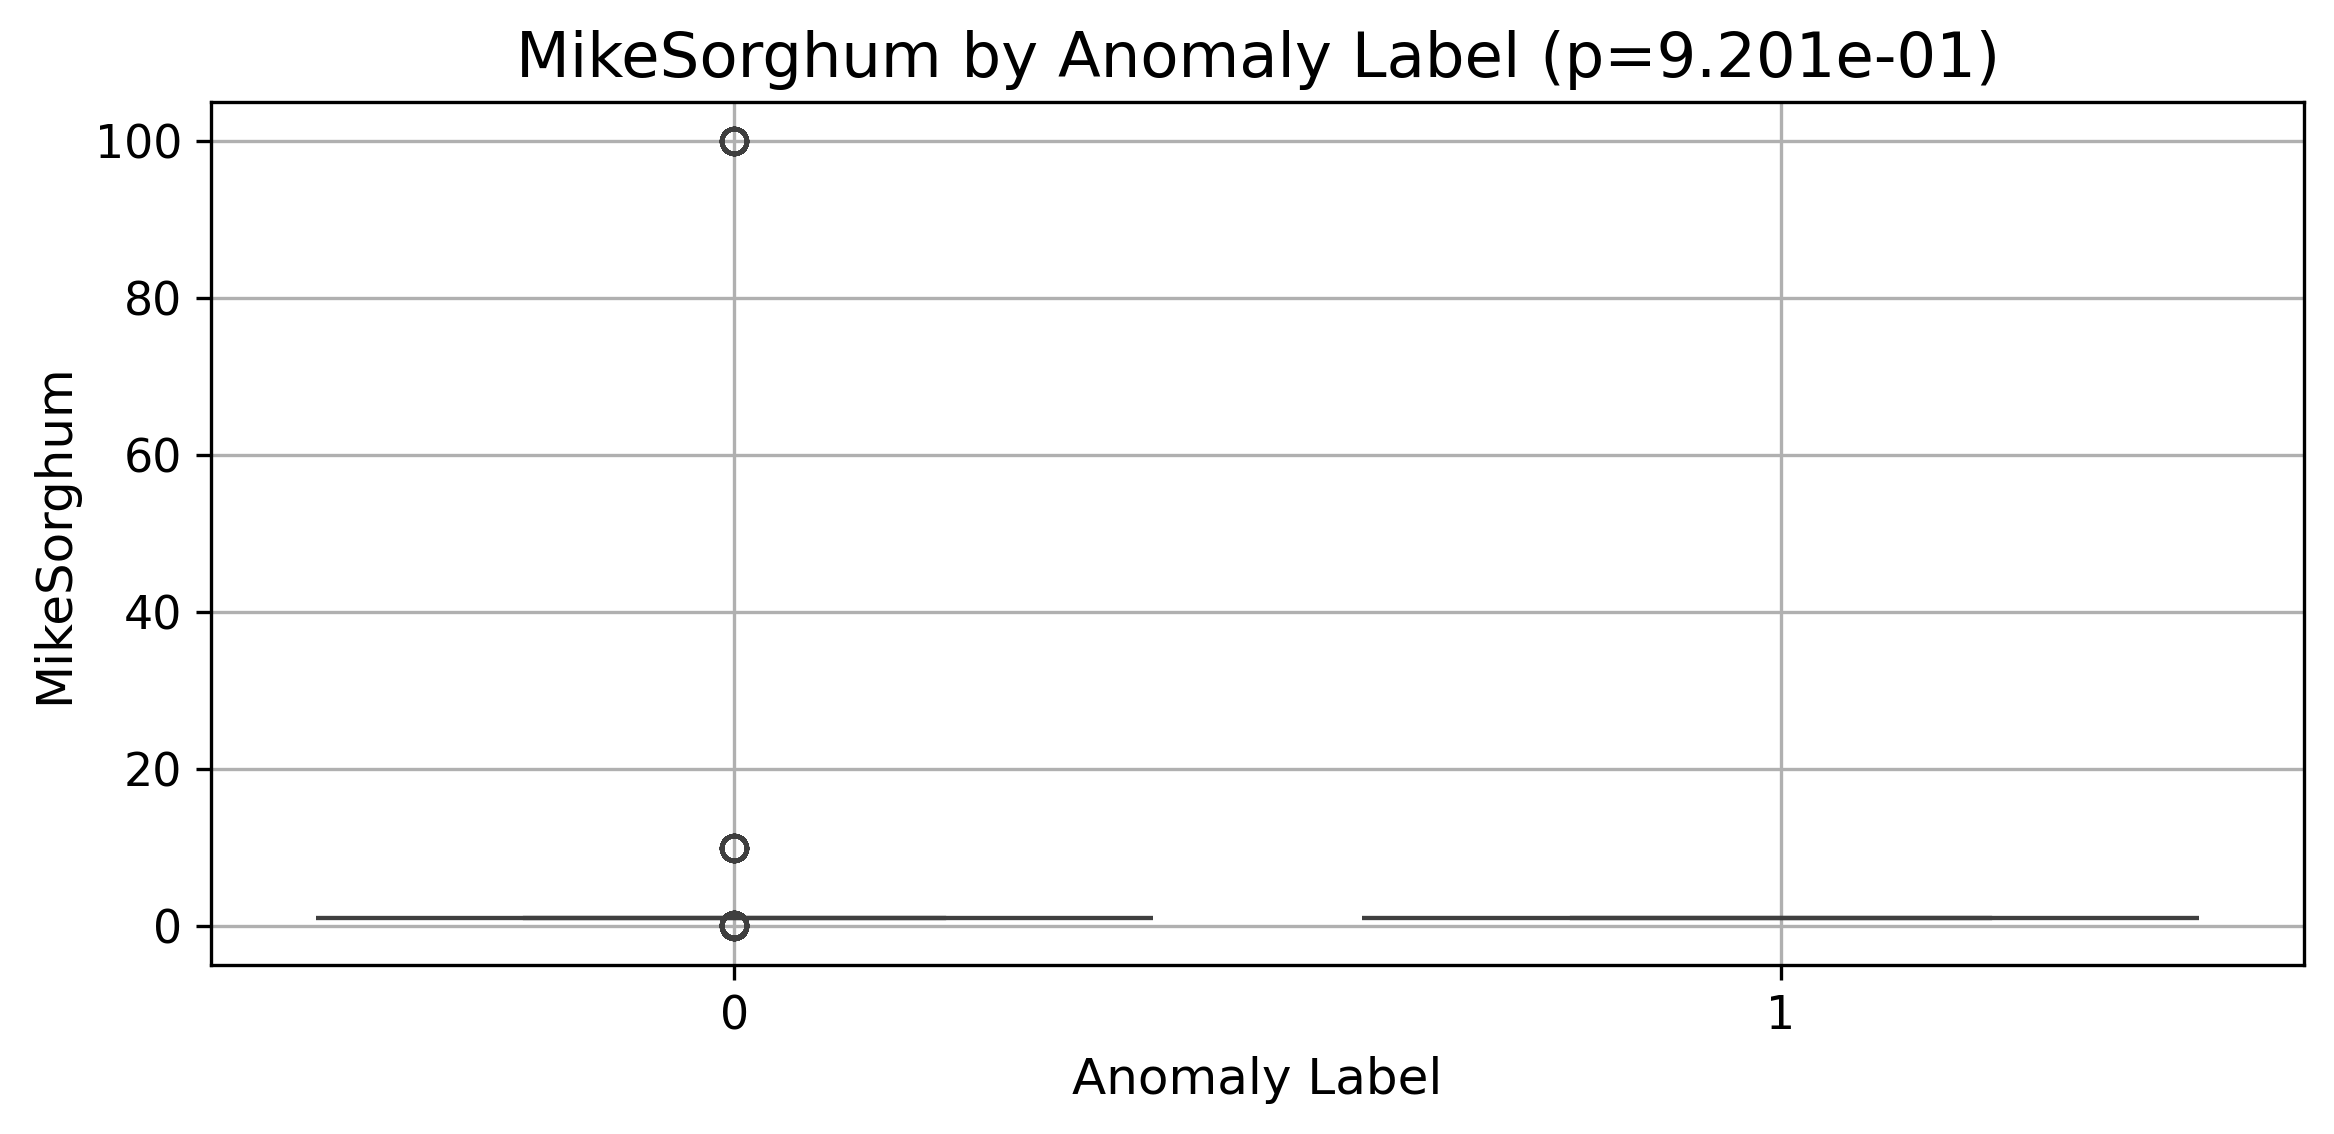

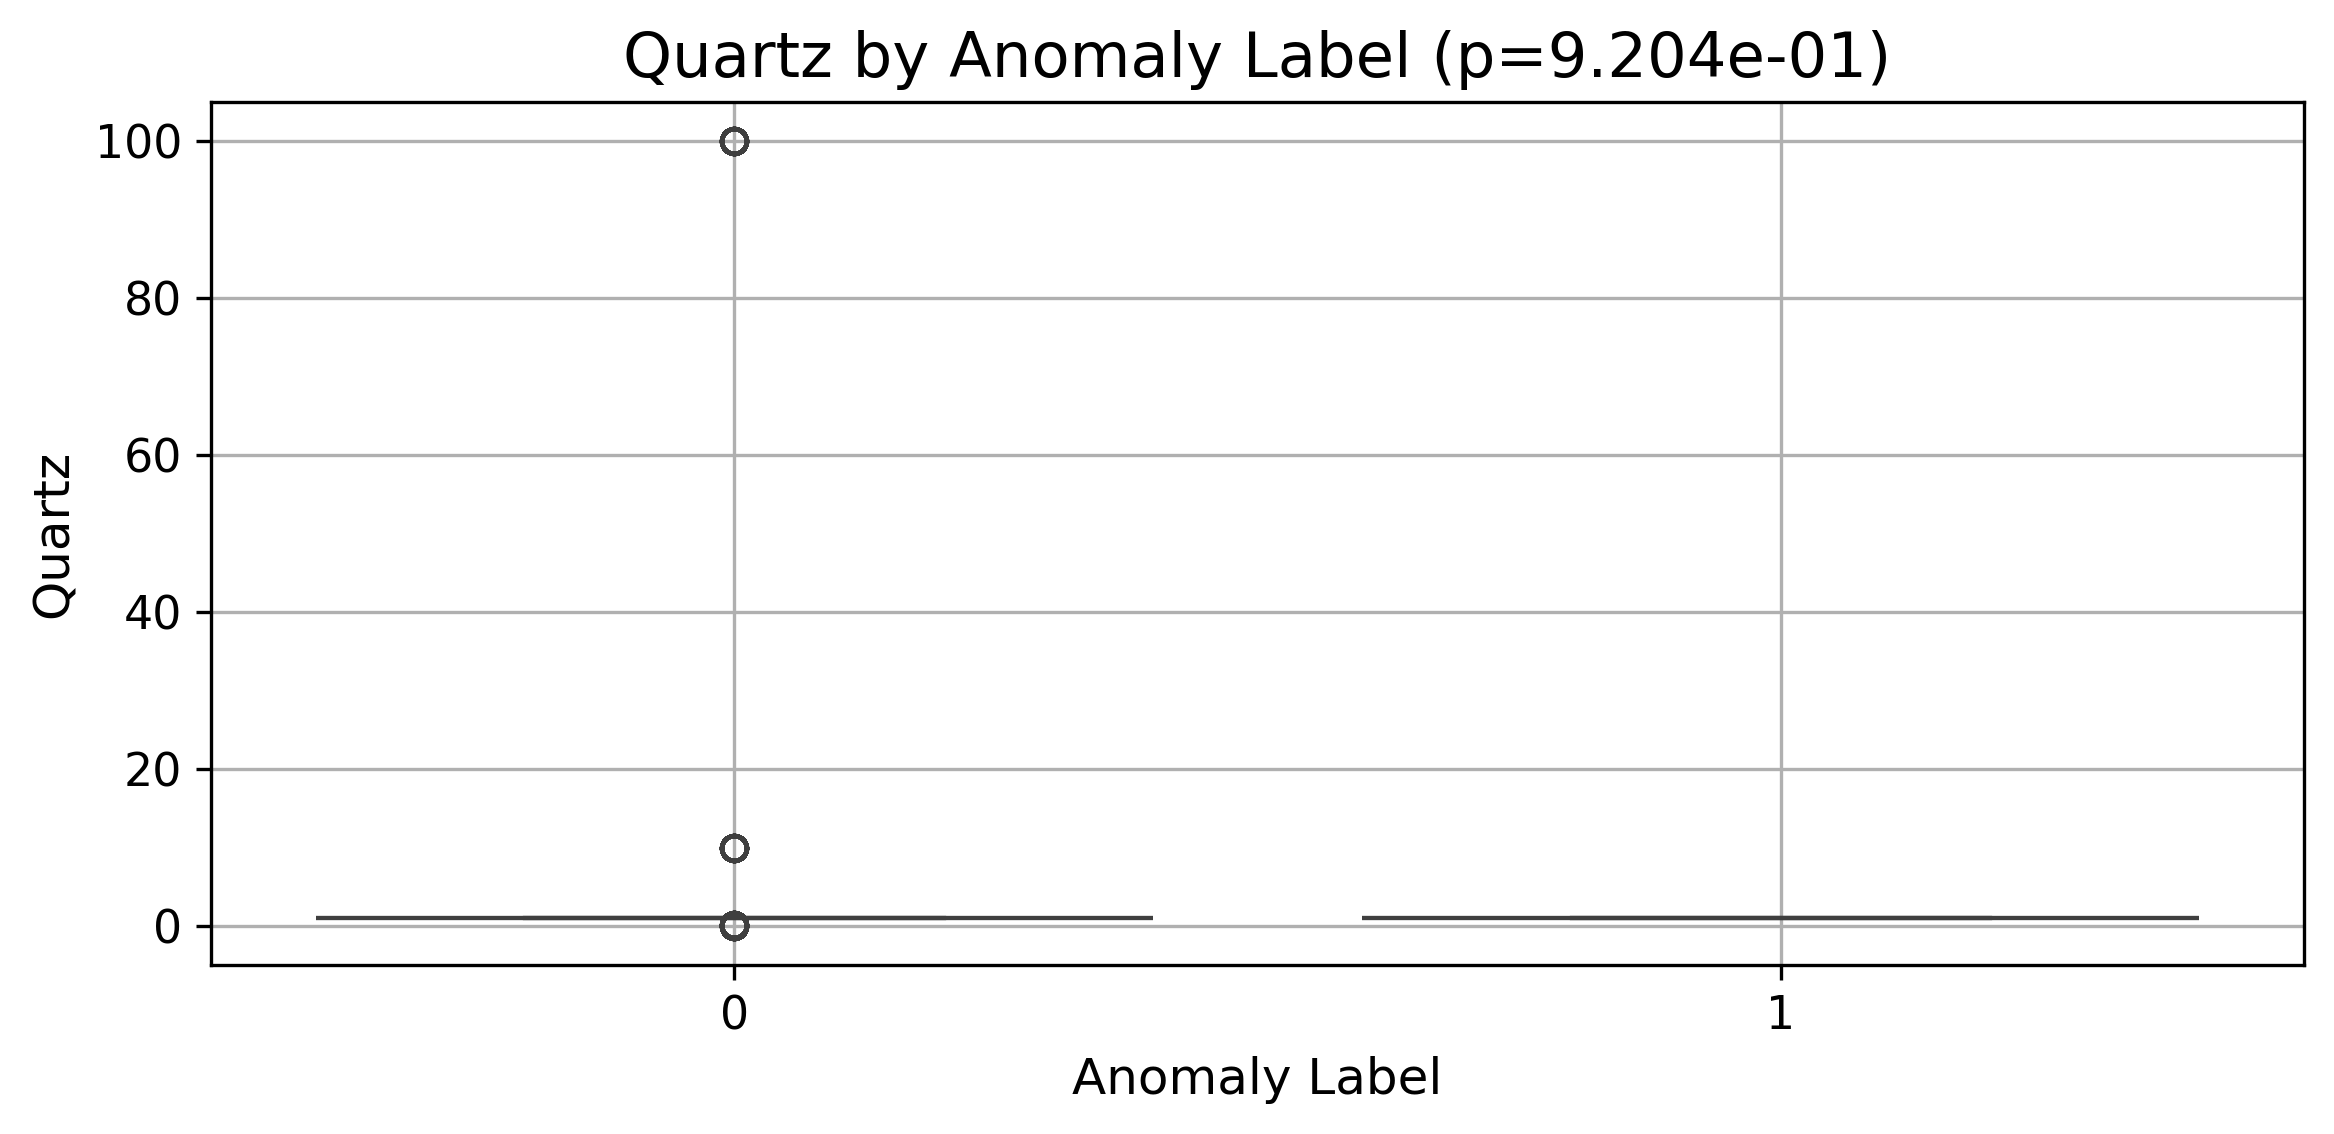

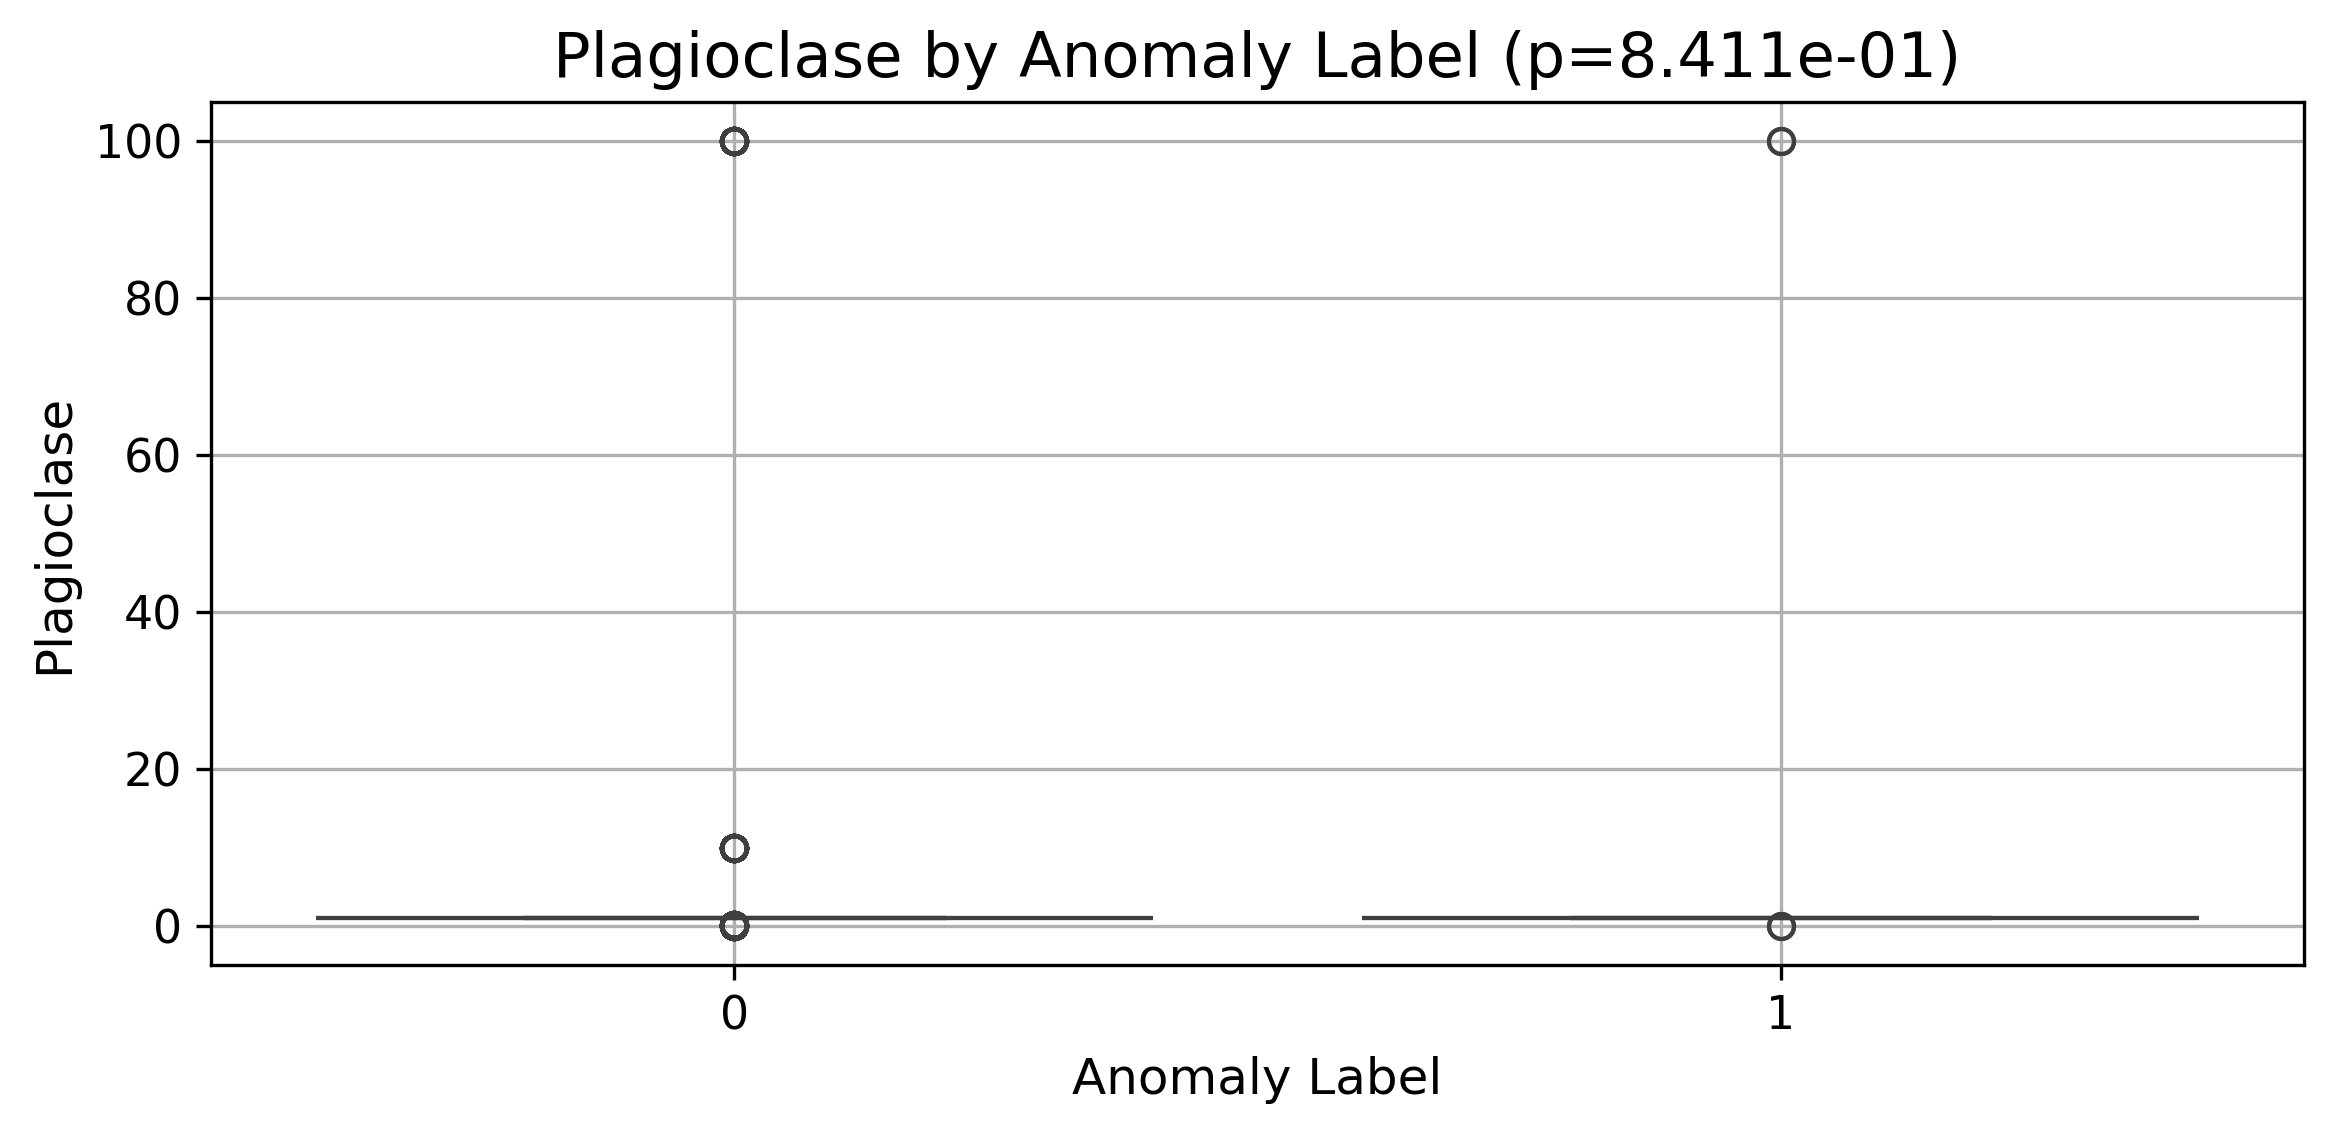

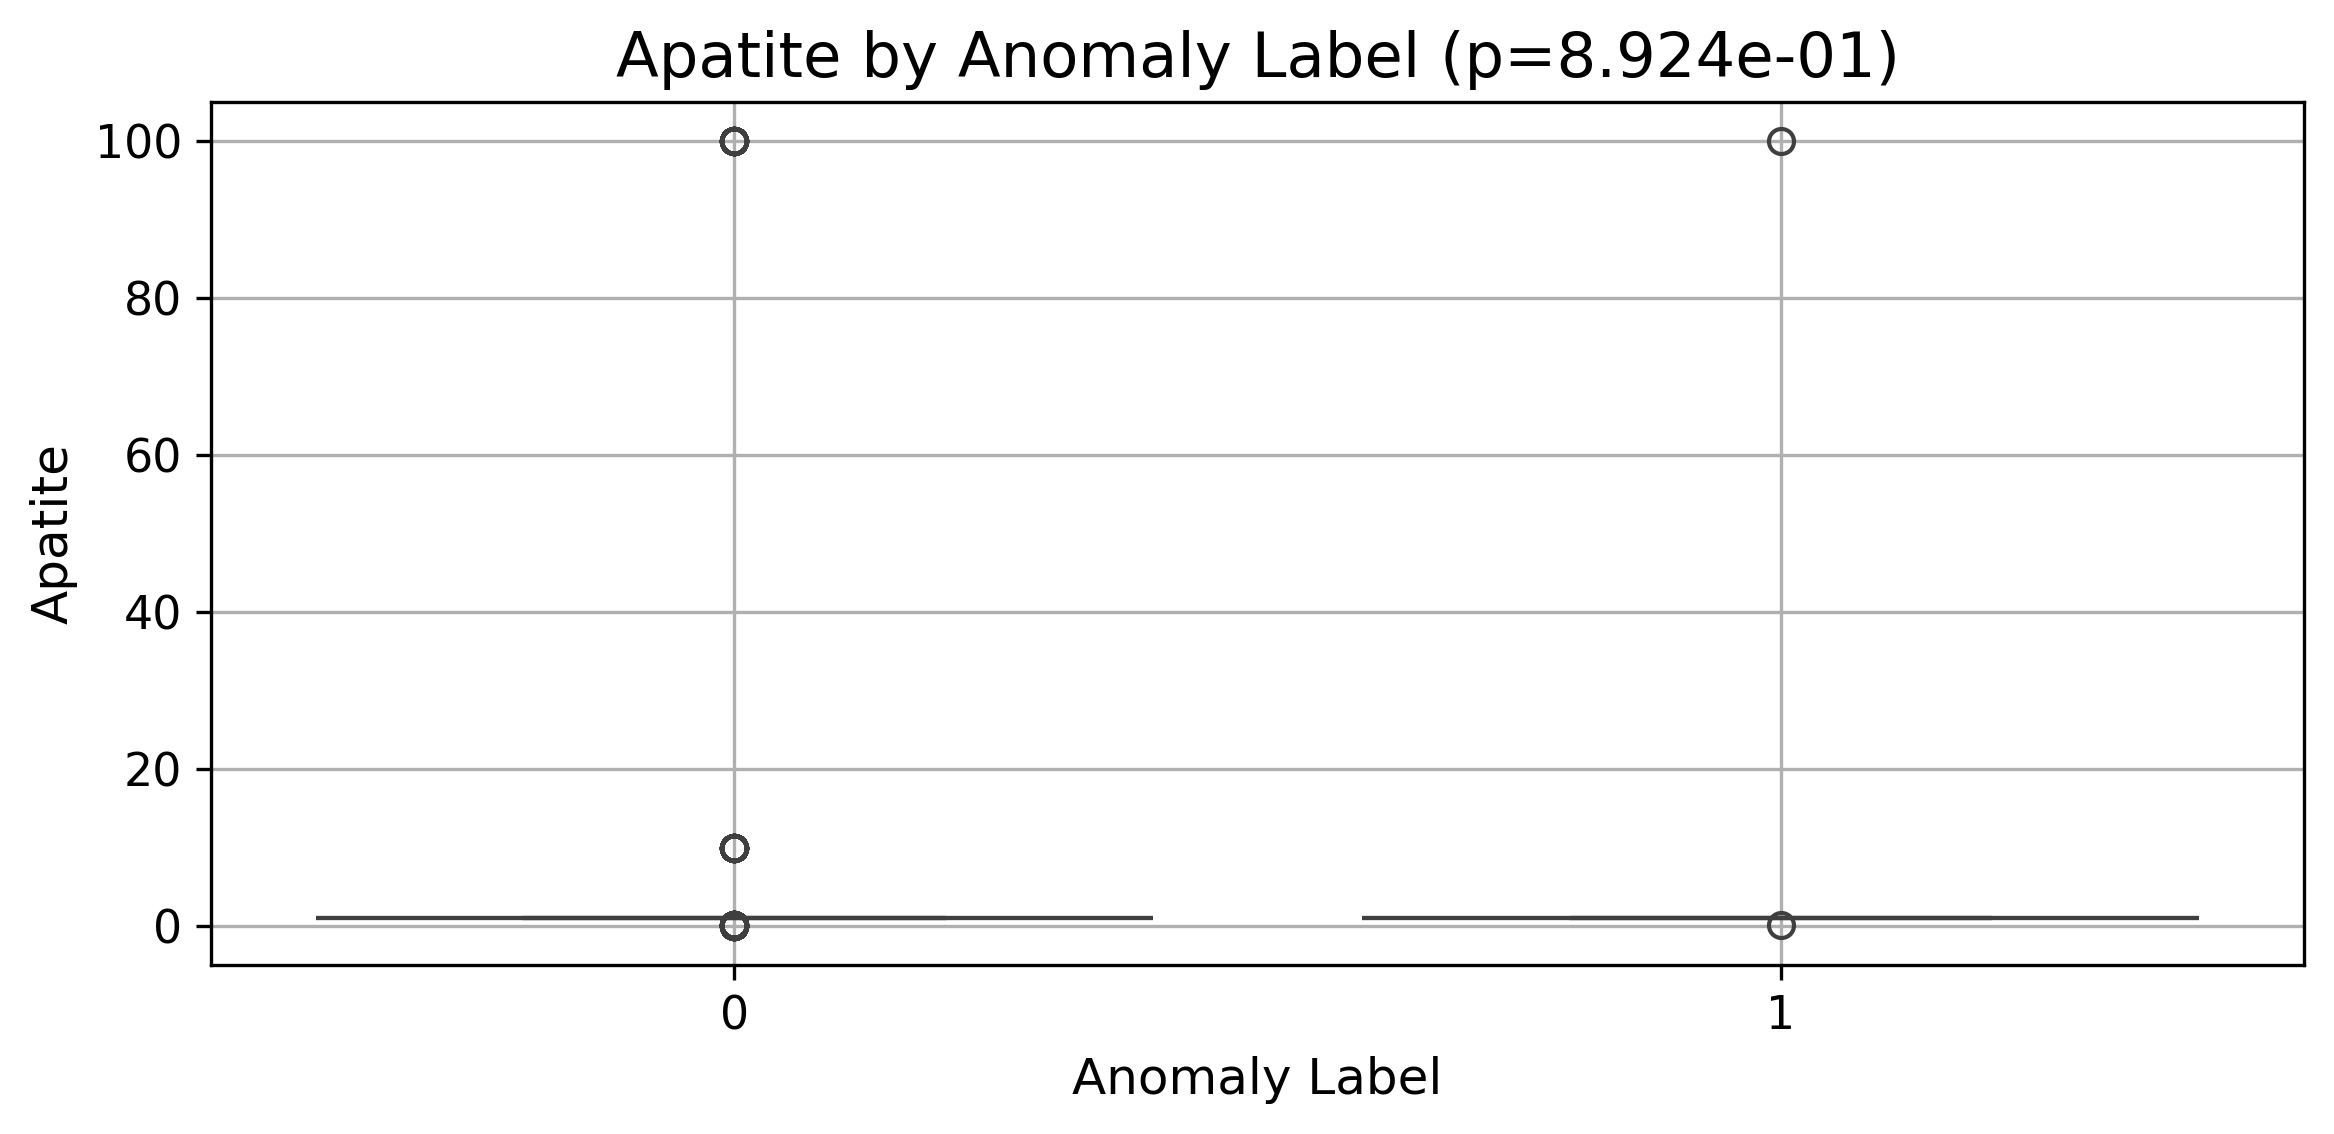

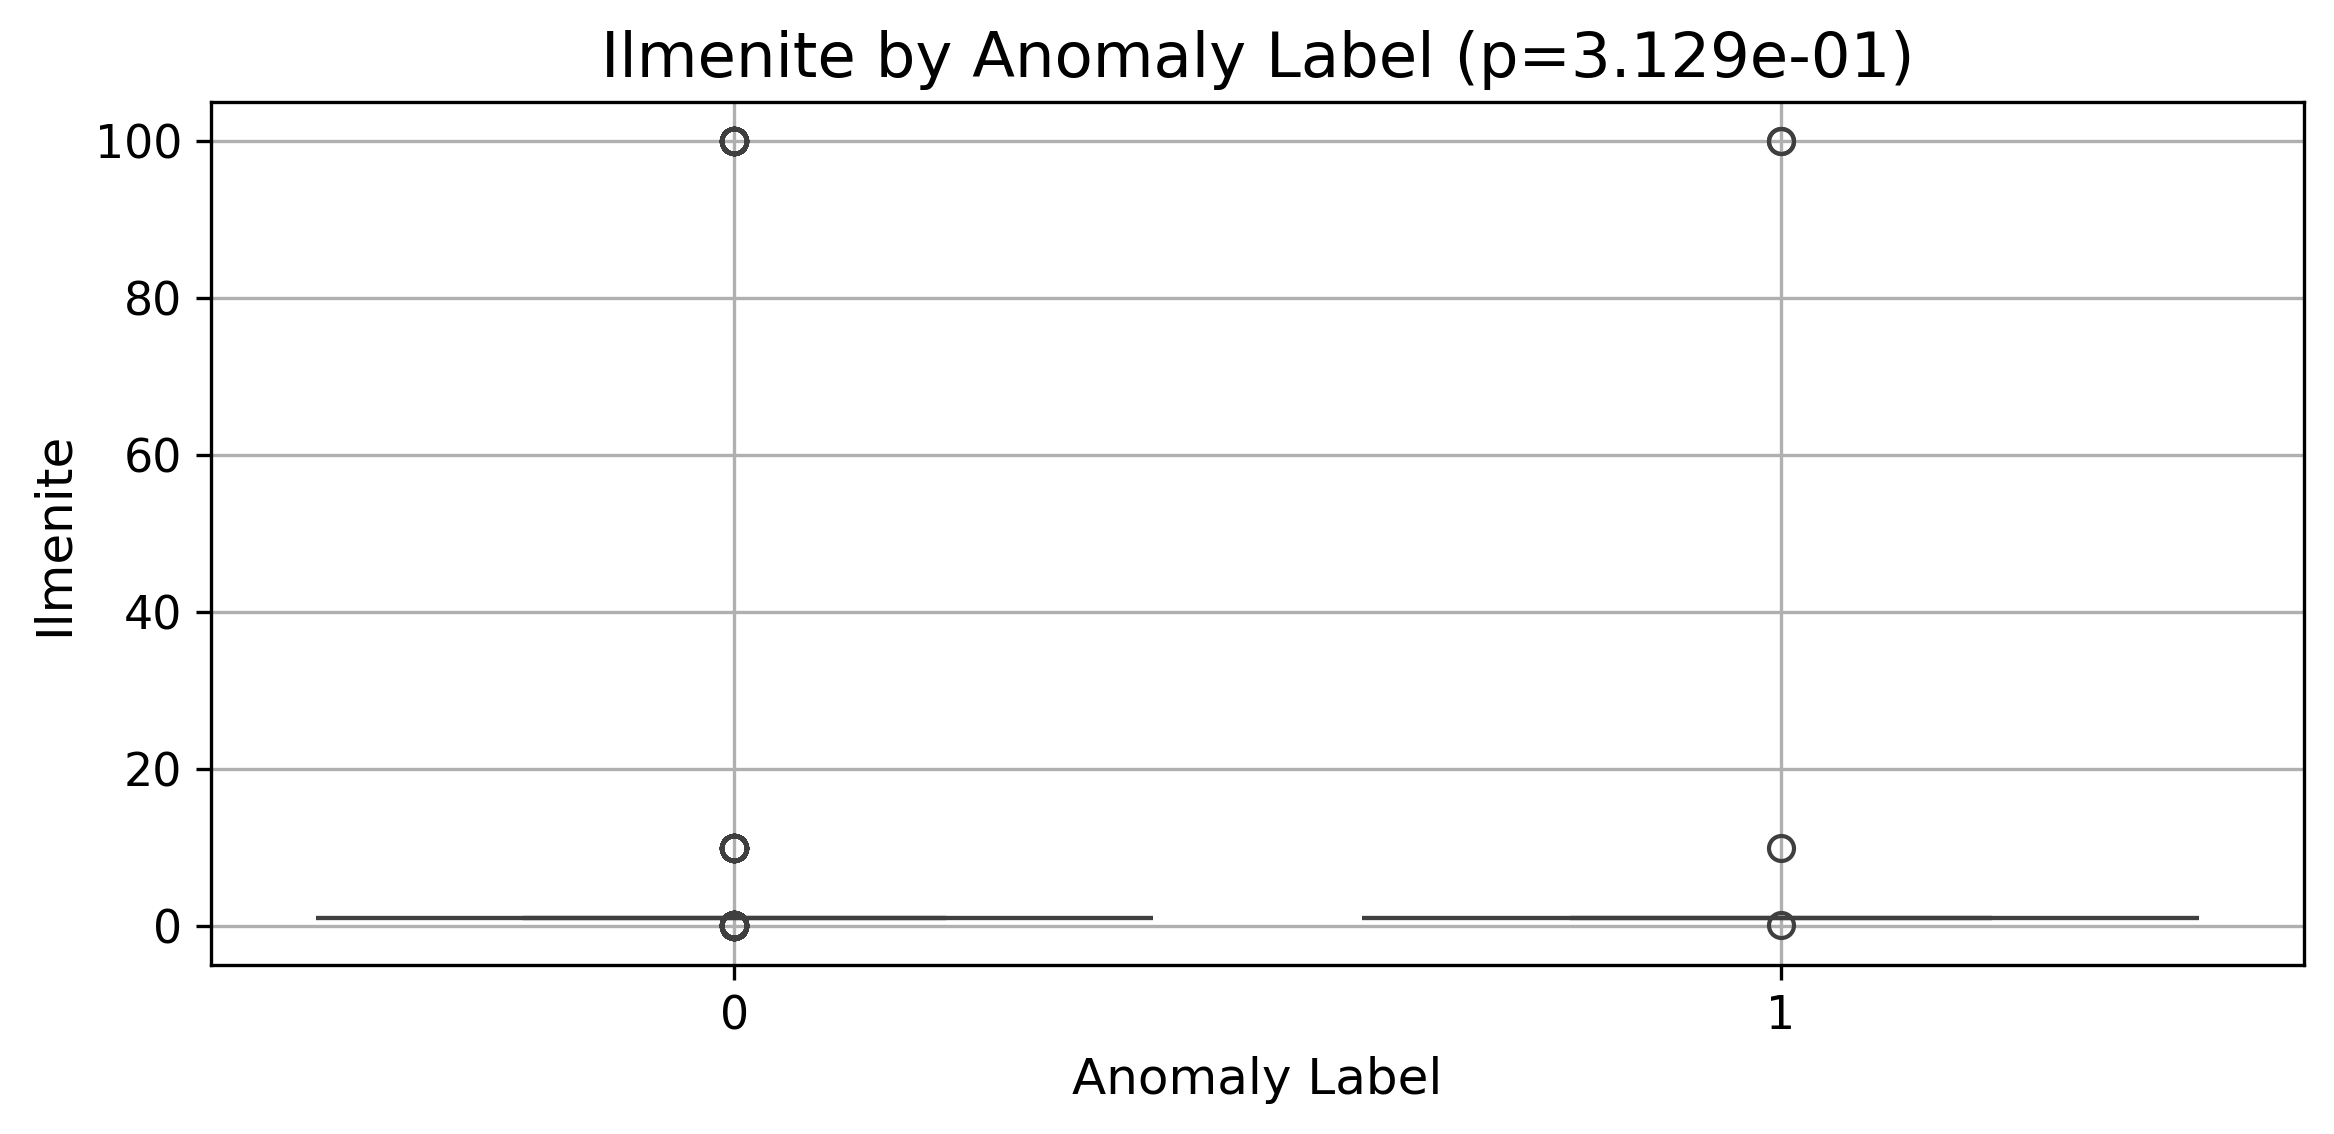

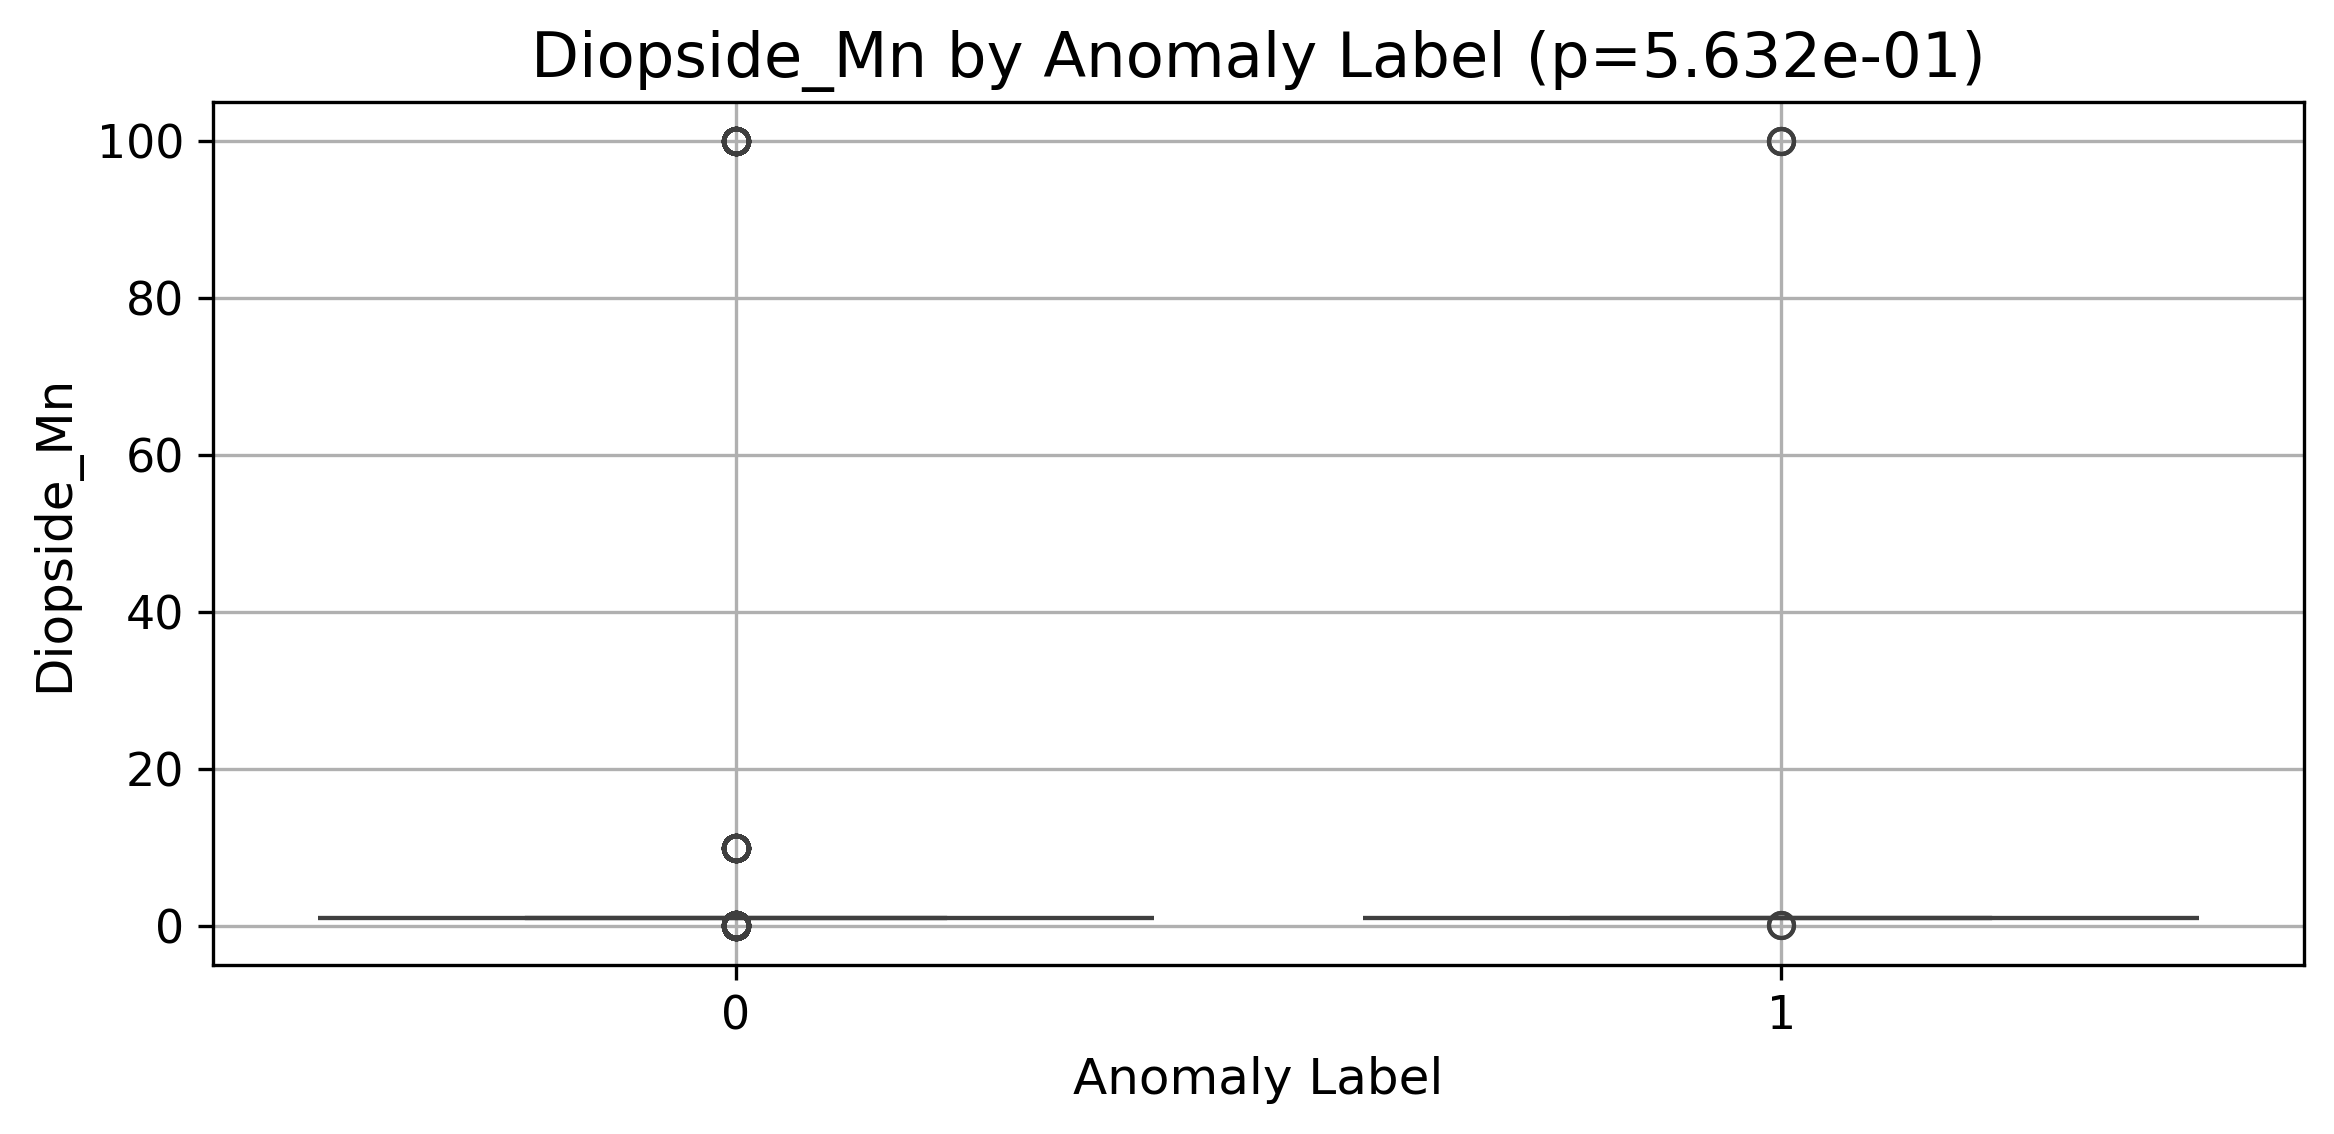

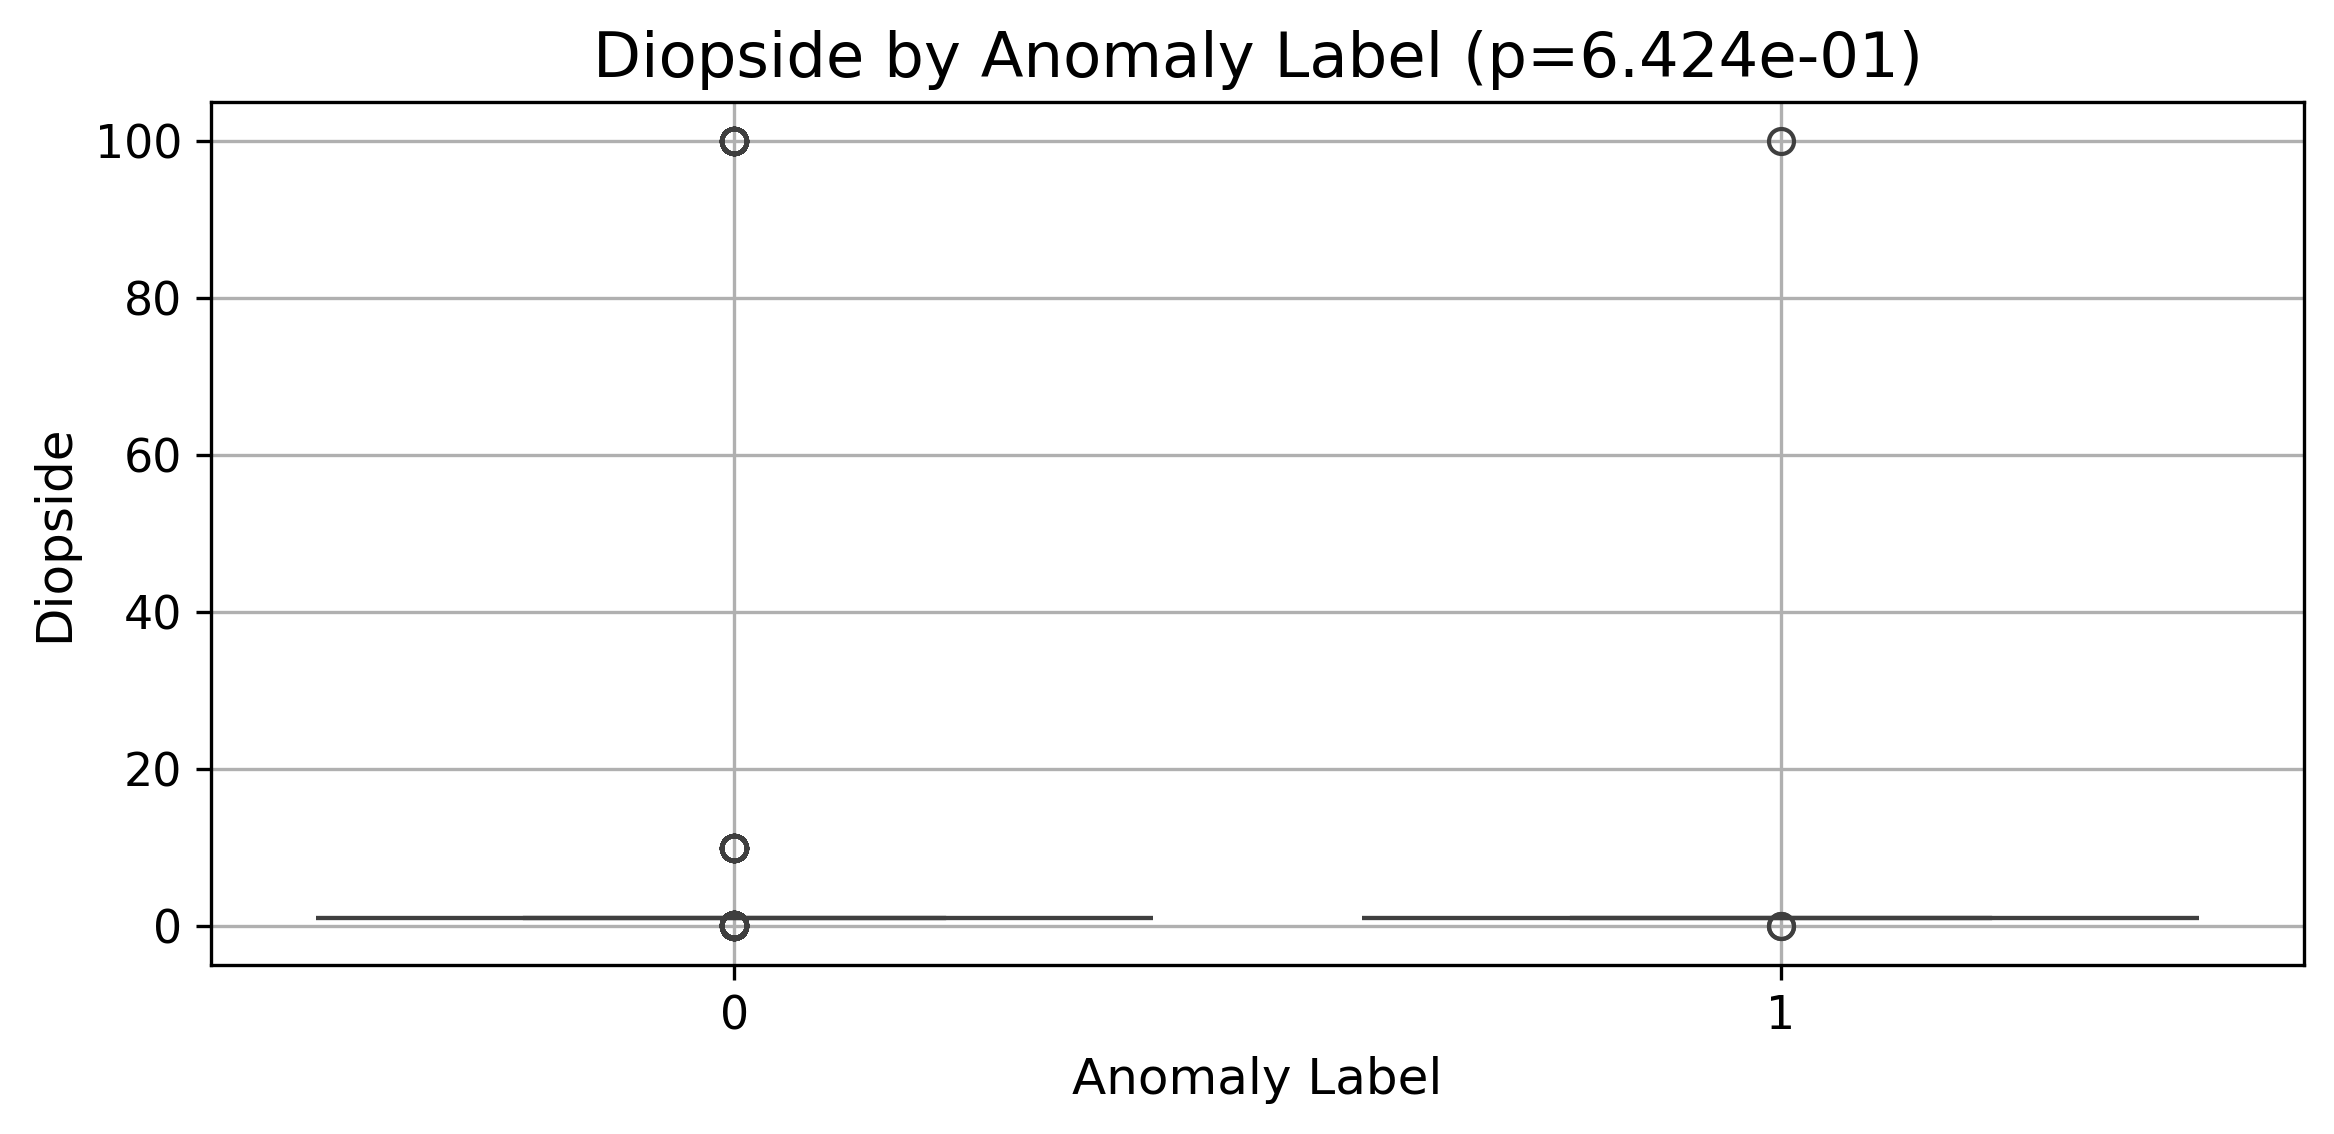

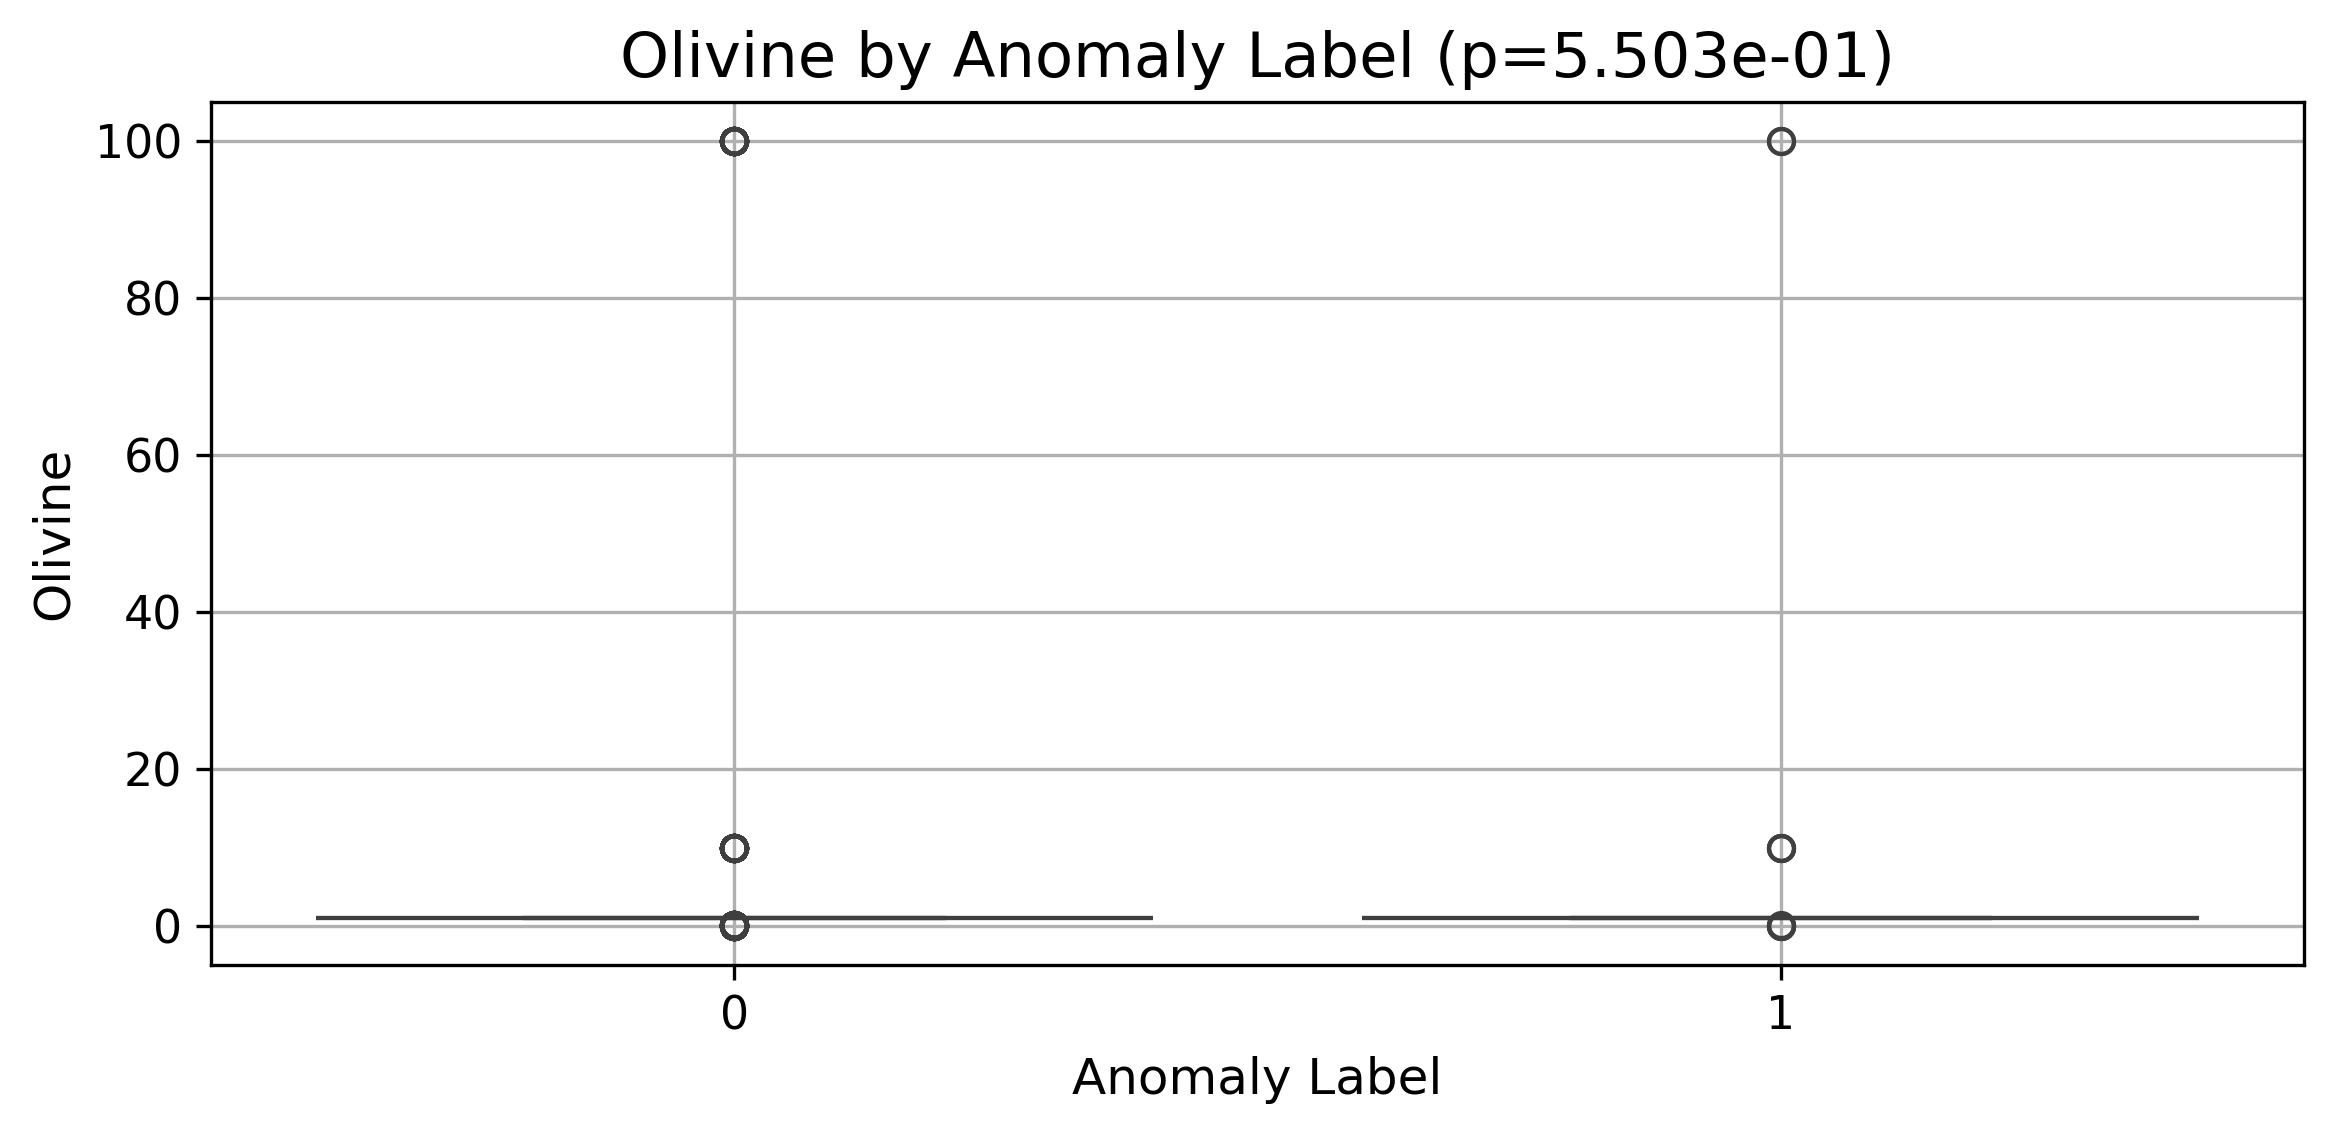

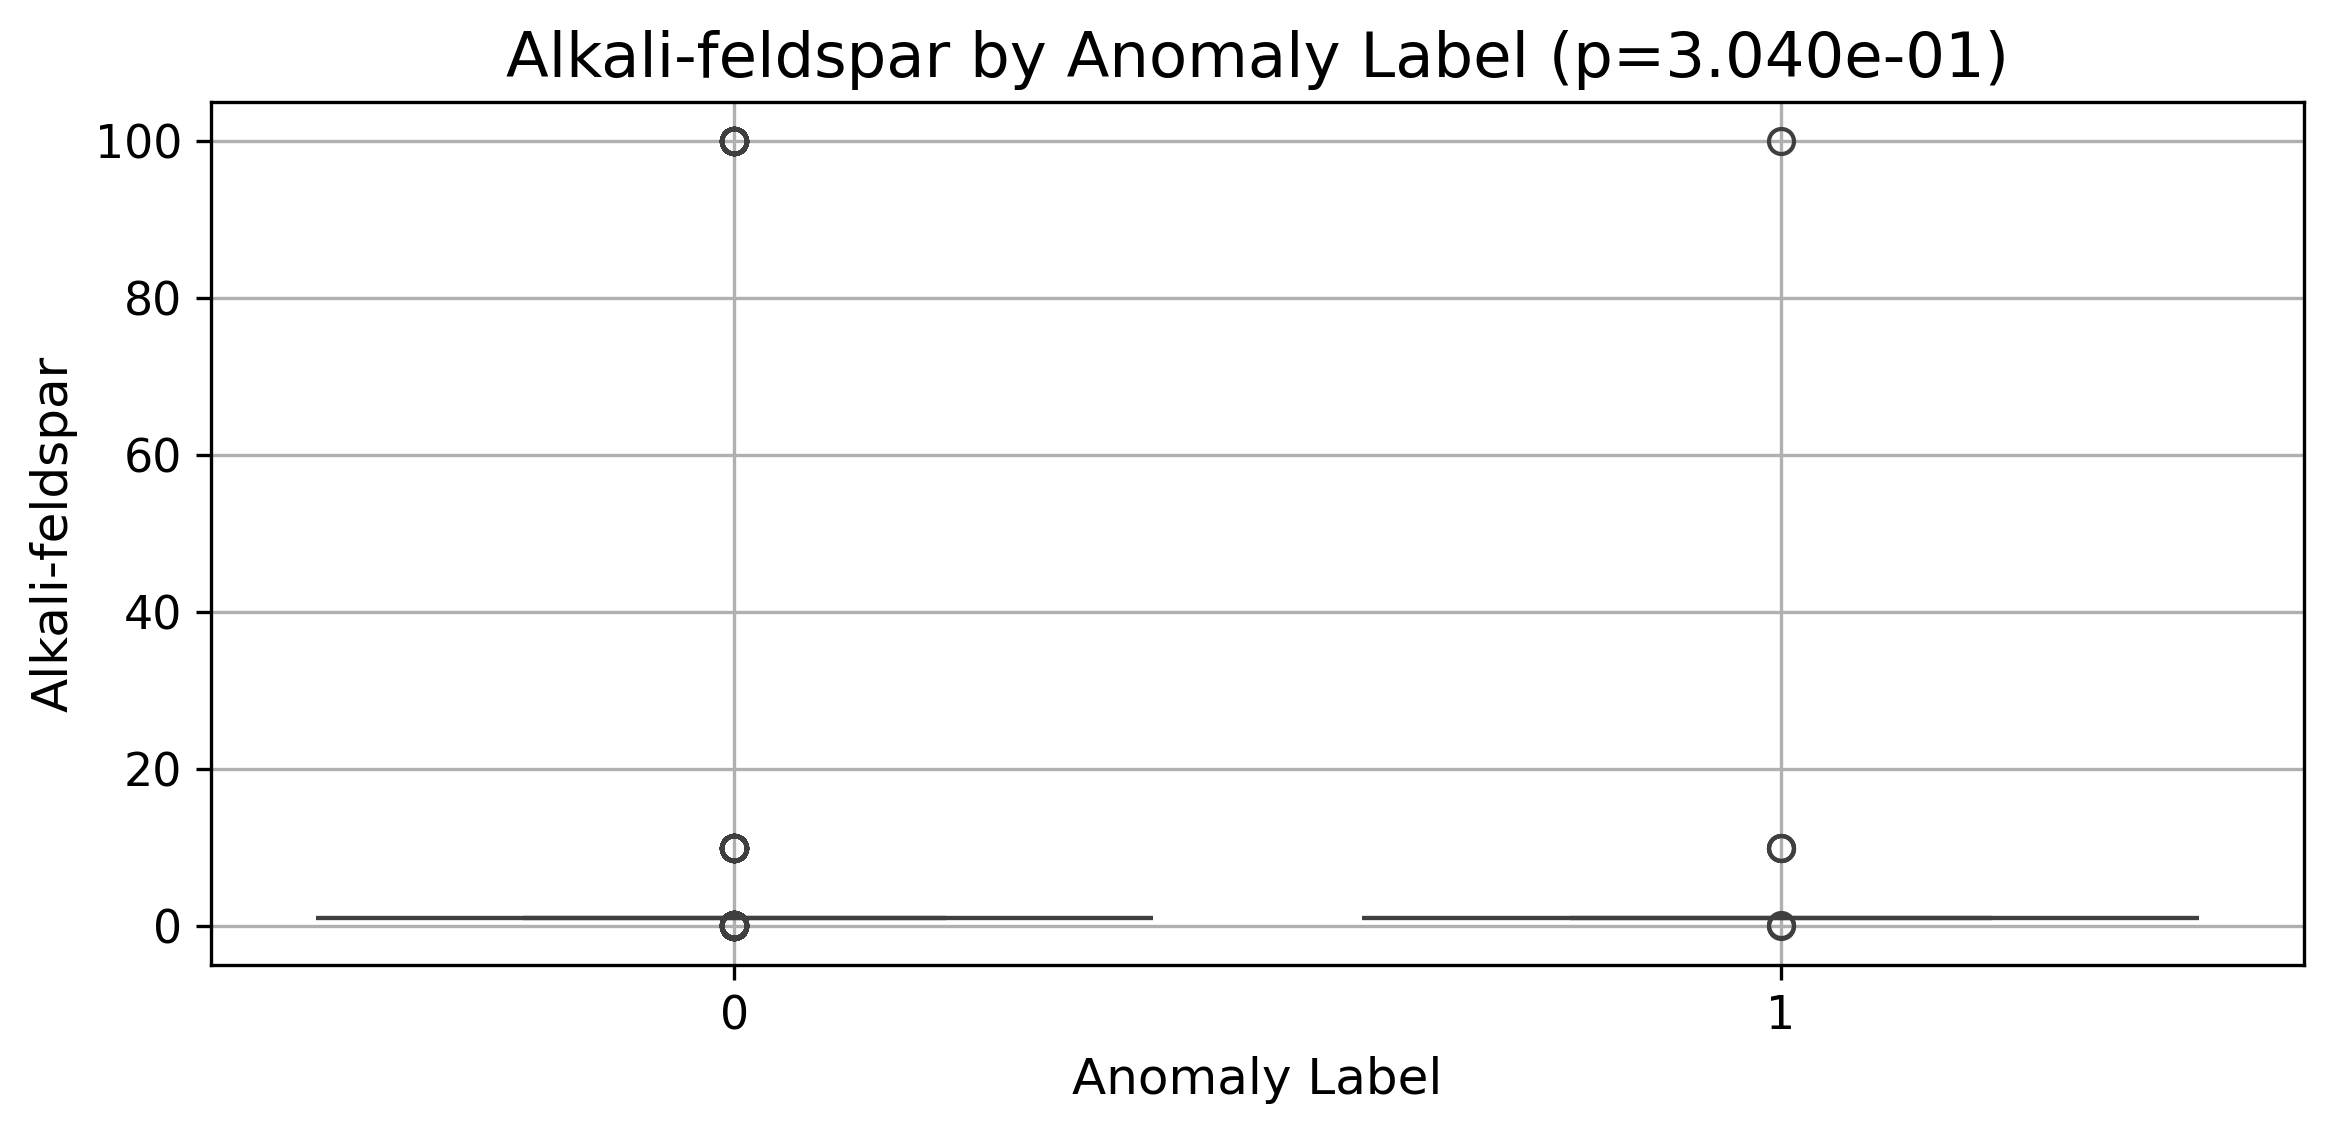

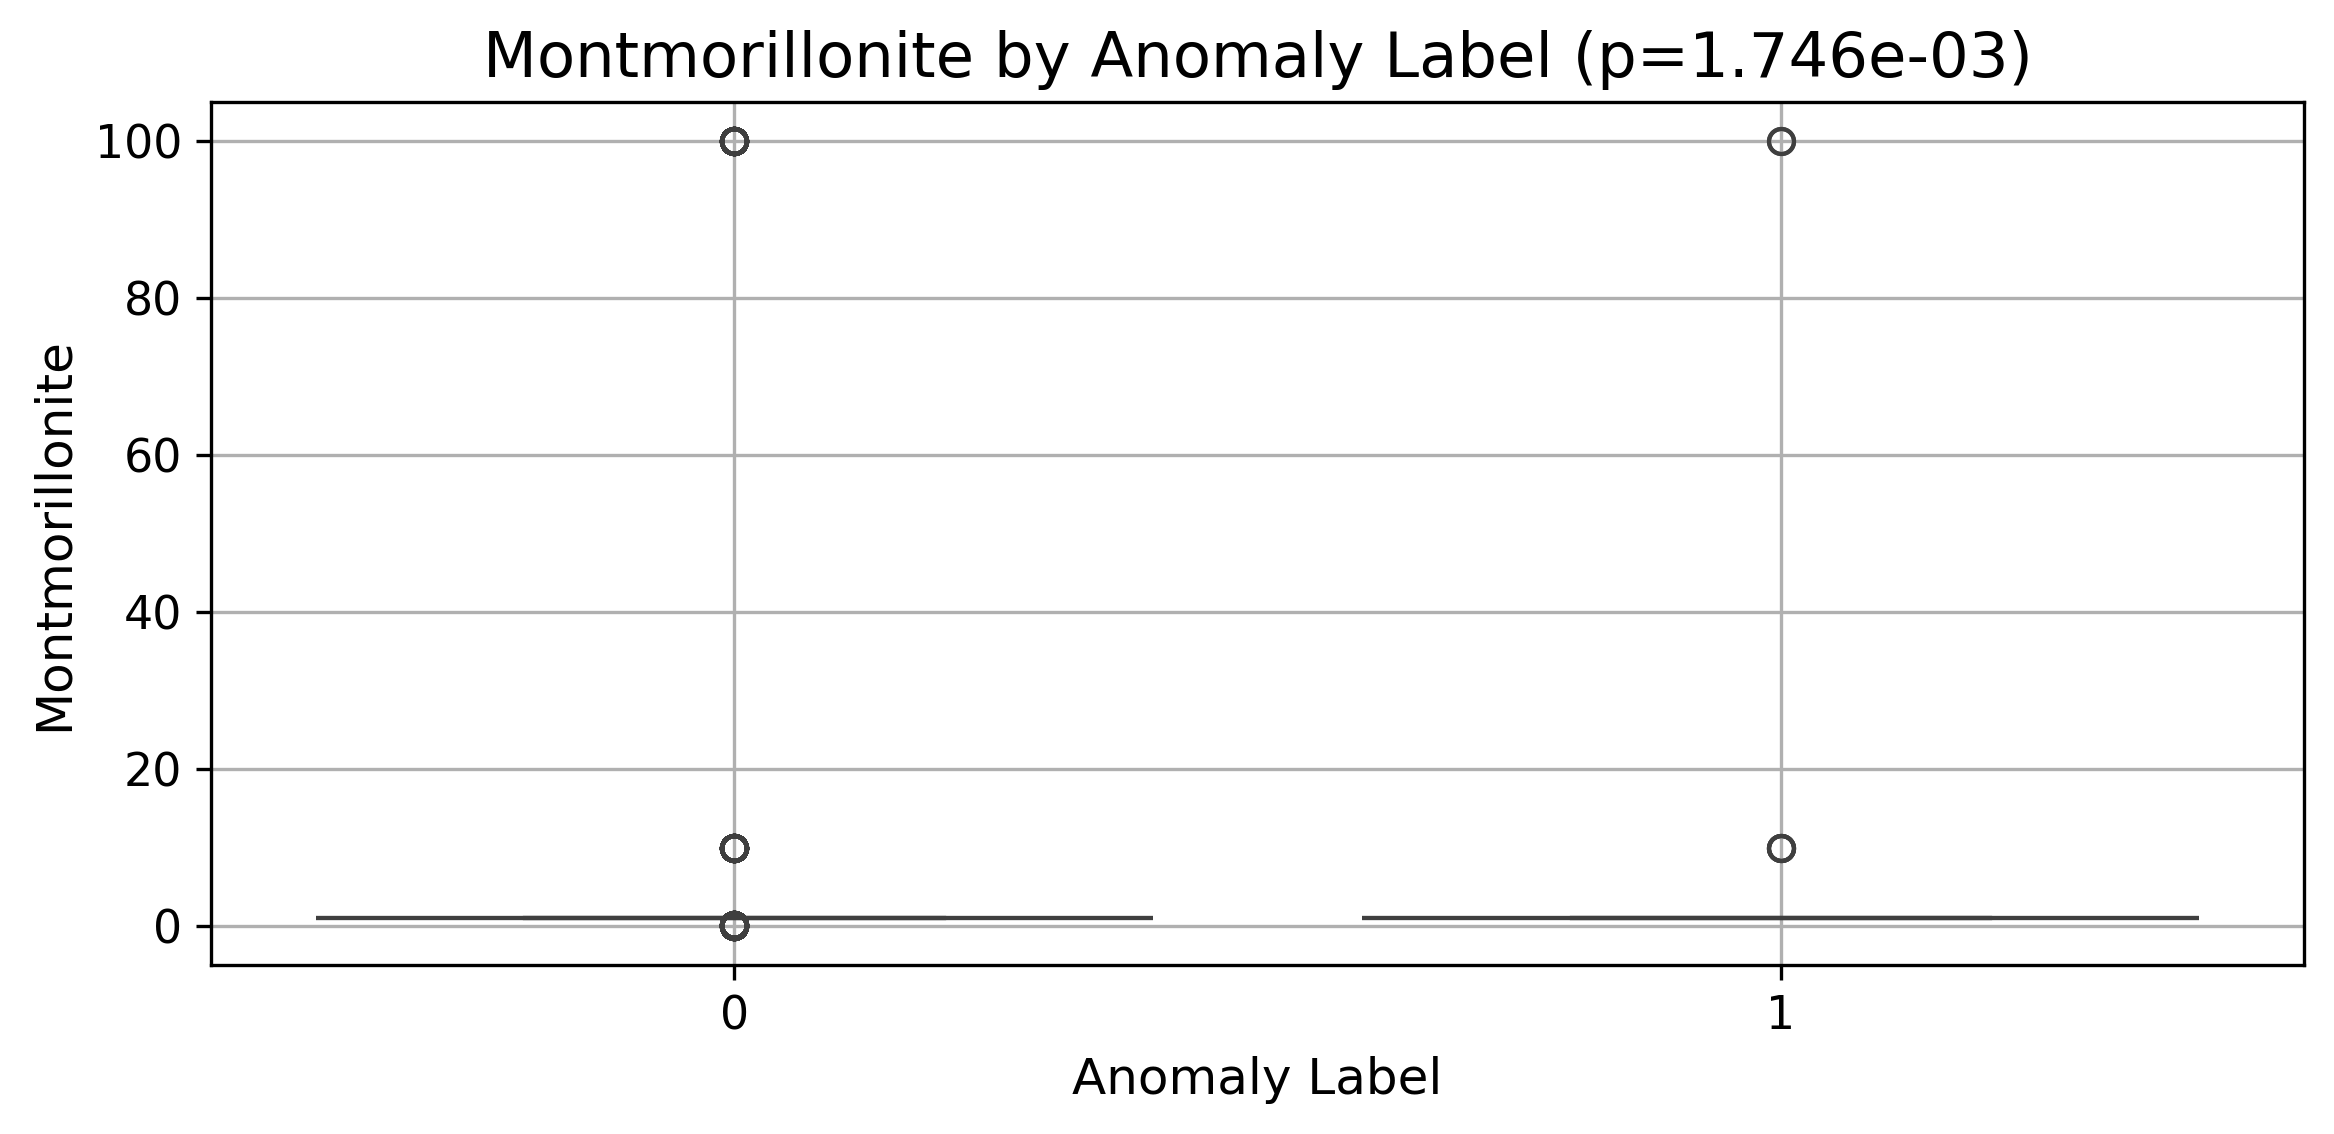

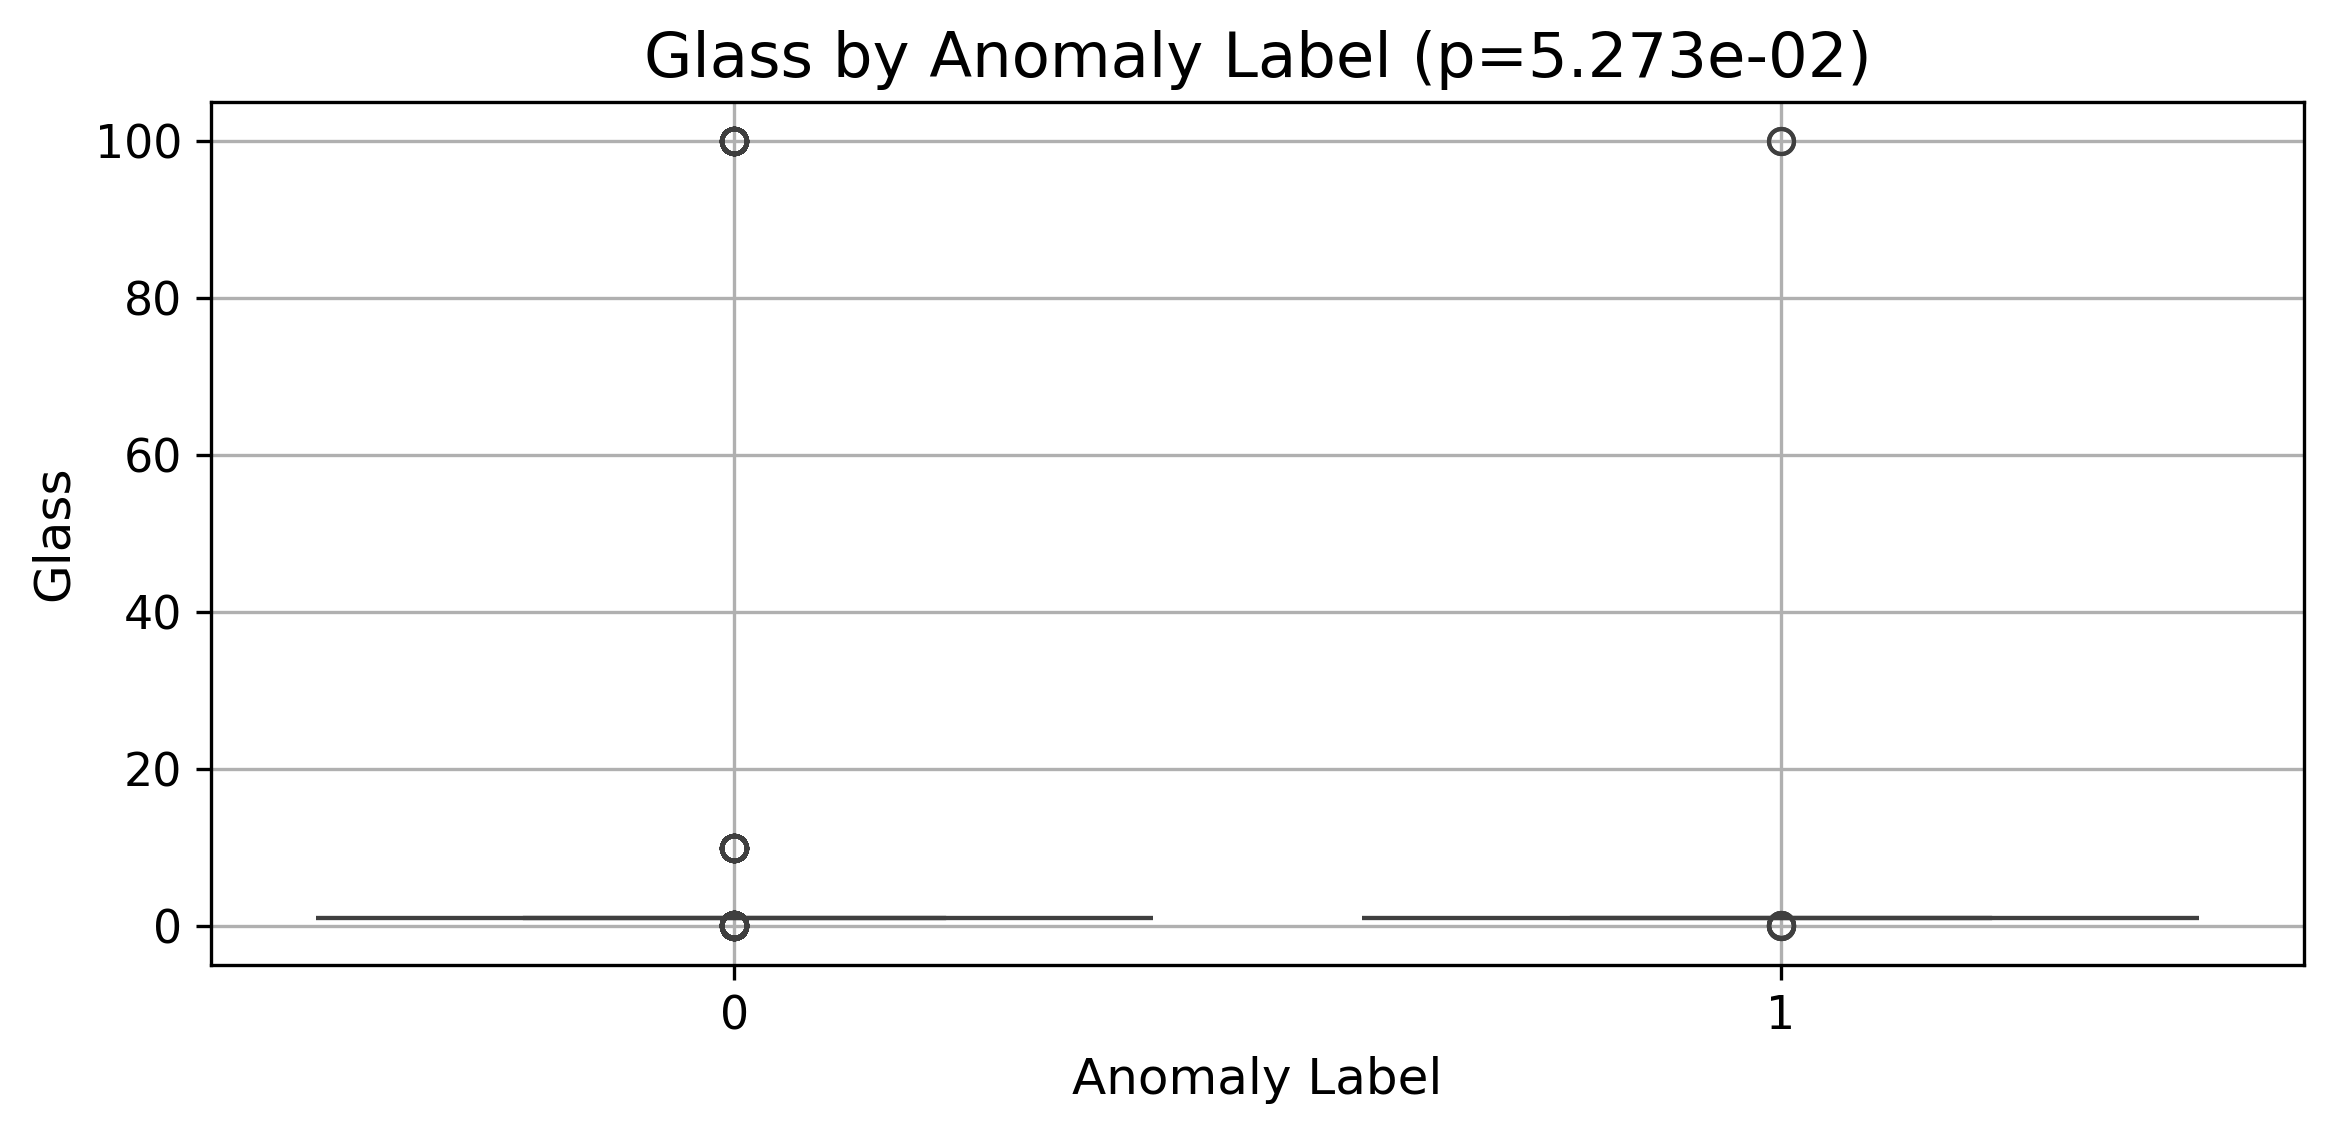

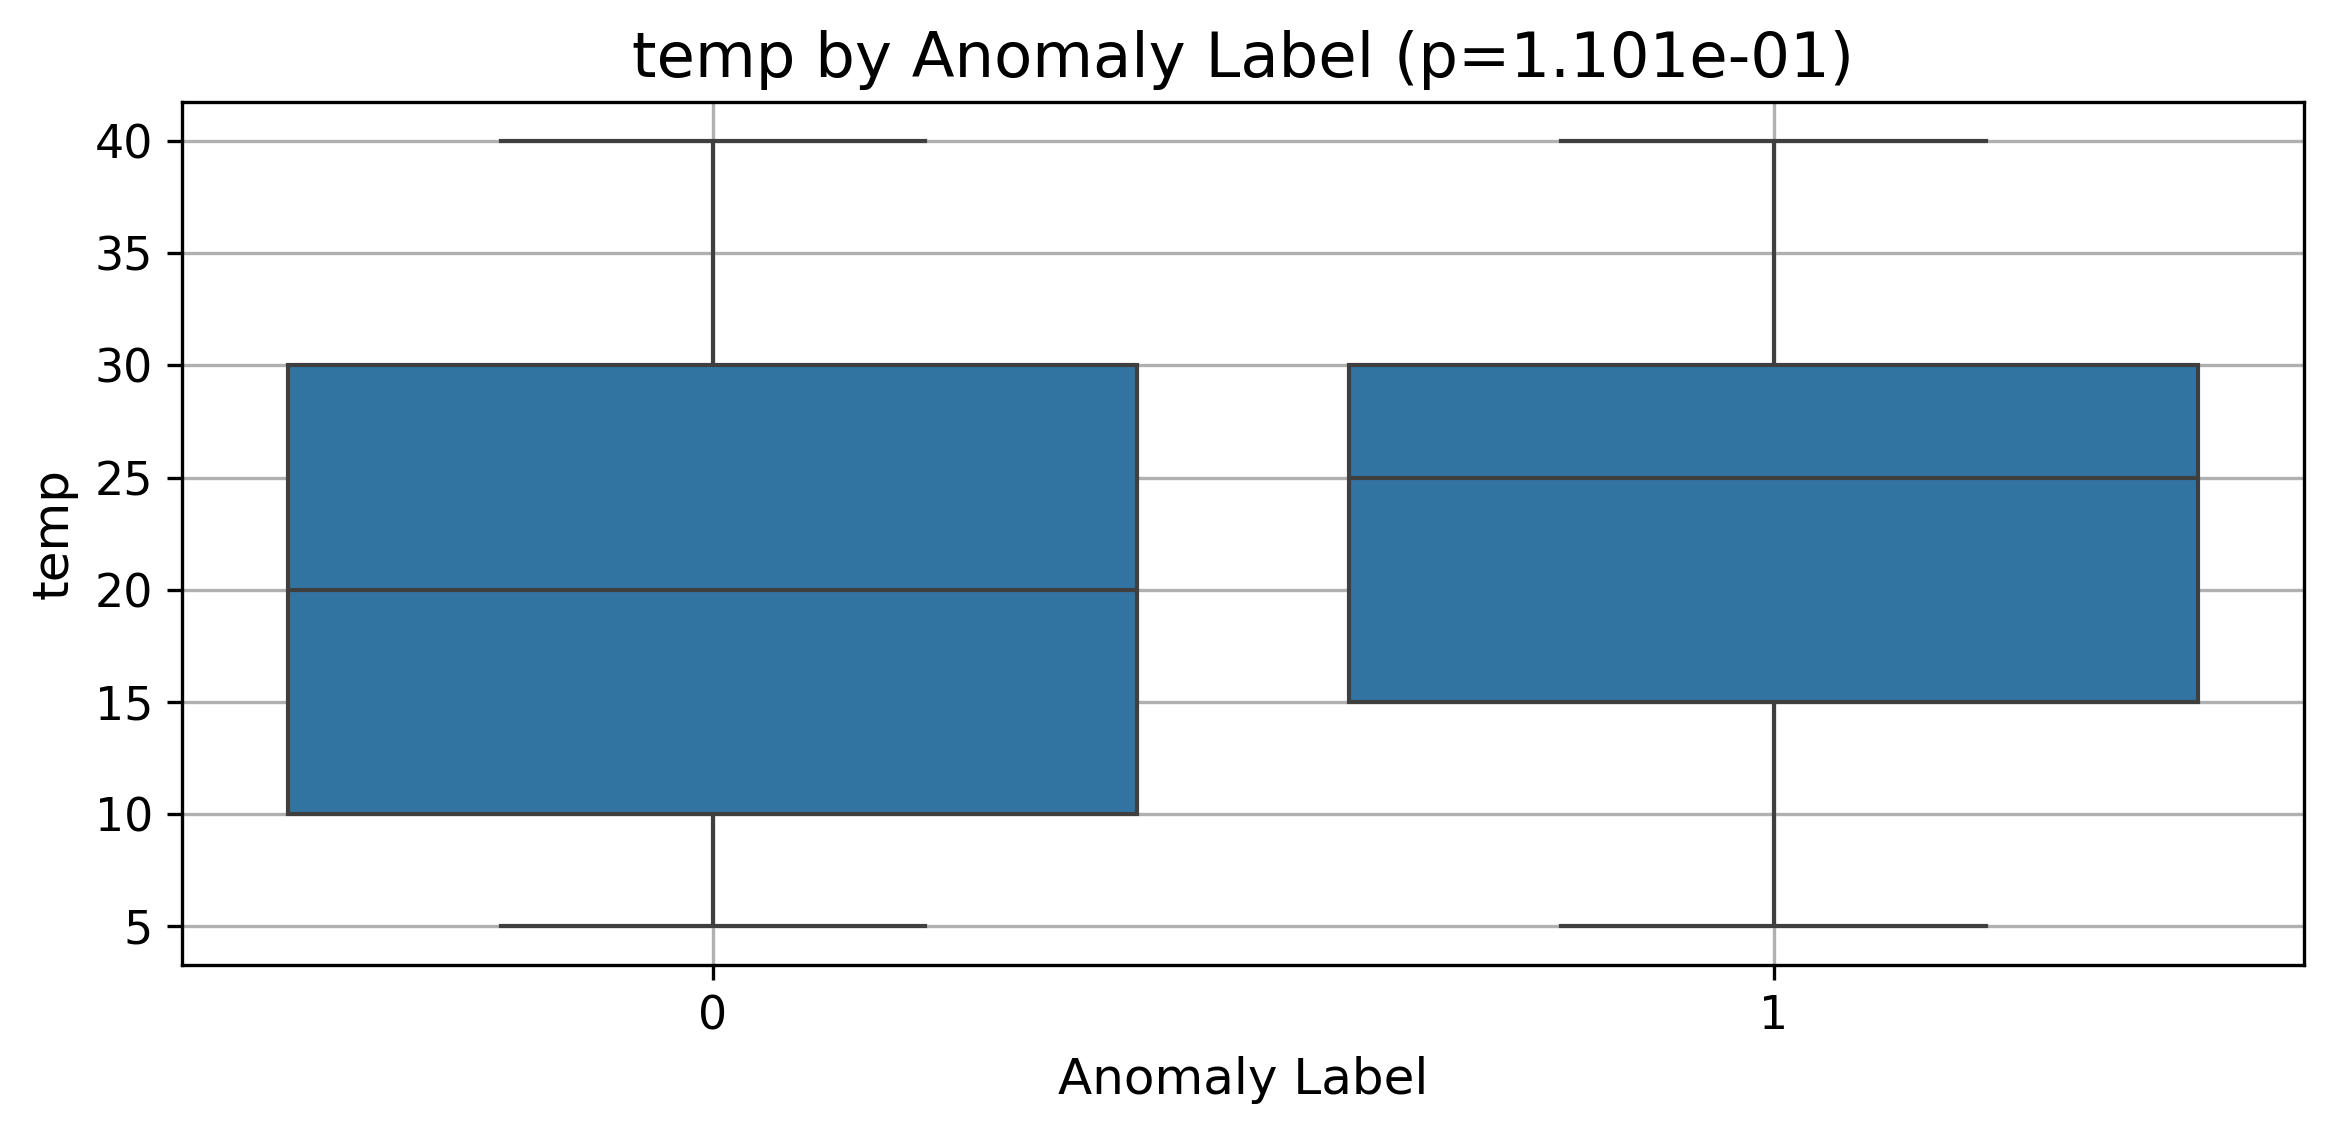

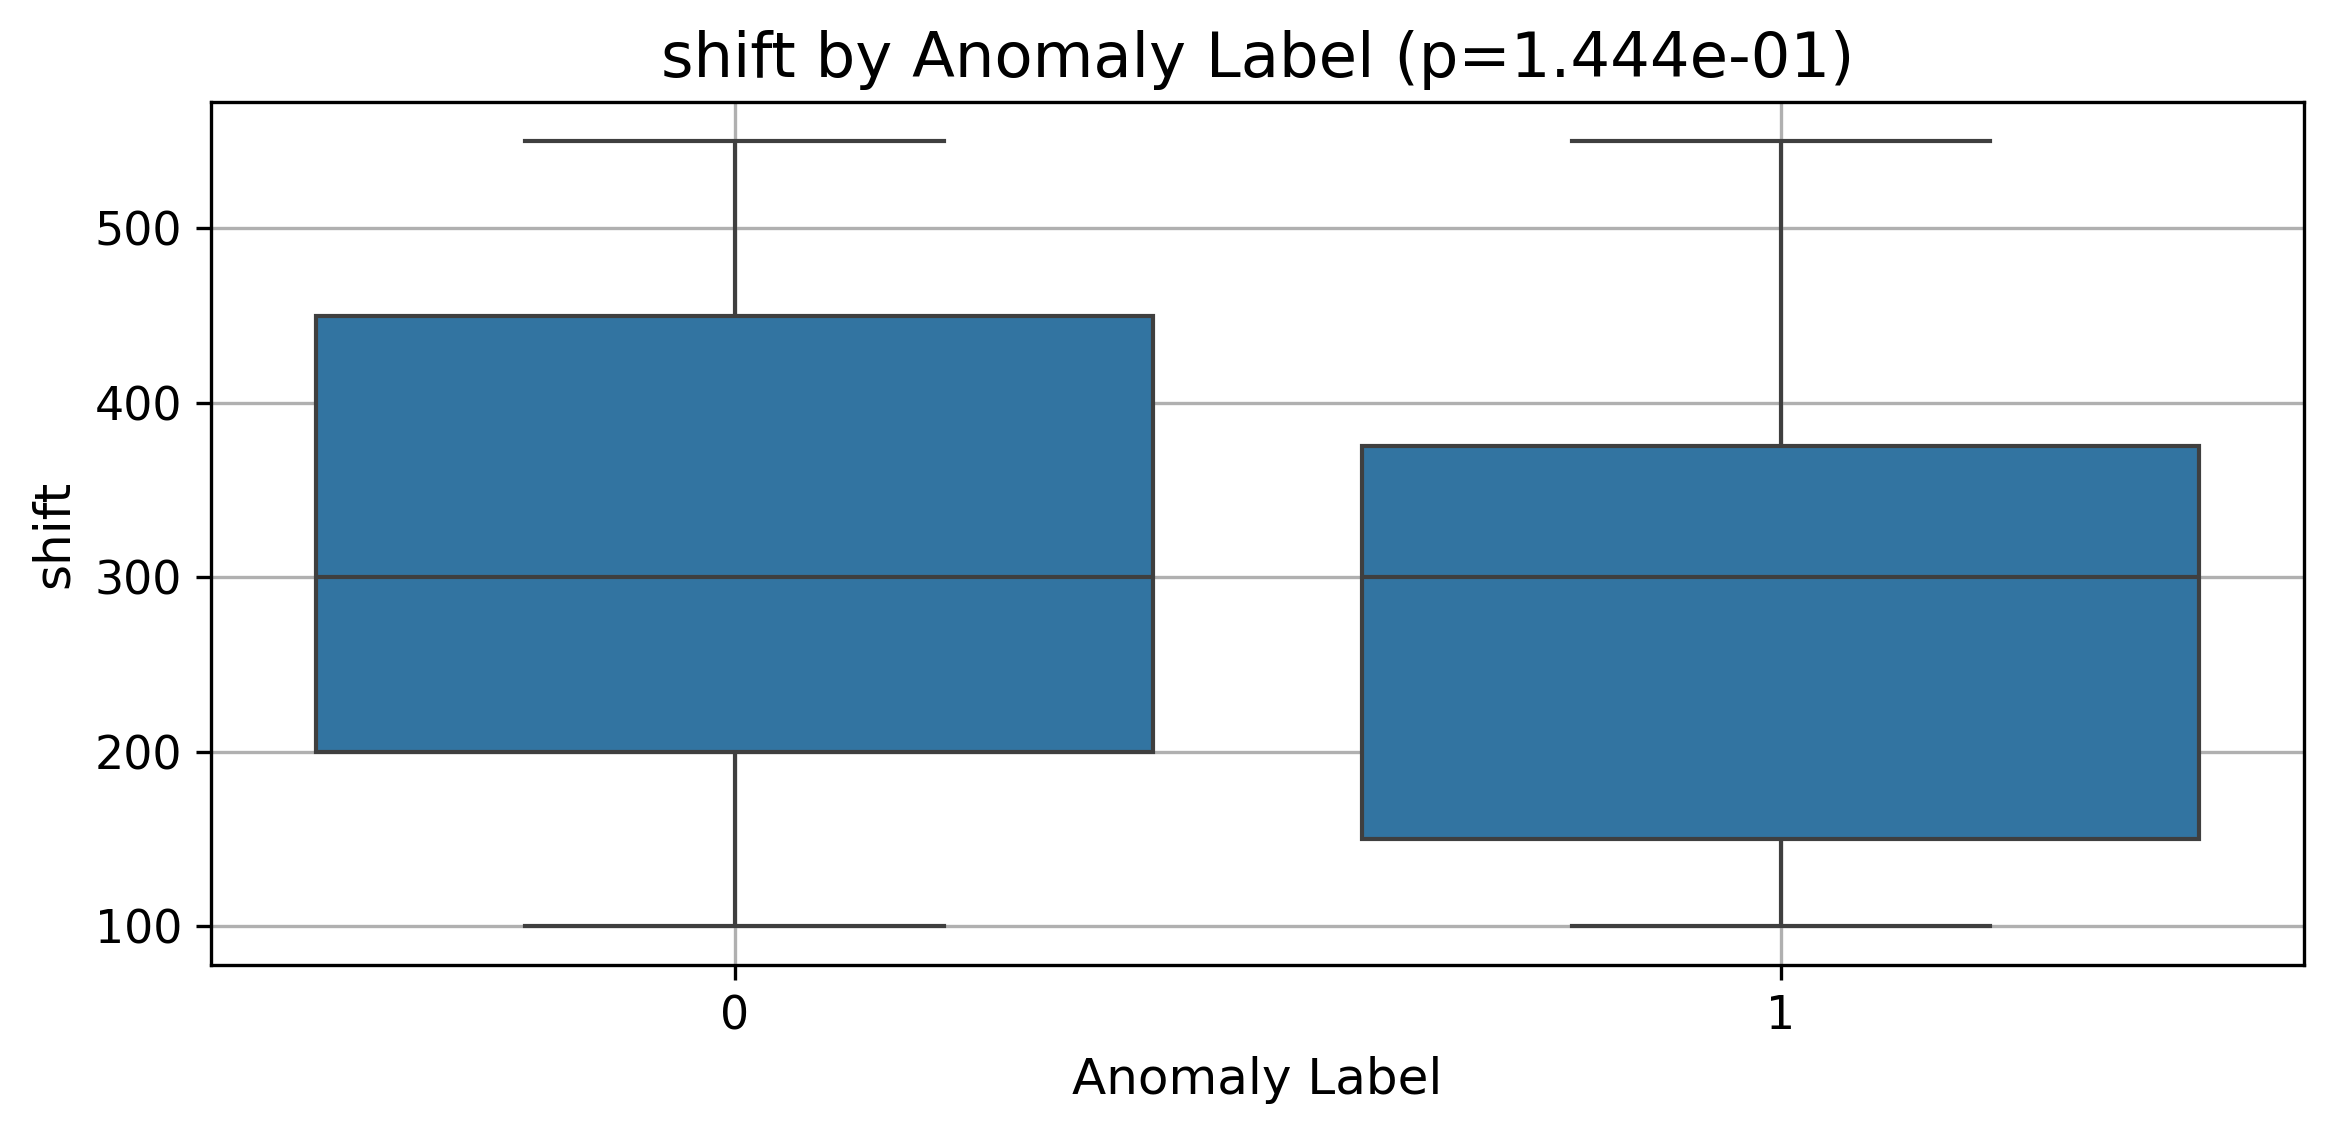

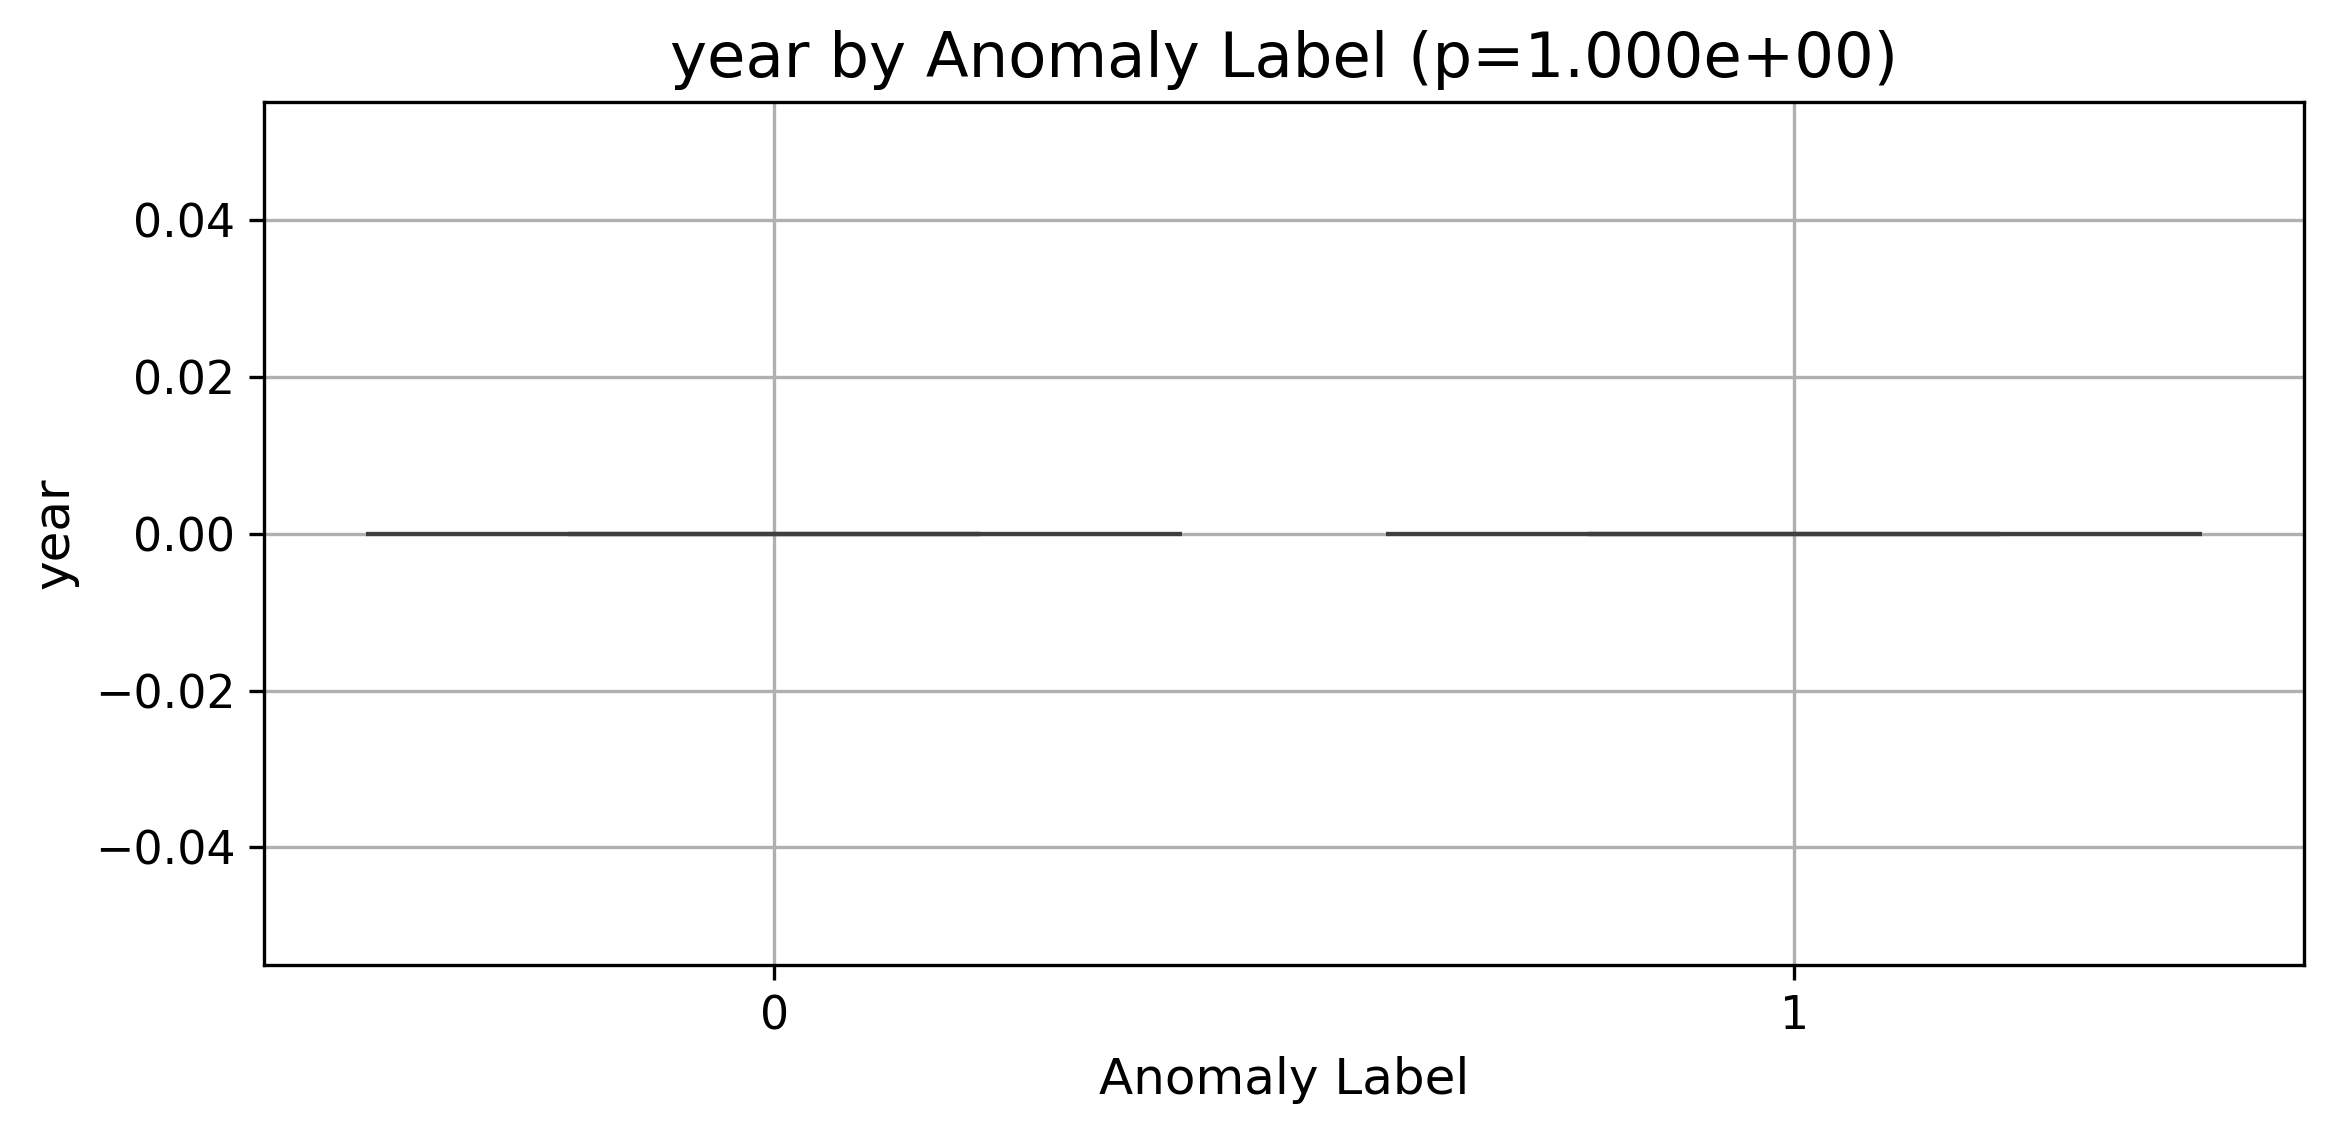


🔍 Static features ranked by significance (Mann-Whitney U test):

Montmorillonite      | p = 1.746e-03 ⭐
Glass                | p = 5.273e-02 
temp                 | p = 1.101e-01 
shift                | p = 1.444e-01 
Alkali-feldspar      | p = 3.040e-01 
Ilmenite             | p = 3.129e-01 
Olivine              | p = 5.503e-01 
Diopside_Mn          | p = 5.632e-01 
Diopside             | p = 6.424e-01 
Plagioclase          | p = 8.411e-01 
Apatite              | p = 8.924e-01 
MikeSorghum          | p = 9.201e-01 
Quartz               | p = 9.204e-01 
year                 | p = 1.000e+00 


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# 1. Extract feature list (excluding identifiers and labels)
exclude_cols = ['file_id', 'cluster', 'anomaly_label']
static_features = [col for col in anomaly_static_df.columns if col not in exclude_cols]

# 2. Prepare summary table for significance results
results = []

# 3. Plot and test each feature
for feature in static_features:
    # Data for each class
    group_0 = anomaly_static_df[anomaly_static_df['anomaly_label'] == 0][feature]
    group_1 = anomaly_static_df[anomaly_static_df['anomaly_label'] == 1][feature]

    # Mann-Whitney U test (non-parametric)
    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

    # Store result
    results.append((feature, p_value))

    # Plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='anomaly_label', y=feature, data=anomaly_static_df)
    plt.title(f"{feature} by Anomaly Label (p={p_value:.3e})")
    plt.xlabel("Anomaly Label")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Print sorted table of features with smallest p-values
results_sorted = sorted(results, key=lambda x: x[1])
print("\n🔍 Static features ranked by significance (Mann-Whitney U test):\n")
for feature, p in results_sorted:
    marker = "⭐" if p < 0.05 else ""
    print(f"{feature:<20} | p = {p:.3e} {marker}")

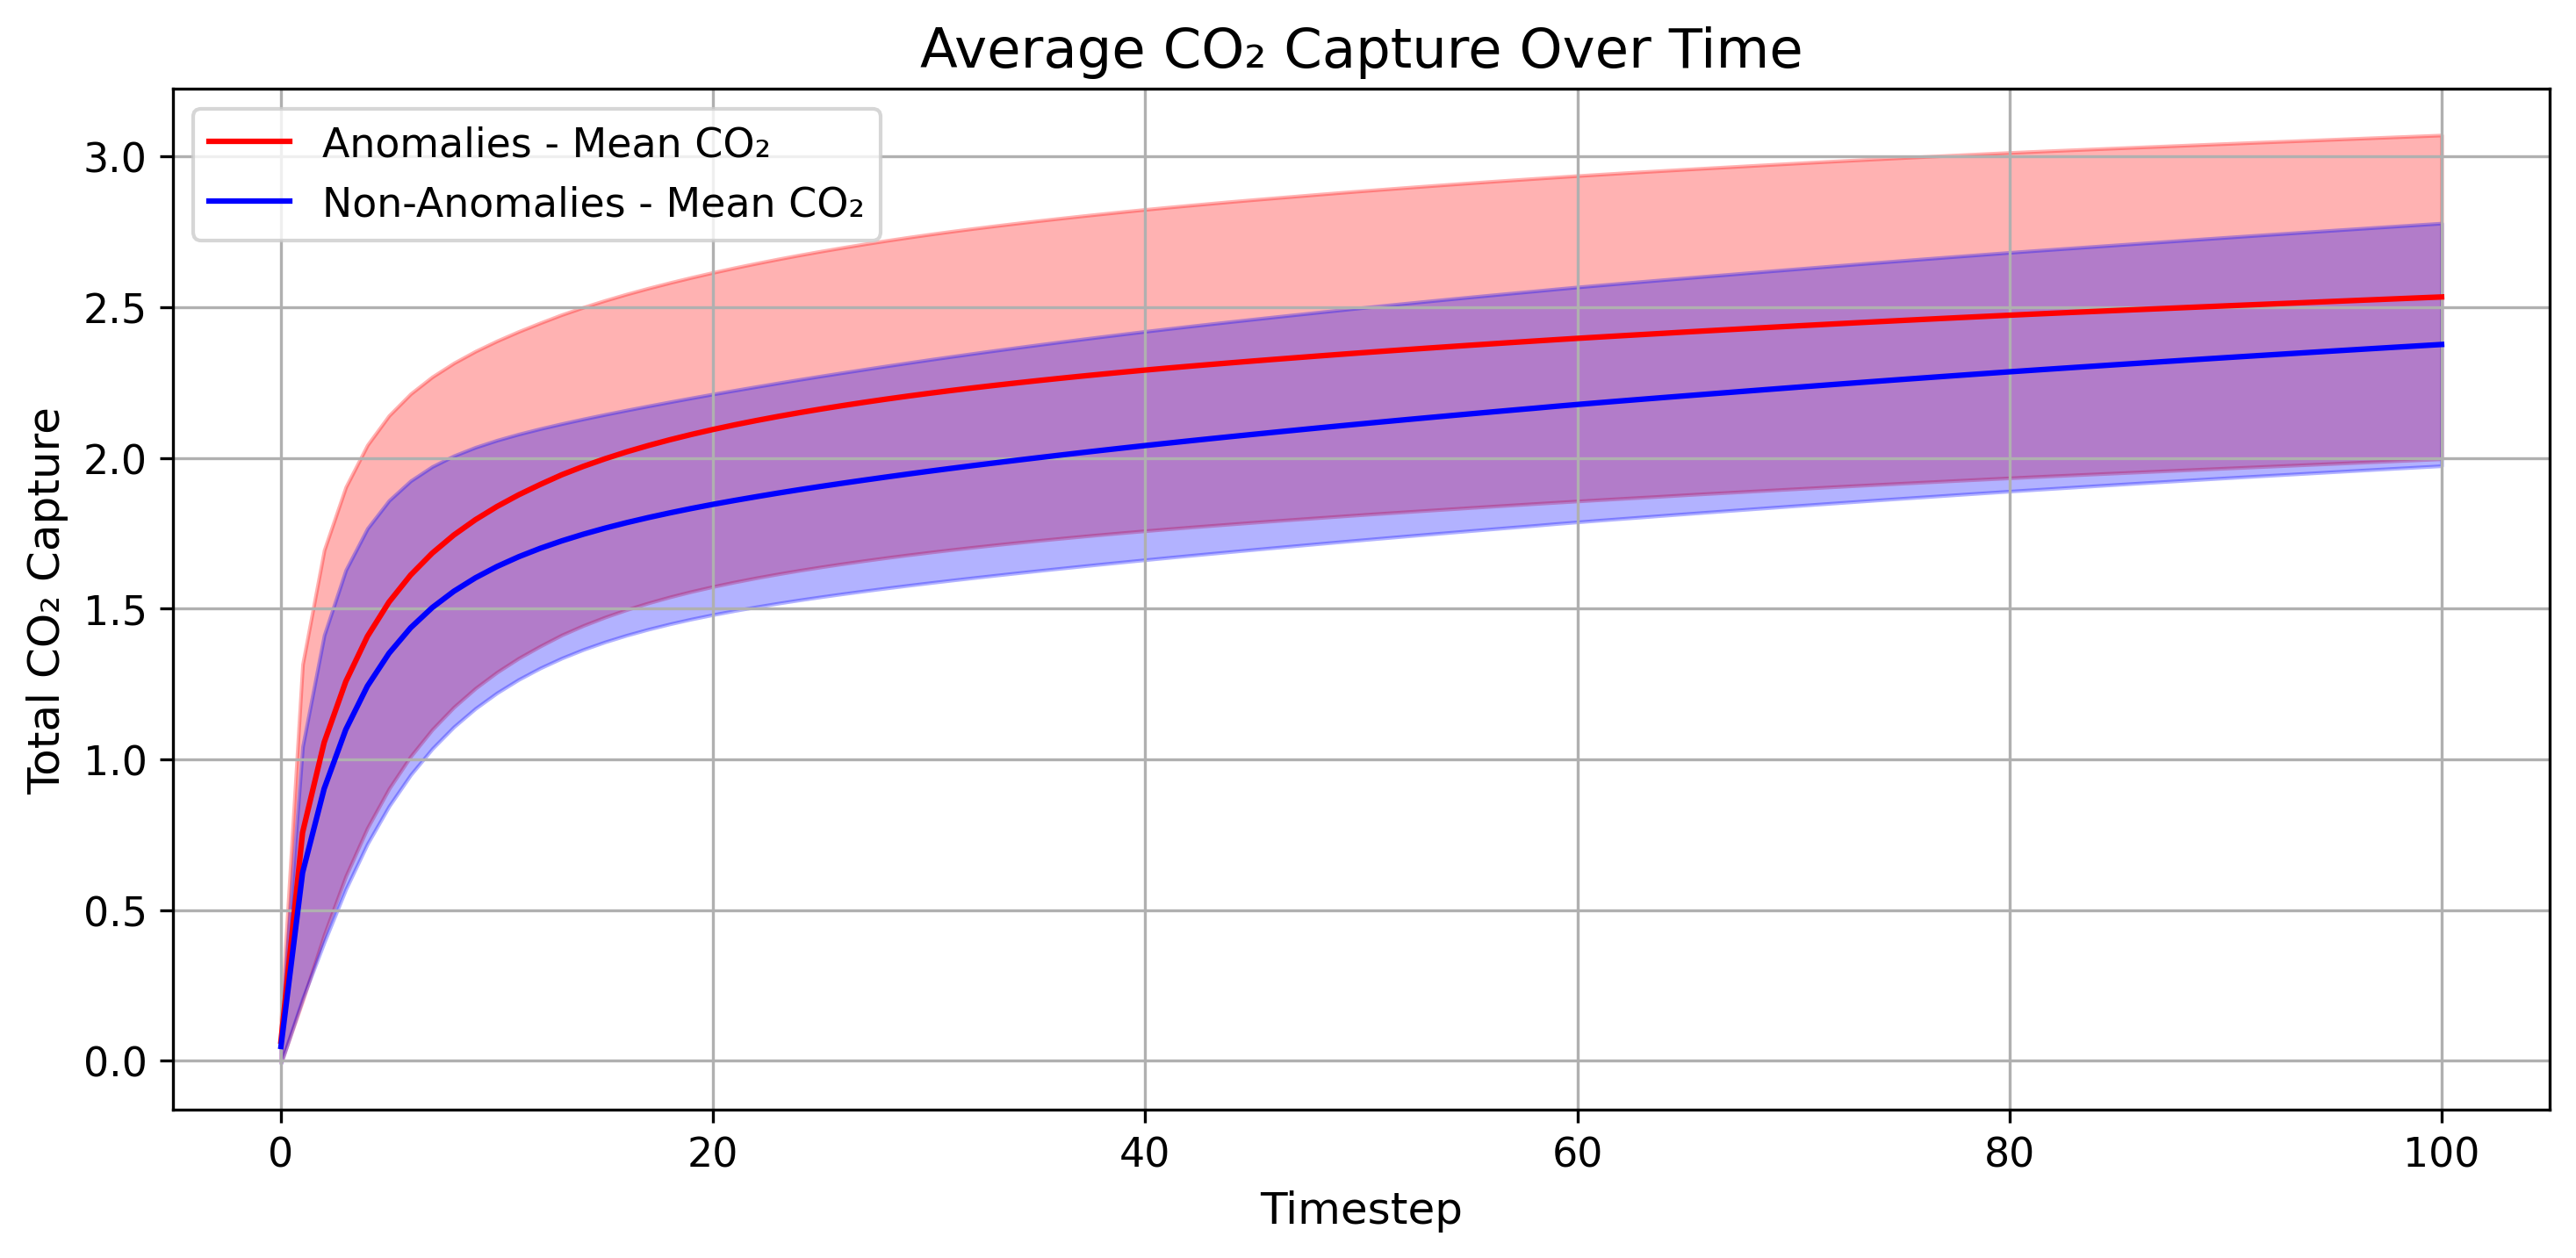

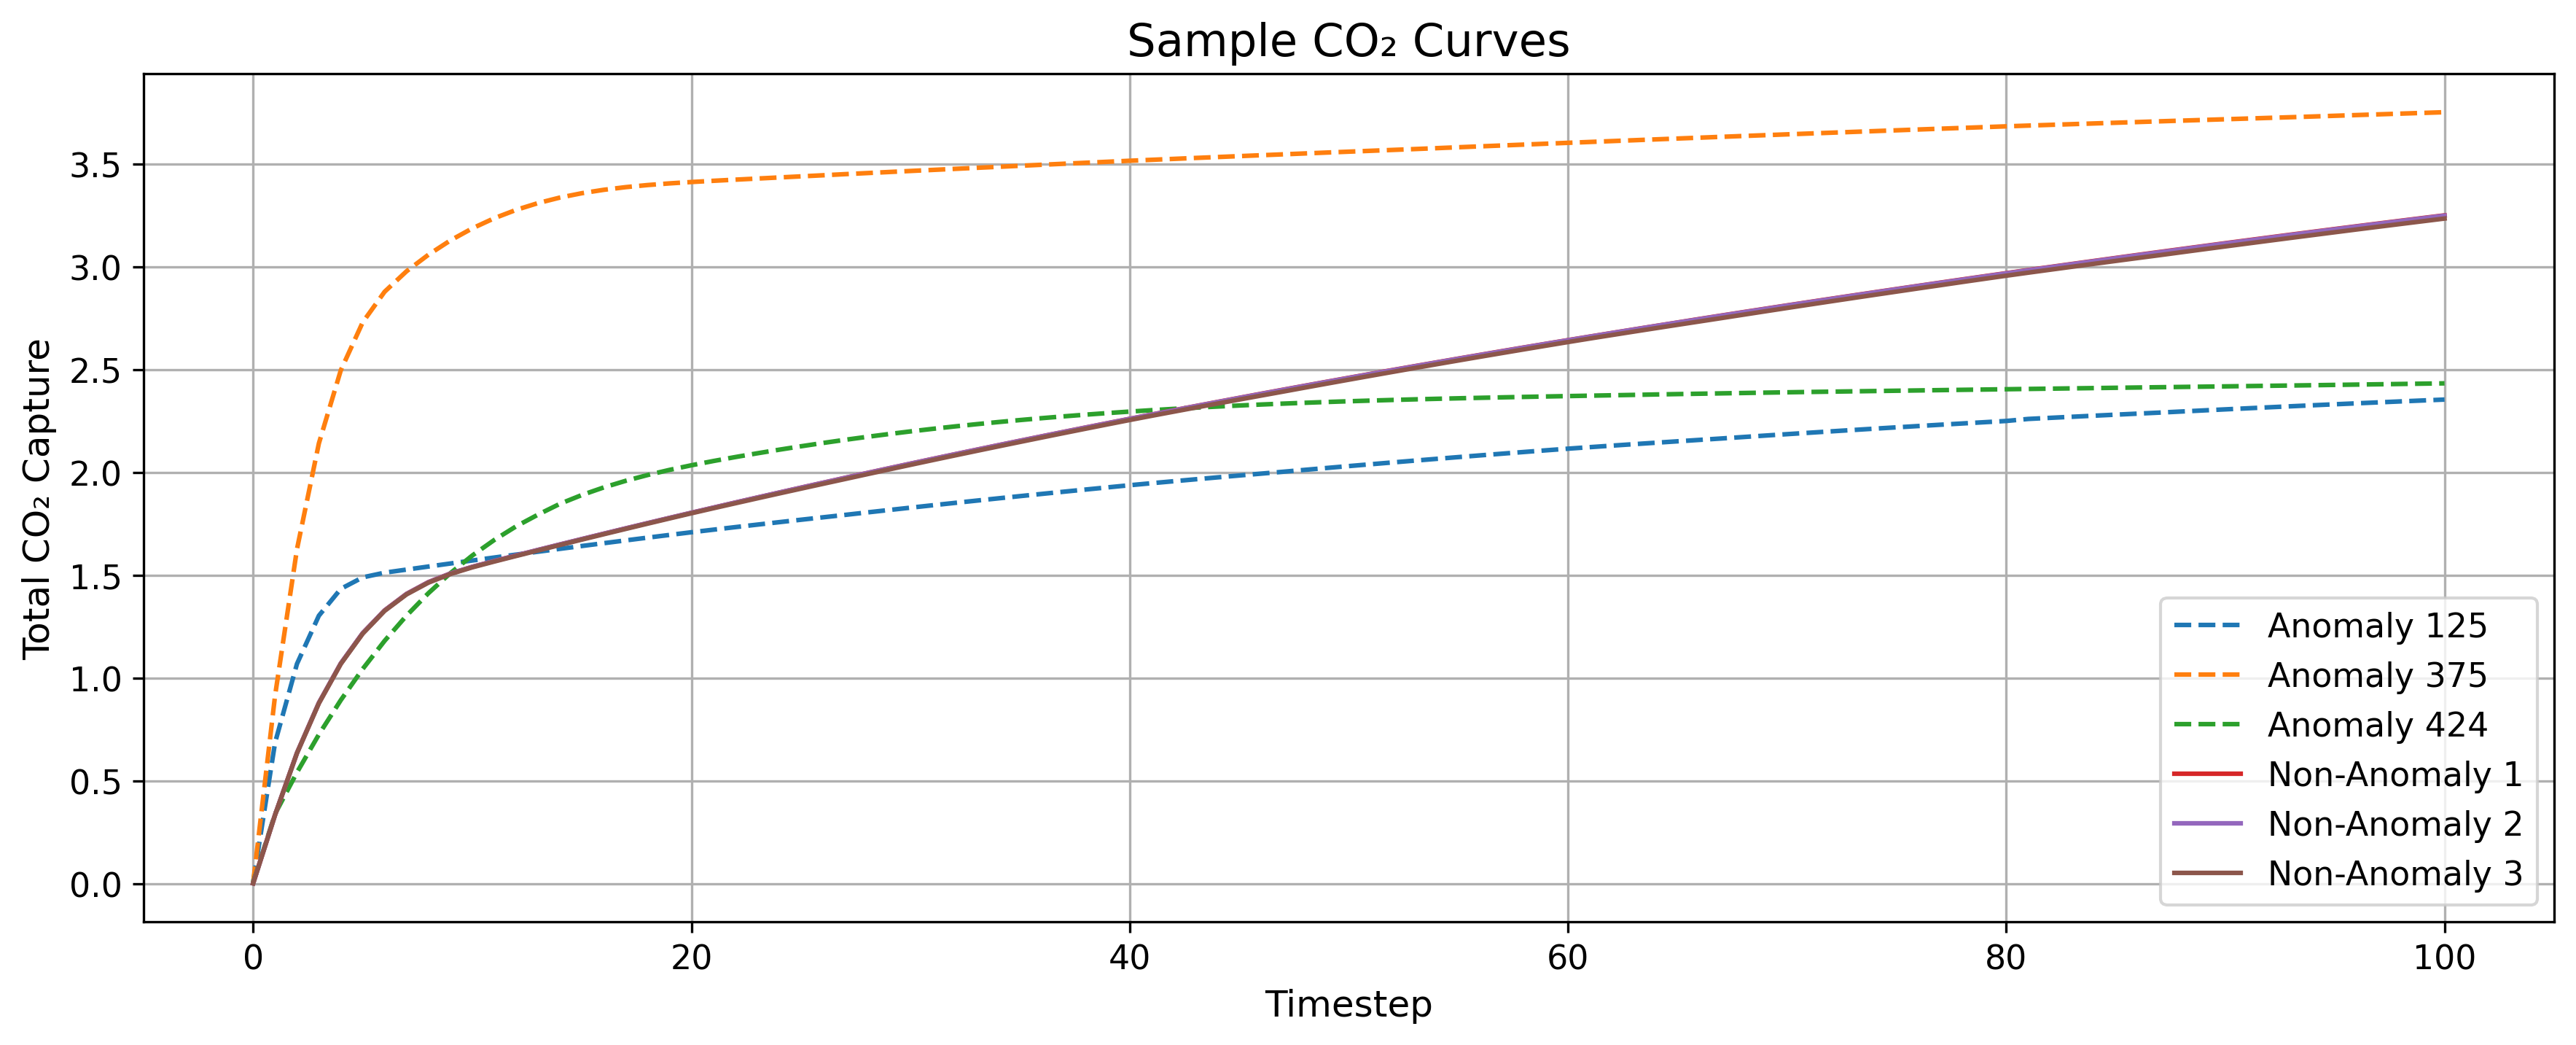

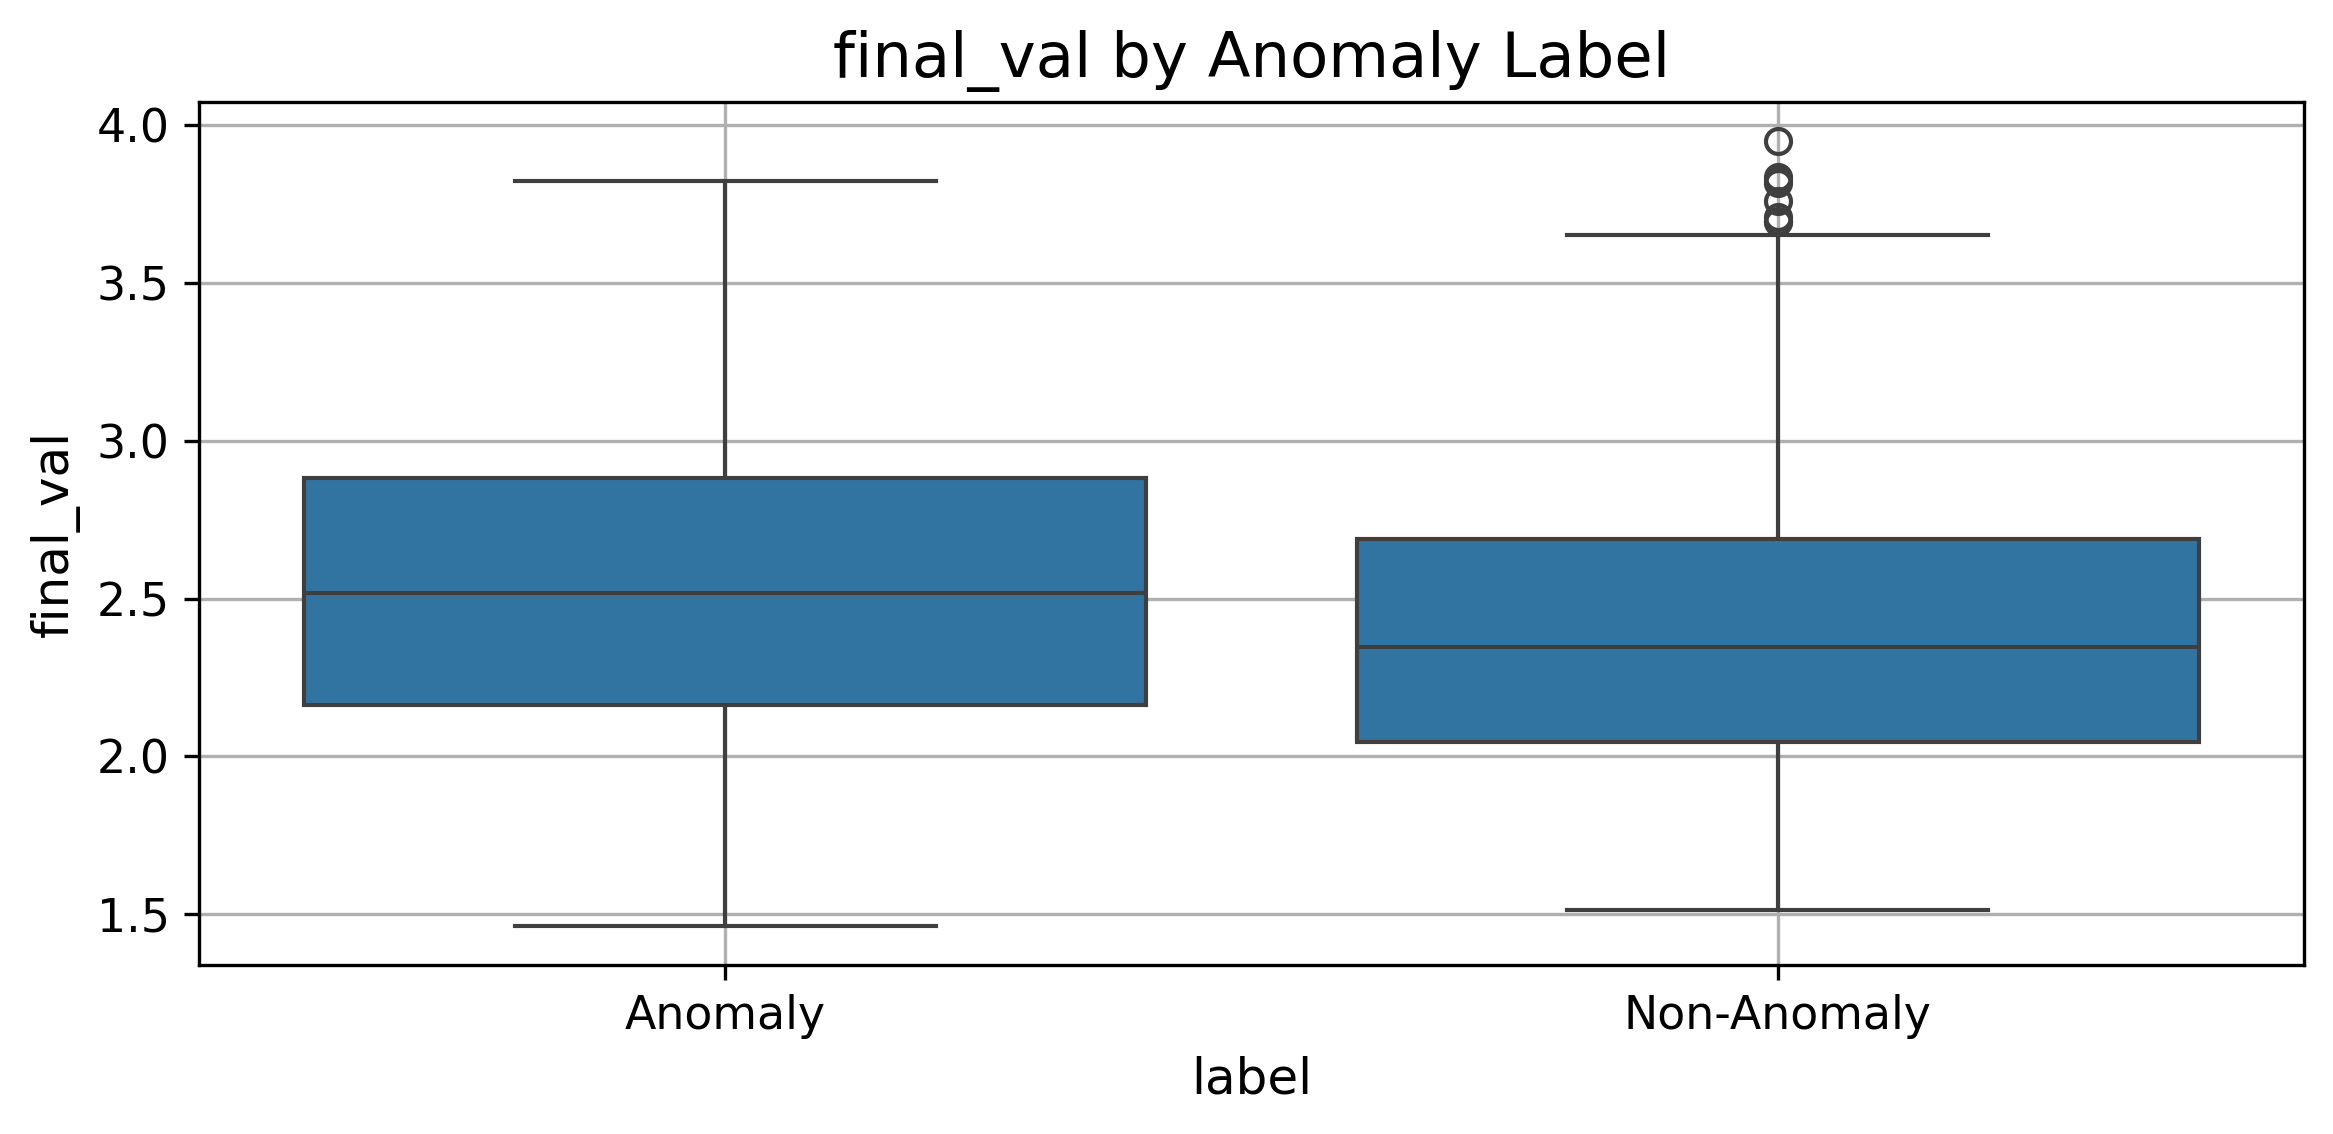

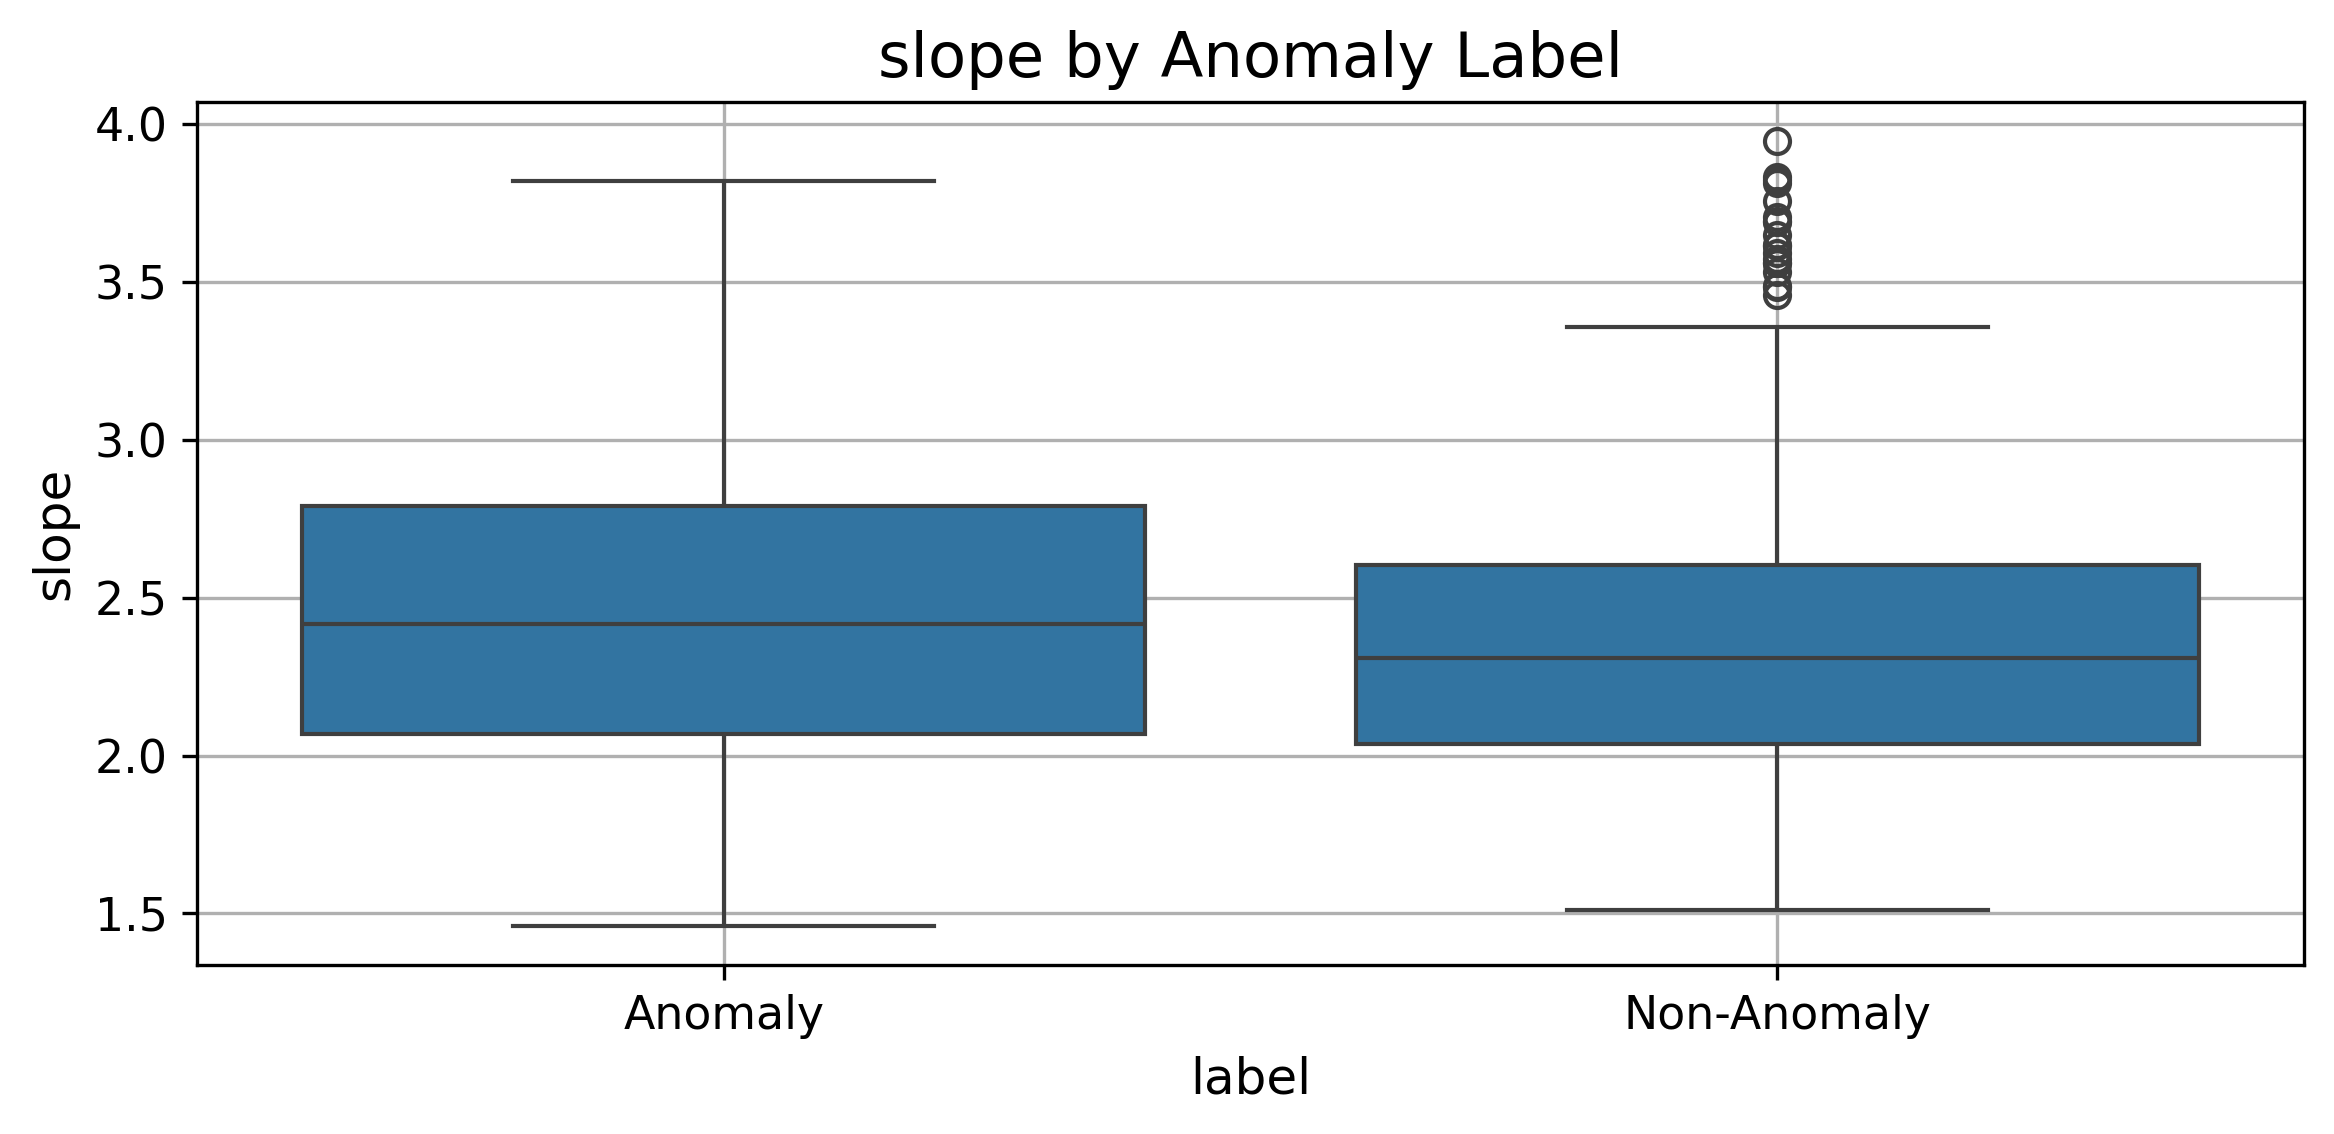

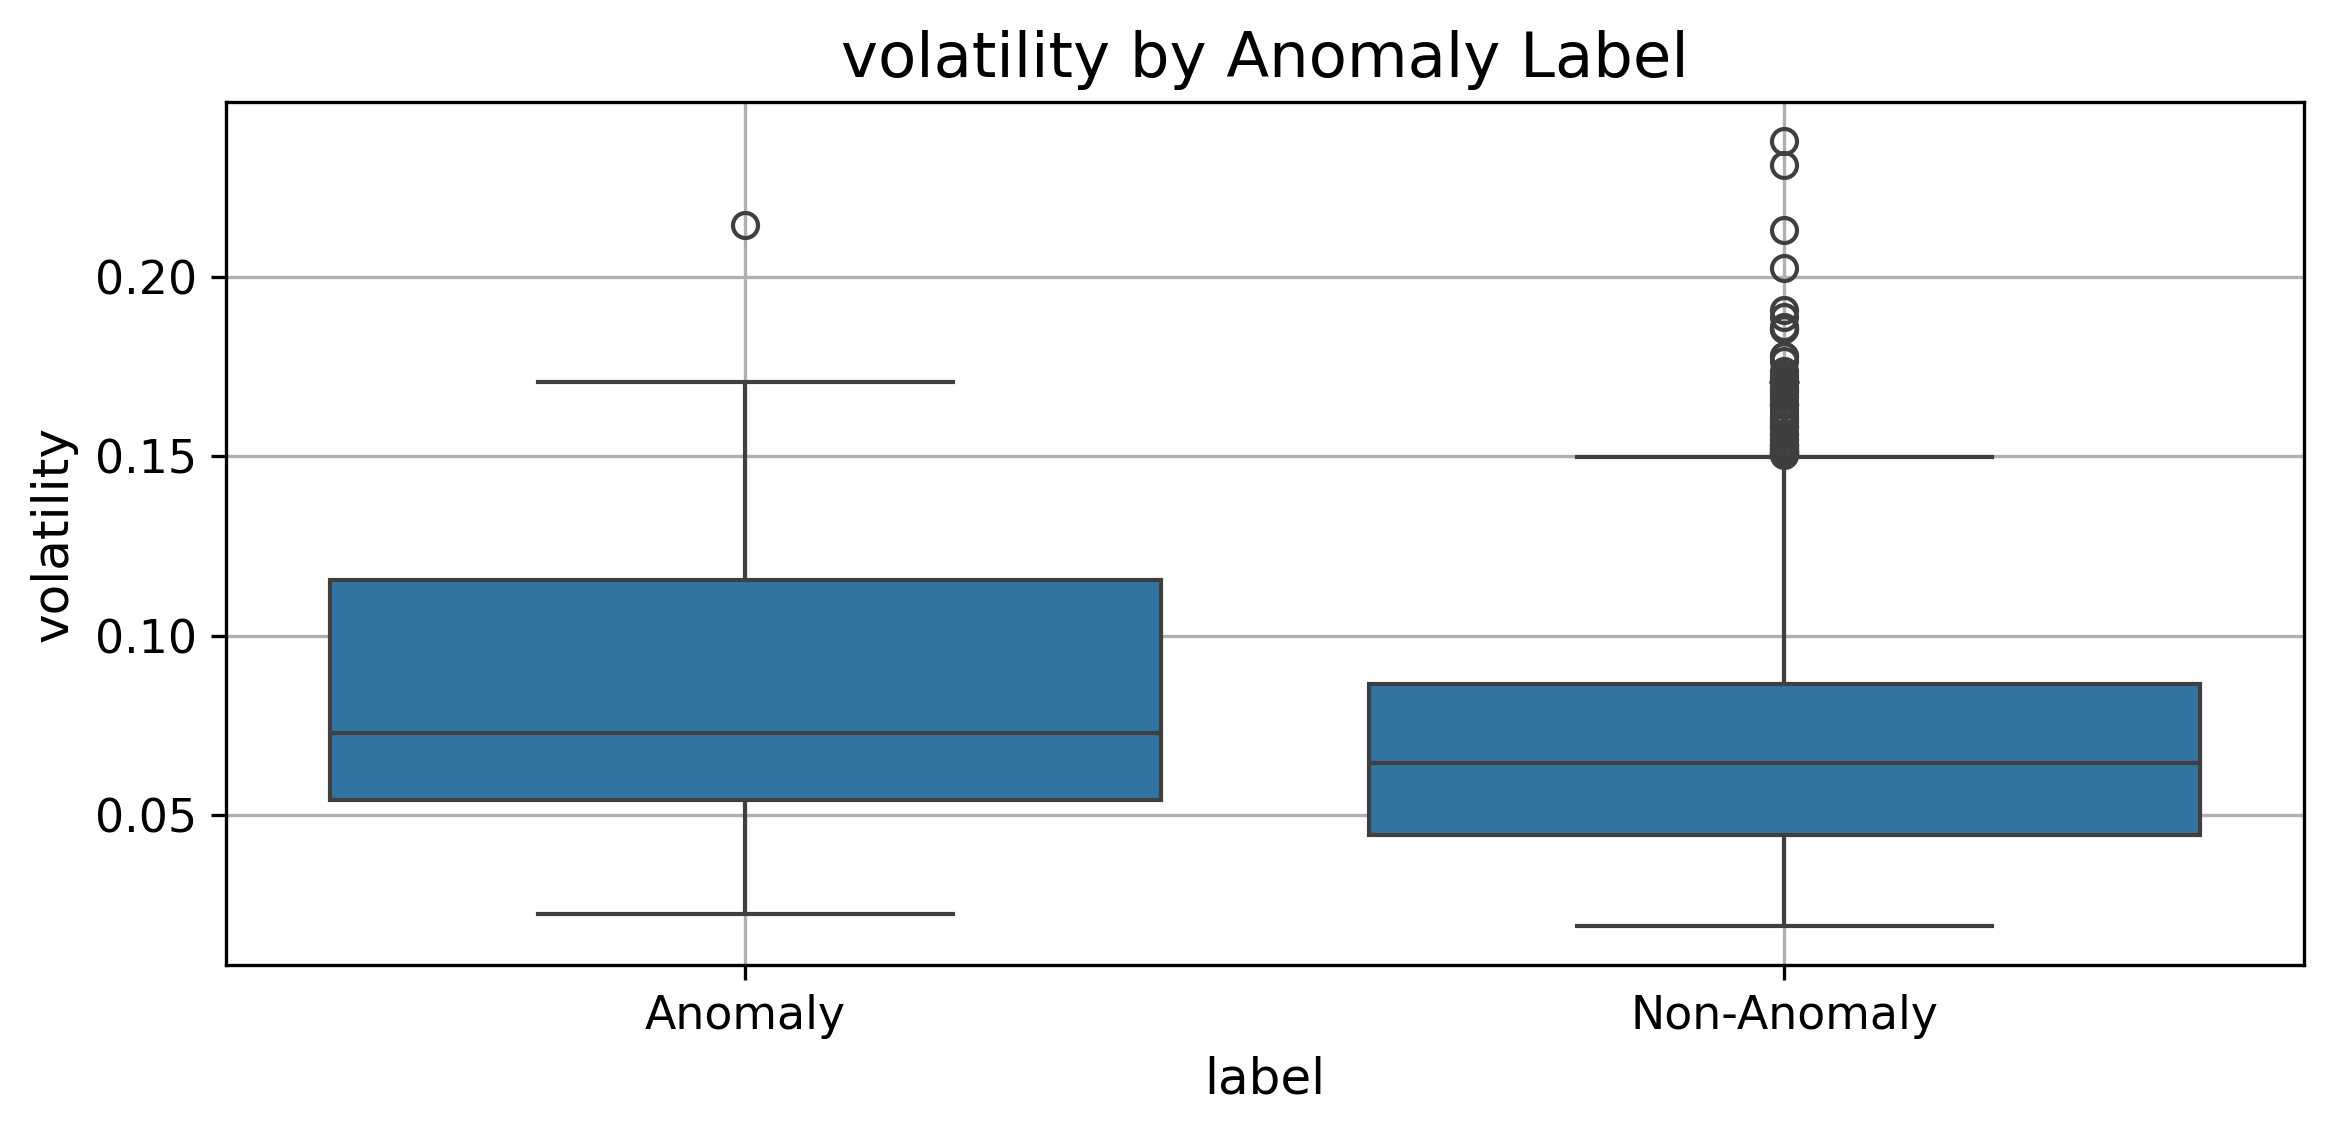

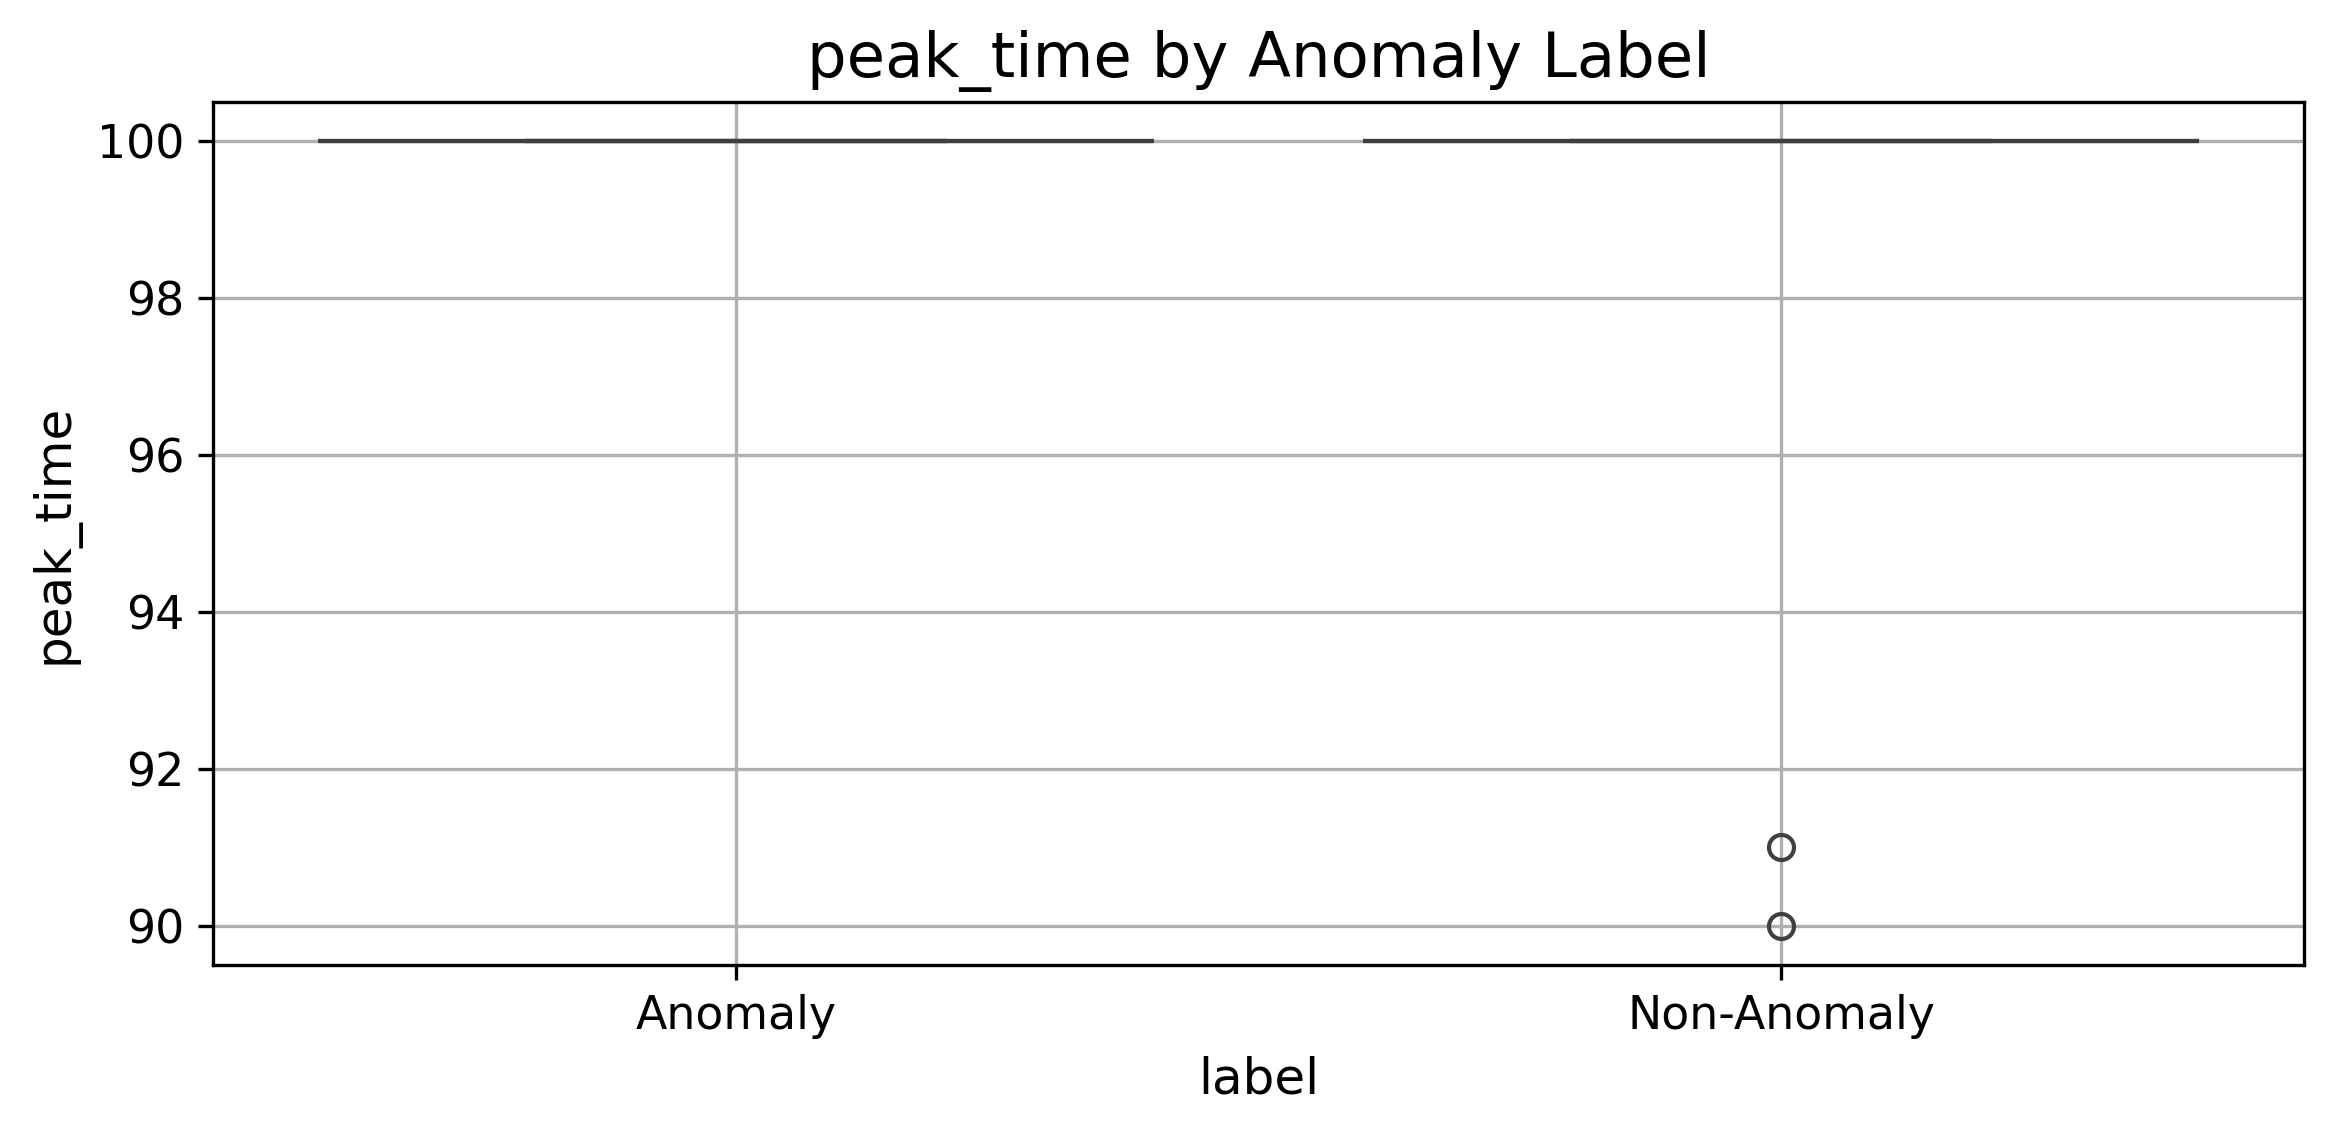

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# Step 4: Time Series Behavior Analysis
# -----------------------------

# 1. Extract anomaly and non-anomaly file_ids
anomaly_ids = anomaly_static_df[anomaly_static_df['anomaly_label'] == 1]['file_id'].tolist()
non_anomaly_ids = anomaly_static_df[anomaly_static_df['anomaly_label'] == 0]['file_id'].tolist()

# 2. Function to extract time series from df_output
def get_curves(file_ids):
    curves = []
    for fid in file_ids:
        ts = df_output[df_output['file_id'] == fid].sort_values('timestep')['CO2'].values
        if len(ts) == 101:
            curves.append(ts)
    return np.array(curves)

anomaly_curves = get_curves(anomaly_ids)
non_anomaly_curves = get_curves(non_anomaly_ids)

# -----------------------------
# 4.1 Average Curve with Shading
# -----------------------------
plt.figure(figsize=(10, 5))
timesteps = np.arange(101)

# Anomaly group
mean_anom = anomaly_curves.mean(axis=0)
std_anom = anomaly_curves.std(axis=0)
plt.plot(timesteps, mean_anom, label='Anomalies - Mean CO₂', color='red')
plt.fill_between(timesteps, mean_anom - std_anom, mean_anom + std_anom, color='red', alpha=0.3)

# Non-anomaly group
mean_non = non_anomaly_curves.mean(axis=0)
std_non = non_anomaly_curves.std(axis=0)
plt.plot(timesteps, mean_non, label='Non-Anomalies - Mean CO₂', color='blue')
plt.fill_between(timesteps, mean_non - std_non, mean_non + std_non, color='blue', alpha=0.3)

plt.title("Average CO₂ Capture Over Time")
plt.xlabel("Timestep")
plt.ylabel("Total CO₂ Capture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4.2 Plot Sample Curves
# -----------------------------
sample_anomalies = anomaly_ids[:3]
sample_non_anomalies = non_anomaly_ids[:3]

plt.figure(figsize=(12, 5))
for fid in sample_anomalies:
    ts = df_output[df_output['file_id'] == fid].sort_values('timestep')['CO2'].values
    plt.plot(ts, label=f"Anomaly {fid}", linestyle='--')
for fid in sample_non_anomalies:
    ts = df_output[df_output['file_id'] == fid].sort_values('timestep')['CO2'].values
    plt.plot(ts, label=f"Non-Anomaly {fid}")
plt.title("Sample CO₂ Curves")
plt.xlabel("Timestep")
plt.ylabel("Total CO₂ Capture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4.3 Quantify Curve Features
# -----------------------------
def compute_features(curves):
    final_val = curves[:, -1]
    slope = curves[:, -1] - curves[:, 0]
    volatility = np.std(np.diff(curves, axis=1), axis=1)
    peak_time = np.argmax(curves, axis=1)
    return pd.DataFrame({
        'final_val': final_val,
        'slope': slope,
        'volatility': volatility,
        'peak_time': peak_time
    })

features_anom = compute_features(anomaly_curves)
features_non = compute_features(non_anomaly_curves)

# Combine for visualization
features_anom['label'] = 'Anomaly'
features_non['label'] = 'Non-Anomaly'
features_all = pd.concat([features_anom, features_non])

# Plot distributions
metrics = ['final_val', 'slope', 'volatility', 'peak_time']
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='label', y=metric, data=features_all)
    plt.title(f"{metric} by Anomaly Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import spearmanr

# Merge static and dynamic data
combined = pd.merge(anomaly_static_df, features_all, left_on='file_id', right_index=True)

# Choose static features of interest
static_features_to_check = ['Montmorillonite', 'temp', 'Apatite']
dynamic_metrics = ['final_val', 'slope', 'volatility', 'peak_time']

# Compute Spearman correlation (non-linear, rank-based)
print("🔗 Spearman correlation between static features and CO₂ dynamics:\n")
for sf in static_features_to_check:
    for dm in dynamic_metrics:
        corr, pval = spearmanr(combined[sf], combined[dm])
        print(f"{sf:<15} vs {dm:<12} → ρ = {corr:.3f}, p = {pval:.3e}")


🔗 Spearman correlation between static features and CO₂ dynamics:

Montmorillonite vs final_val    → ρ = -0.005, p = 8.307e-01
Montmorillonite vs slope        → ρ = -0.007, p = 7.828e-01
Montmorillonite vs volatility   → ρ = 0.000, p = 9.859e-01
Montmorillonite vs peak_time    → ρ = -0.001, p = 9.656e-01
temp            vs final_val    → ρ = -0.302, p = 1.031e-34
temp            vs slope        → ρ = -0.329, p = 4.097e-41
temp            vs volatility   → ρ = -0.133, p = 1.216e-07
temp            vs peak_time    → ρ = -0.014, p = 5.817e-01
Apatite         vs final_val    → ρ = -0.013, p = 6.006e-01
Apatite         vs slope        → ρ = -0.017, p = 4.904e-01
Apatite         vs volatility   → ρ = 0.012, p = 6.354e-01
Apatite         vs peak_time    → ρ = -0.056, p = 2.607e-02


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set save path
folder_path = '/content/drive/MyDrive/Figures'
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, 'montmorillonite_distribution.png')

# Extract data
anom = anomaly_static_df[anomaly_static_df['anomaly_label'] == 1]['Montmorillonite']
non_anom = anomaly_static_df[anomaly_static_df['anomaly_label'] == 0]['Montmorillonite']

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(anom, color='red', kde=True, label='Anomalies', stat='density', bins=20, alpha=0.5)
sns.histplot(non_anom, color='blue', kde=True, label='Non-Anomalies', stat='density', bins=20, alpha=0.5)

plt.title("Montmorillonite Distribution in Anomalous vs Non-Anomalous Time Series")
plt.xlabel("Montmorillonite Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig(save_path, dpi=300)
plt.close()

print(f"✅ Plot saved to: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Plot saved to: /content/drive/MyDrive/Figures/montmorillonite_distribution.png


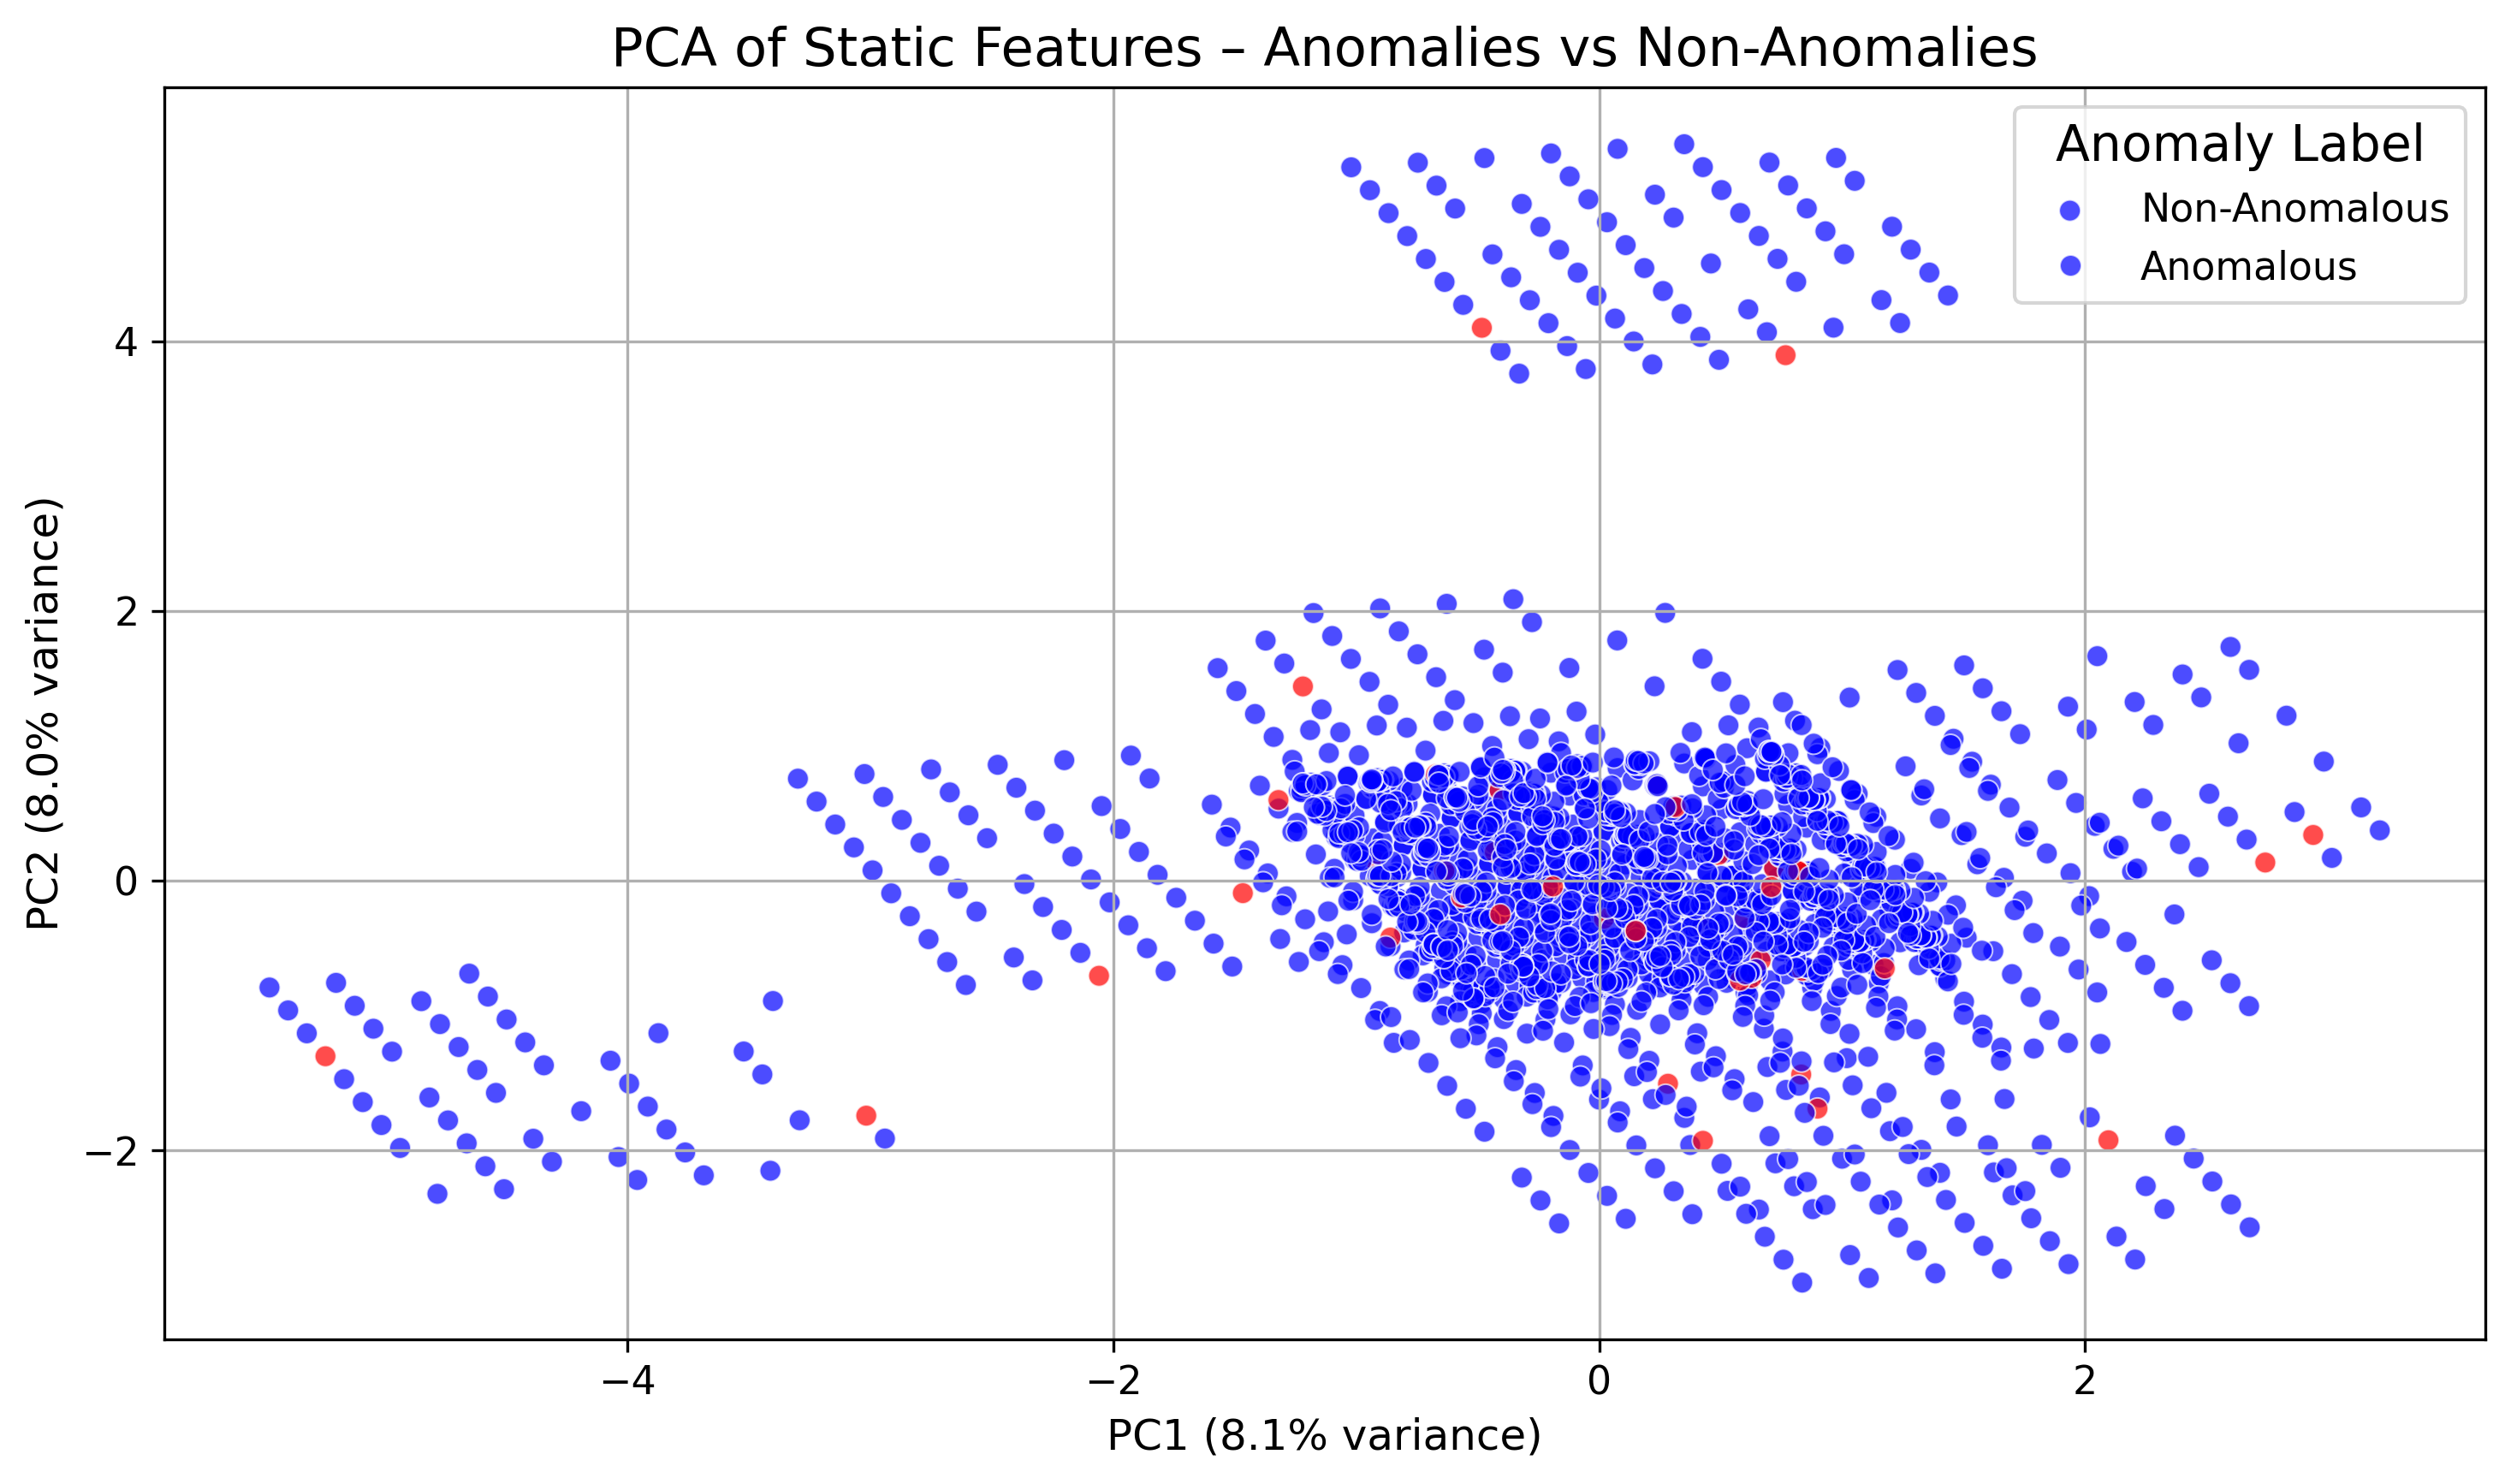

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select static feature columns only
static_cols = [col for col in anomaly_static_df.columns if col not in ['file_id', 'cluster', 'anomaly_label']]
X = anomaly_static_df[static_cols].values

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Create dataframe for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'anomaly_label': anomaly_static_df['anomaly_label']
})

# 5. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='anomaly_label', palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title("PCA of Static Features – Anomalies vs Non-Anomalies")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Anomaly Label", labels=["Non-Anomalous", "Anomalous"])
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
metrics

['final_val', 'slope', 'volatility', 'peak_time']